In [6]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'savefig.dpi':300, 'axes.labelweight':'normal'})
matplotlib.rcParams['axes.linewidth'] = 0.8
from matplotlib import rc
preamble = r'''
\usepackage{physics} \usepackage{upgreek} \usepackage{mhchem} \usepackage{bm}
'''
import matplotlib.colors as colors
plt.rc('text.latex', preamble=preamble)
rc('text', usetex=True)
import numpy as np
import scipy, os
import seaborn as sns
import scipy.linalg as LA
import time

os.chdir('/Users/ana/Desktop/ta2nise5')

import tokovi_drugic
import helpers

from scipy.optimize import curve_fit

U = 2.5 # eV
V = 0.785 # eV
a = 3.51 # A
b = 15.79 # A
b2 = 1.927 # A

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters'

In [3]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

''' create TNS class '''
class TNS:
    def __init__(self, a, b, b2, Ny, Nx, U, V, mu0, parameters1, parameters2, eps0):
        self.parameters1 = parameters1
        self.parameters2 = parameters2
        self.Nx, self.Ny = Nx, Ny
        self.Nk = Ny * Nx
        Ky = 2*np.pi/b * np.arange(-Ny/2, Ny/2) / Ny
        Kx = 2*np.pi/a * np.arange(-Nx/2, Nx/2) / Nx
        Kxmesh, Kymesh = np.meshgrid(Kx, Ky)
        self.kxmesh = Kxmesh
        self.kymesh = Kymesh
        self.hop = helpers.H_hopping(self.kymesh, self.kxmesh, a, b)
        self.perturb = helpers.H_perturb(self.kymesh, self.kxmesh, a, b)
        self.rho = helpers.Rho0(self.Ny, self.Nx)
        self.mu = mu0

        self.fock = helpers.H_fock(self.kxmesh, self.Nk, self.rho, a, V)
        self.hartree = helpers.H_hartree(self.rho, self.Nk, U, V)

        #self.j_matrix = tokovi_drugic.j_tok(self.kymesh, self.kxmesh, a, b, b2)
        #self.j1_matrix = tokovi_drugic.j_1(self.kymesh, self.kxmesh, a, b, b2,  self.rho, self.Nk, U, V, mu=self.mu)
        #self.j2_matrix = tokovi_drugic.j_MF(self.kymesh, self.kxmesh, self.rho, V, a, b, b2)

        #self.j2_matrix_full = np.zeros((2,6,6,6,Ny,Nx), dtype='complex')
        #self.j2_matrix_full[0], self.j2_matrix_full[1] = tokovi_drugic.j_2_kq(self.kymesh, self.kxmesh, 0, 0, V, a, b, b2)

        self.rho, self.energije, self.fs, self.vecs, self.err, self.n, self.fock, self.hartree = helpers.GS(self.kxmesh, self.rho, self.hop, self.perturb, self.hartree, self.fock, self.mu, eps0, a, U, V, 1e-10, maxiter=1000, N_epsilon=5)
        self.rho0 = self.rho
        self.fock0 = self.fock
        self.hartree0 = self.hartree
        self.phi = helpers.Phi(self.kxmesh, self.Nk, self.rho, a)[0].real

        self.phis = []
        self.mus = []
        self.errors = []
        self.occupations = []
        self.times_rho = []
        self.times_boltzmann = []
        self.times_kubo = []
        self.Ts = []
        self.betas = []

    def next_T(self, T, i) -> None:
        start = time.time()
        if i == 1: dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = self.parameters1
        elif i ==2: dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = self.parameters2
        rho, energije, fs, vecs, fock, hartree, err, n, mu = helpers.NewMu(self.kxmesh, self.rho, self.hop, self.perturb, self.hartree, self.fock,
                                                                a, U, V, T, self.mu,
                                                                dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials)
        self.rho = rho
        self.energije = energije
        self.fs = fs
        self.vecs = vecs
        self.fock = fock
        self.hartree = hartree
        self.mu = mu
        self.err = err
        self.n = n
        self.times_rho.append(time.time() - start)
        print(1/T, err, n, helpers.Phi(self.kxmesh, self.Nk, rho, a)[0].real)

    def run(self, Ts, Gamma, eps=1e-5, transport=None, transportB=None):
        for _, T in enumerate(Ts):
            if T == Ts[-1]:
                self.next_T(T, 1)
                self.Ts.append(T)
                self.betas.append(1/T)
                self.phis.append(helpers.Phi(self.kxmesh, self.Nk, self.rho, a)[0].real)
                self.mus.append(self.mu)
                self.errors.append(self.err)
                self.occupations.append(self.n)
                #self.j1_matrix = tokovi_drugic.j_1(self.kymesh, self.kxmesh, a, b, b2, mu=self.mu)
                #if transportB == 'evaluate':
                #    l11_xx, l11_yy, l12_xx, l12_yy = tokovi_drugic.Ln_Boltzmann(self.kymesh, self.kxmesh, self.energije, T, self.mu)
                #    self.L11_xx_boltz.append(l11_xx)
                #    self.L11_yy_boltz.append(l11_yy)
                #    self.L12_xx_boltz.append(l12_xx)
                #    self.L12_yy_boltz.append(l12_yy)
                #if transport == 'evaluate':
                #    omega_max = 1#np.sqrt(np.abs(np.arccosh(1/(eps*4*T))) * 2 * T)
                #    omegas, trans = tokovi_drugic.transportna_phi(self.kymesh, self.vecs, self.energije, self.j_matrix, self.mu, omega_max=omega_max, domega=domega, Gamma=Gamma)
                    #self.j2_matrix = tokovi_drugic.j_MF(self.kymesh, self.kxmesh, self.rho, V, a, b, b2)
                    #_, transK, transI, j_matrix_new, j1_matrix_new, j2_matrix_new = tokovi_drugic.transportna_phiE(self.kymesh, self.vecs, self.energije, self.j_matrix, self.j1_matrix, self.j2_matrix, self.mu, Gamma=Gamma, omega_max=omega_max, domega=domega)
                    #self.j_matrix_new = j_matrix_new
                    #self.j1_matrix_new = j1_matrix_new
                    #self.j2_matrix_new = j2_matrix_new
                    #_, transI_full = tokovi_drugic.transportna_I_full(self.kymesh, self.vecs, self.energije, self.fs, self.j2_matrix_full, self.j_matrix, self.mu, omega_max, domega, Gamma=Gamma)
                    #for i in range(2):
                      #  l11 = tokovi_drugic.L11(trans[i], omegas, T)
                      #  #l12_k, l12_i, l12_i_full, l12_i_neint = tokovi_drugic.L12(transK[i], transI[i], transI[i], trans[i], omegas, T)
                      #  if i == 0:
                      #      self.L11_xx.append(l11)
                            #self.L12_k_xx.append(l12_k)
                            #self.L12_i_xx.append(l12_i)
                            #self.L12_i_full_xx.append(l12_i_full)
                            #self.L12_i_neint_xx.append(l12_i_neint)
                      #  else:
                      #      self.L11_yy.append(l11)
                            #self.L12_k_yy.append(l12_k)
                            #self.L12_i_yy.append(l12_i)
                            #self.L12_i_full_yy.append(l12_i_full)
                            #self.L12_i_neint_yy.append(l12_i_neint)
            else:
                self.next_T(T, 2)

    def reset(self, mu0):
        self.rho = self.rho0
        self.hartree = self.hartree0
        self.fock = self.fock0
        self.mu = mu0

    def reset_infty(self):
        self.rho = helpers.Rhoinfty(self.Ny, self.Nx)
        self.hartree = helpers.H_hartree(self.rho, self.Nk, U, V)
        self.fock = helpers.H_fock(self.kxmesh, self.Nk, self.rho, a, V)
        
        _, energije, fs, vecs, _, _, _, _ = helpers.Rho_next(self.kxmesh, self.rho, self.hop, self.perturb, self.hartree, self.fock, a, U, V, 0, self.mu, 50, 0.5, 1e-10, eps0=0.0, N_epsilon=5)
        self.energije = energije
        self.fs = fs
        self.vecs = vecs

    def collect(self):
        self.phis = np.array(self.phis)
        self.mus = np.array(self.mus)
        self.errors = np.array(self.errors)
        self.occupations = np.array(self.occupations)
        self.times_rho = np.array(self.times_rho)
        self.times_boltzmann = np.array(self.times_boltzmann)
        self.times_kubo = np.array(self.times_kubo)
        self.Ts = np.array(self.Ts)
        self.betas = np.array(self.betas)

In [114]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")
dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Gamma = 0.01


Ny, Nx = 200, 200
mu = 2.84
eps0 = 0.1
s = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2, eps0)


Found ground state with error=7.722078532168553e-11, occupation error=8.881784197001252e-16


In [8]:
beta0 = 350
scale = 1.02
betas = np.linspace(300,350,10)[::-1]
ends = [int(np.emath.logn(scale, beta0/beta)) for beta in betas]
Ts = 1/betas

Gamma = 0.01 

for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    s.reset(mu)
    set_betas = beta0/scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s.run(set_Ts, Gamma)# transportB='evaluate')
    if len(s.phis) > 1: print(s.phis[-1])

350.0
-------------
344.44444444444446
-------------
338.8888888888889
-------------


C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:105: RuntimeWarning: overflow encountered in exp
  np.fill_diagonal(fs[:, :, 0, n], 1/(1 + np.exp((en - mu)/T)))
C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:113: RuntimeWarning: overflow encountered in exp
  np.fill_diagonal(fs[:, :, Ny//2, n], 1/(1 + np.exp((en - mu)/T)))
C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:122: RuntimeWarning: overflow encountered in exp
  np.fill_diagonal(fs[:, :, m, 0], 1/(1 + np.exp((en - mu)/T)))
C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:146: RuntimeWarning: overflow encountered in exp
  np.fill_diagonal(fs[:, :, m, n], 1/(1 + np.exp((en - mu)/T)))
C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:147: RuntimeWarning: overflow encountered in exp
  np.fill_diagonal(fs[:, :, -m, -n], 1/(1 + np.exp((en - mu)/T)))
C:\Users\anast\OneDrive\Namizje\1m\poletje\ta2nise5\helpers.py:161: RuntimeWarning: overflow encountered in exp
  

350.0 6.394162976874895e-11 1.9999999999999982 0.14766544285811342
333.3333333333333
-------------
350.0 6.394162976874895e-11 1.9999999999999982 0.14766544285811342
343.1372549019608 5.283540271960874e-11 2.0000000000000466 0.1476654428420145
0.1476654428420145
327.77777777777777
-------------
350.0 6.394162976874895e-11 1.9999999999999982 0.14766544285811342
343.1372549019608 5.283540271960874e-11 2.0000000000000466 0.1476654428420145
336.4090734332949 4.366484951390248e-11 2.000000000000157 0.14766544282870964
0.14766544282870964
322.22222222222223
-------------
350.0 6.394162976874895e-11 1.9999999999999982 0.14766544285811342
343.1372549019608 5.283540271960874e-11 2.0000000000000466 0.1476654428420145
336.4090734332949 4.366484951390248e-11 2.000000000000157 0.14766544282870964
329.81281709146555 3.590727715163666e-11 2.000000000000517 0.14766544281773875
0.14766544281773875
316.6666666666667
-------------
350.0 6.394162976874895e-11 1.9999999999999982 0.14766544285811342
343.137

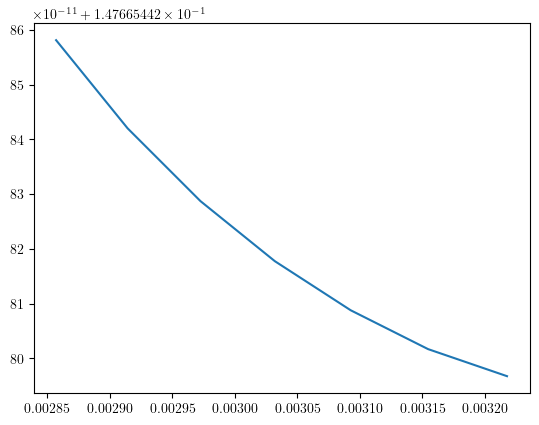

In [10]:
plt.plot(s.Ts, s.phis)

In [115]:
kinetic = tokovi_drugic.kinetic()
kinetic_extend = tokovi_drugic.kinetic(extend=True)

pos = tokovi_drugic.positions(a, b, b2)
interaction = tokovi_drugic.interaction()

tok = tokovi_drugic.j_tok(s.kymesh, s.kxmesh, a, b, b2, kinetic)

In [116]:
mat1 = tokovi_drugic.mf_matrix1(s.kymesh, s.kxmesh, s.rho, a, b, U, V, pos, kinetic_extend, interaction)
mat2 = tokovi_drugic.mf_matrix2(s.kymesh, s.kxmesh, s.rho, a, b, U, V, pos, kinetic_extend, interaction)
mat3 = tokovi_drugic.mf_matrix3(s.kymesh, s.kxmesh, s.rho, a, b, U, V, pos, kinetic_extend, interaction)
mat4 = tokovi_drugic.mf_matrix4(s.kymesh, s.kxmesh, s.rho, a, b, U, V, pos, kinetic_extend, interaction)


In [142]:
mat1[1,0,3]

array([[ 1.48392058e-17-1.38777878e-17j,  3.80608285e-03-5.97907272e-05j,
         7.60840955e-03-2.39103903e-04j, ...,
        -1.14032277e-02-5.37762566e-04j, -7.60840955e-03-2.39103903e-04j,
        -3.80608285e-03-5.97907272e-05j],
       [ 1.38777878e-17-1.38777878e-17j,  3.80608285e-03+5.97907272e-05j,
         7.61216569e-03-1.38777878e-17j, ...,
        -1.13807093e-02-8.95681250e-04j, -7.59714482e-03-4.77971839e-04j,
        -3.80232670e-03-1.79313175e-04j],
       [ 1.47451495e-17-1.38777878e-17j,  3.80232670e-03+1.79313175e-04j,
         7.60840955e-03+2.39103903e-04j, ...,
        -1.13469596e-02-1.25271600e-03j, -7.57838263e-03-7.16368074e-04j,
        -3.79481812e-03-2.98658663e-04j],
       ...,
       [ 1.21430643e-17+0.00000000e+00j,  3.78356451e-03-4.17709411e-04j,
         7.55214149e-03-9.54057341e-04j, ...,
        -1.14032277e-02+5.37762566e-04j, -7.59714482e-03+4.77971839e-04j,
        -3.79481812e-03+2.98658663e-04j],
       [ 1.47451495e-17-1.38777878e-17j,  3.

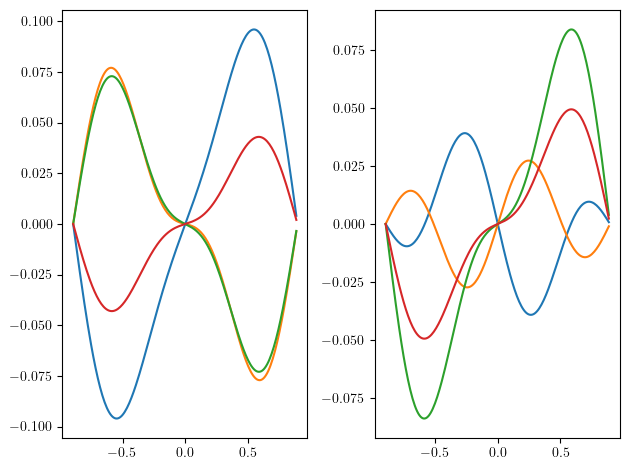

In [117]:
i,j=4,0
fig, ax = plt.subplots(ncols=2)
ax[0].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[0,4,0].real[0])
ax[1].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[1,4,0].real[1])

ax[0].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[0,4,1].real[0])
ax[1].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[1,1,4].real[1])

ax[0].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[0,5,2].real[0])
ax[1].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[1,5,2].real[1])

ax[0].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[0,5,3].real[0])
ax[1].plot(s.kxmesh[0], (mat1+mat2+mat3+mat4)[1,5,3].real[1])

tok = tokovi_drugic.j_tok(s.kymesh, s.kxmesh, a, b, b2, kinetic)

plt.tight_layout()
plt.show()


In [124]:
nu = 0
J1 = np.einsum('ijxy,jlxy,klxy->ikxy', s.vecs, tok[nu], s.vecs.conj())
J2 = np.einsum('ijxy,jlxy,klxy->ikxy', s.vecs, (mat1+mat2+mat3+mat4)[nu], s.vecs.conj())

Gamma = 0.01
omegas = np.linspace(-1,1,201)

phi = []
phiQ = []
for i, omega in enumerate(omegas):
    print(i)
    phi.append(tokovi_drugic.transportna_phi(s.kymesh, s.energije, J1, J1, s.mu, omega, Gamma))
    phiQ.append(tokovi_drugic.transportna_phi(s.kymesh, s.energije, J2, J1, s.mu, omega, Gamma))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


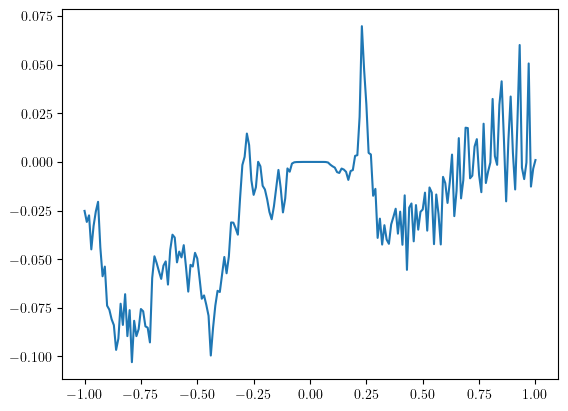

In [127]:
plt.plot(omegas, np.array(phiQ).real / s.Nk)


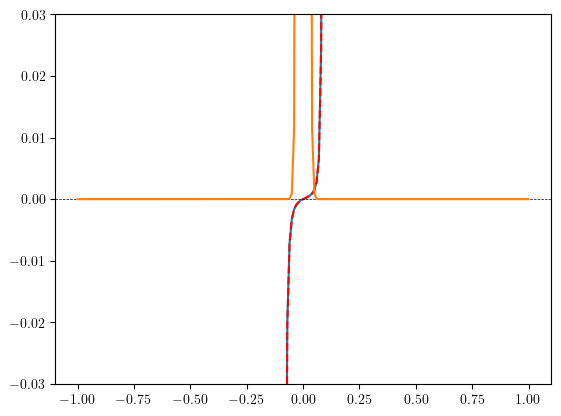

-1.0 -1.0 -1.0
2.6440673329510727 2.6042124373506095


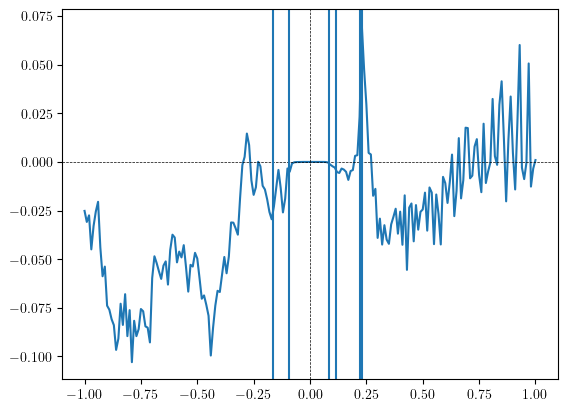

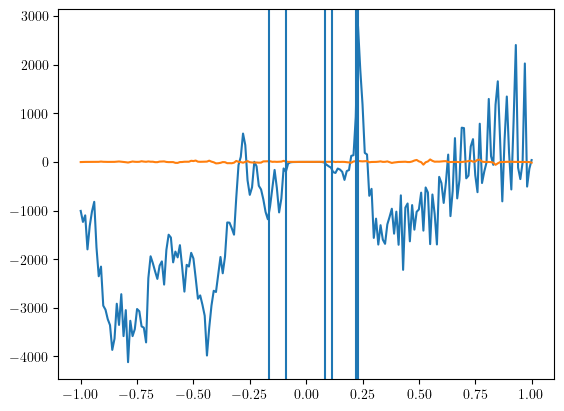

In [128]:
plt.plot(omegas, omegas * np.array(phi).real / s.Nk)
plt.plot(omegas, omegas * np.array(phi).real / s.Nk  + np.array(phiQ).real / s.Nk, color='red', ls='dashed')


plt.ylim(-0.03,0.03)
plt.axhline(0., color='black', ls='dashed', lw=0.5)
T = 1/250
plt.plot(omegas, -tokovi_drugic.fd_1(omegas, T))

K1b = np.sum((np.array(phiQ).real / s.Nk) * (-tokovi_drugic.fd_1(omegas, T)))
K1 = np.sum((omegas * np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
K0 = np.sum((np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))

betas = np.linspace(50,240,50)[::-1]
S, Sb = [],[]
for beta in betas:
    T = 1/beta
    K1b = np.sum((np.array(phiQ).real / s.Nk) * (-tokovi_drugic.fd_1(omegas, T))) #+ np.sum((np.array(phiQ_2).real / s.Nk) * (-tokovi_drugic.fd_1(omegas, T)))
    K1 = np.sum((omegas * np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
    K0 = np.sum((np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
    S.append(-K1/K0/T)
    Sb.append(-(K1 + K1b)/K0/T)


-K1b/K0/T, -K1/K0/T

K1b, K1, K1b + K1
plt.show()
plt.plot(omegas, np.array(phiQ).real / s.Nk)
plt.axvline(0, color='black', ls='dashed', lw=0.5)
plt.axhline(0, color='black', ls='dashed', lw=0.5)

print(np.sign(K1b), np.sign(K1), np.sign(K1b + K1))

plt.axvline(np.max(s.energije[1]) - s.mu)
plt.axvline(np.max(s.energije[0]) - s.mu)

plt.axvline(np.min(s.energije[2]) - s.mu)
plt.axvline(np.min(s.energije[3]) - s.mu)
plt.axvline(np.min(s.energije[4]) - s.mu)
plt.axvline(np.min(s.energije[5]) - s.mu)

print(-(K1b + K1)/K0/T, -K1/K0/T)
plt.show()
plt.plot(omegas, np.array(phiQ).real)
plt.plot(omegas, np.array(phiQ).imag)

plt.axvline(np.max(s.energije[1]) - s.mu)
plt.axvline(np.max(s.energije[0]) - s.mu)

plt.axvline(np.min(s.energije[2]) - s.mu)
plt.axvline(np.min(s.energije[3]) - s.mu)
plt.axvline(np.min(s.energije[4]) - s.mu)
plt.axvline(np.min(s.energije[5]) - s.mu)

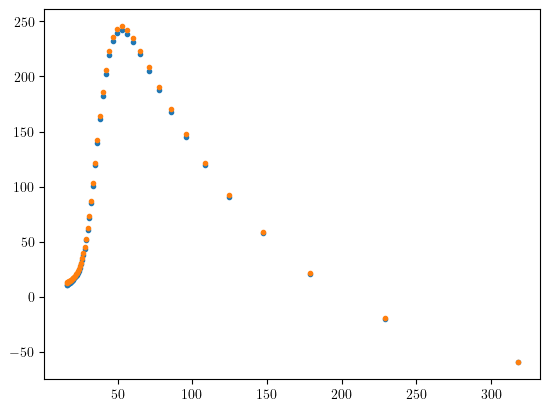

In [132]:
kb = 8.6 * 1e-5

plt.plot(1/np.array(betas) / kb * 328/1200, np.array(S) * kb * 1e6, '.')
plt.plot(1/np.array(betas) / kb * 328/1200, np.array(Sb) * kb * 1e6, '.')



-1.0 -1.0 -1.0


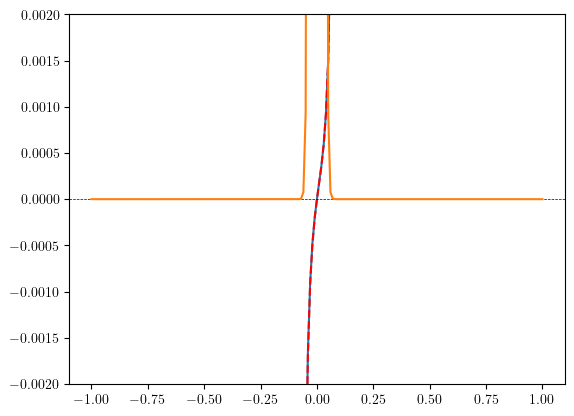

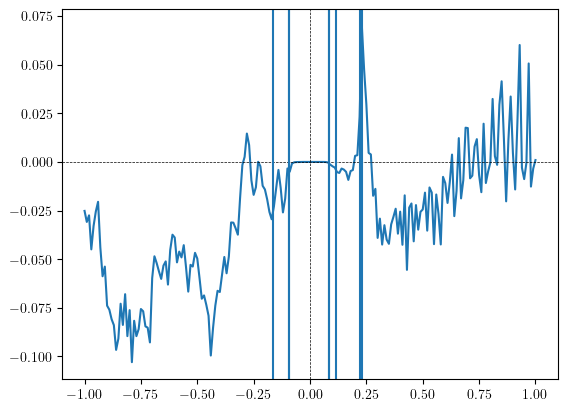

In [130]:
plt.plot(omegas, omegas * np.array(phi).real / s.Nk)
plt.plot(omegas, omegas * np.array(phi).real / s.Nk  + np.array(phiQ).real / s.Nk, color='red', ls='dashed')


plt.ylim(-0.002,0.002)
plt.axhline(0., color='black', ls='dashed', lw=0.5)
T = 1/250

betas = np.linspace(10,200,50)[::-1]
S, Sb = [],[]
for beta in betas:
    T = 1/beta
    K1b = np.sum((np.array(phiQ).real / s.Nk) * (-tokovi_drugic.fd_1(omegas, T)))
    K1 = np.sum((omegas * np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
    K0 = np.sum((np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
    S.append(-K1/K0/T)
    Sb.append(-(K1 + K1b)/K0/T)

T = 1/250

plt.plot(omegas, -tokovi_drugic.fd_1(omegas, T))

K1b = np.sum((np.array(phiQ).real / s.Nk) * (-tokovi_drugic.fd_1(omegas, T)))
K1 = np.sum((omegas * np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))
K0 = np.sum((np.array(phi).real / s.Nk ) * (-tokovi_drugic.fd_1(omegas, T)))

-K1b/K0/T, -K1/K0/T

K1b, K1, K1b + K1
print(np.sign(K1b), np.sign(K1), np.sign(K1b + K1))

plt.show()
plt.plot(omegas, np.array(phiQ).real / s.Nk)
plt.axvline(0, color='black', ls='dashed', lw=0.5)
plt.axhline(0, color='black', ls='dashed', lw=0.5)


plt.axvline(np.max(s.energije[1]) - s.mu)
plt.axvline(np.min(s.energije[2]) - s.mu)

plt.axvline(np.max(s.energije[1]) - s.mu)
plt.axvline(np.max(s.energije[0]) - s.mu)

plt.axvline(np.min(s.energije[2]) - s.mu)
plt.axvline(np.min(s.energije[3]) - s.mu)
plt.axvline(np.min(s.energije[4]) - s.mu)
plt.axvline(np.min(s.energije[5]) - s.mu)

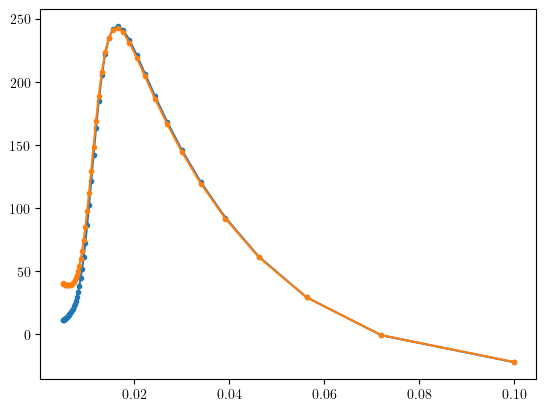

In [95]:
kb = 8.6 * 1e-5

plt.plot(1/np.array(betas), np.array(S) * kb * 1e6, '.-')
plt.plot(1/np.array(betas), np.array(Sb) * kb * 1e6, '.-')

In [4]:
kinetic = tokovi_drugic.kinetic()
pos = tokovi_drugic.positions(a, b, b2)
interaction = tokovi_drugic.interaction()

from numba import njit, prange


@njit(cache=True)
def spektralna_k(omega, mu, energije_k, Gamma):
    A = np.zeros((6,6), dtype=np.complex128)
    for i in range(6):
        A[i,i] = -1/np.pi * Gamma / ((omega - energije_k[i] + mu)**2 + Gamma**2)
    return A

''' df/domega, f je Fermi-Diracova porazdelitvena funkcija '''
@njit
def fd_1(omega, T):
    return -1/(4*T)/(np.exp(omega/(2*T)) + np.exp(-omega/(2*T)))**2 * 4

@njit(cache=True)
def helper_phi(omegas, j_tilde, energije, mu, Gamma):
    transportna = np.zeros((omegas.shape[0]), dtype=np.complex128)
    for q, omega in enumerate(omegas):
        A = spektralna_k(omega, mu, energije, Gamma)
        for nu in range(2):
            transportna[nu][q] += 2 * np.trace(j_tilde @ A @ j_tilde @ A)
    return transportna


@njit(parallel=True, cache=True)
def phi_ii3(Ky, Kx, rho, vecs, energije, pos, kinetic, interaction, tok, mu, omega, Gamma, a, b, b2):
    Ny, Nx = len(Ky), len(Kx)
    Nk = Ny * Nx
    suma_x = 0.0 + 0.0j
    suma_y = 0.0 + 0.0j
    for m in prange(Ny):
        for n in range(Nx//2 + 1):
            ky, kx = Ky[m], Kx[n]
            j_I = tokovi_drugic.create_jI(pos, a, b, kinetic, interaction, Nk, kx, ky, 0, 0)
            vec = vecs[:,:,m,n]
            tok_kx = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[0,:,:,m,n]) @ np.ascontiguousarray(vec).conj().T
            tok_ky = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[1,:,:,m,n]) @ np.ascontiguousarray(vec).conj().T

            tmp = np.zeros((2,6,6), dtype=np.complex128)
            for u in prange(Ny):
                for v in range(Nx):
                    for ii in range(6):
                        for jj in range(6):
                            g = np.array([rho[0,0,u,v], rho[1,1,u,v], rho[2,2,u,v], rho[3,3,u,v], rho[4,4,u,v], rho[5,5,u,v]])
                            tmp[0,ii,jj] += np.dot(j_I[0,ii,:,jj], g)
                            tmp[1,ii,jj] += np.dot(j_I[1,ii,:,jj], g)

            M_3x = vec @ tmp[0] @ vec.conj().T
            M_3y = vec @ tmp[1] @ vec.conj().T
            A = spektralna_k(omega, mu, energije[:,m,n], Gamma)
            mat_x = M_3x @ A @ tok_kx @ A
            mat_y = M_3y @ A @ tok_ky @ A

            if m in [0, Ny//2] or n in [0, Nx//2]:
                for orb in range(6):
                    suma_x += mat_x[orb,orb]
                    suma_y += mat_y[orb,orb]
            else:
                for orb in range(6):
                    suma_x += 2 * mat_x[orb,orb].real
                    suma_y += 2 * mat_y[orb,orb].real
    return suma_x / Nk, suma_y / Nk

@njit(parallel=True, cache=True)
def phi_ii5(Ky, Kx, rho, vecs, energije, pos, kinetic, interaction, tok, mu, omega, Gamma, a, b, b2):
    Ny, Nx = len(Ky), len(Kx)
    Nk = Ny * Nx
    suma_x = 0.0 + 0.0j
    suma_y = 0.0 + 0.0j
    M_5x = np.zeros(6, dtype=np.complex128)
    M_5y = np.zeros(6, dtype=np.complex128)
    for m in prange(Ny):
        for n in range(Nx//2 + 1):
            ky, kx = Ky[m], Kx[n]
            j_I = tokovi_drugic.create_jI(pos, a, b, kinetic, interaction, Nk, kx, ky, 0, 0)
            if m in [0, Ny//2] or n in [0, Nx//2]:
                for orb in range(6):
                    for alpha in range(6):
                        for beta in range(6):
                            M_5x[orb] += j_I[0,alpha,orb,beta] * rho[alpha,beta,m,n]
                            M_5y[orb] += j_I[1,alpha,orb,beta] * rho[alpha,beta,m,n]
            else:
                for orb in range(6):
                    for alpha in range(6):
                        for beta in range(6):
                            M_5x[orb] += 2 * (j_I[0,alpha,orb,beta] * rho[alpha,beta,m,n]).real
                            M_5y[orb] += 2 * (j_I[1,alpha,orb,beta] * rho[alpha,beta,m,n]).real 

    M_5x_new = np.zeros((6,6), dtype=np.complex128)
    M_5y_new = np.zeros((6,6), dtype=np.complex128)
    for orb in range(6):
        M_5x_new[orb,orb] = M_5x[orb]
        M_5y_new[orb,orb] = M_5y[orb]

    for m in prange(Ny):
        for n in range(Nx):
            vec = vecs[:,:,m,n]
            A = spektralna_k(omega, mu, energije[:,m,n], Gamma)
            tok_kx = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[0,:,:,m,n]) @ np.ascontiguousarray(vec).conj().T 
            tok_ky = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[1,:,:,m,n]) @ np.ascontiguousarray(vec).conj().T
            mat_5x = np.ascontiguousarray(vec) @ np.ascontiguousarray(M_5x_new) @ np.ascontiguousarray(vec).conj().T 
            mat_5y = np.ascontiguousarray(vec) @ np.ascontiguousarray(M_5y_new) @ np.ascontiguousarray(vec).conj().T 
            
            mat_x = mat_5x @ A @ tok_kx @ A
            mat_y = mat_5y @ A @ tok_ky @ A
            
            if m in [0, Ny//2] or n in [0, Nx//2]:
                for orb in range(6):
                    suma_x += mat_x[orb,orb]
                    suma_y += mat_y[orb,orb]
            else:
                for orb in range(6):
                    suma_x += 2 * mat_x[orb,orb].real
                    suma_y += 2 * mat_y[orb,orb].real
    return suma_x / Nk, suma_y / Nk

njit(parallel=True, cache=True)
def transportna_phi(Kymesh, vecs, energije, tok, mu, omega, Gamma):
    Ny, Nx = len(Kymesh[:,0]), len(Kymesh[0])
    Nk = Ny * Nx
    transportna = np.zeros(2, dtype=np.complex128)

    for n in range(Nx):
        for ind in [0, Ny//2]:
            vec = vecs[:,:,ind,n]
            A = np.zeros((6,6), dtype=np.complex128)
            for i in range(6):
                A[i,i] = -1/np.pi * Gamma / ((omega - energije[i,ind,n] + mu)**2 + Gamma**2)
            for nu in range(2):
                tok_k = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[nu,:,:,ind,n]) @ np.ascontiguousarray(vec).conj().T
                transportna[nu] += np.trace(tok_k @ A @ tok_k @ A)

    for m in range(Ny):
        for ind in [0, Nx//2]:
            vec = vecs[:,:,m,ind]
            A = np.zeros((6,6), dtype=np.complex128)
            for i in range(6):
                A[i,i] = -1/np.pi * Gamma / ((omega - energije[i,m,ind] + mu)**2 + Gamma**2)
            for nu in range(2):
                tok_k = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[nu,:,:,m,ind]) @ np.ascontiguousarray(vec).conj().T
                transportna[nu] += np.trace(tok_k @ A @ tok_k @ A)

    for m in range(1,Ny):
        if m == Ny//2: pass
        for n in range(1,Nx//2):
            vec = vecs[:,:,m,n]
            A = np.zeros((6,6), dtype=np.complex128)
            for i in range(6):
                A[i,i] = -1/np.pi * Gamma / ((omega - energije[i,m,n] + mu)**2 + Gamma**2)
            for nu in range(2):
                tok_k = np.ascontiguousarray(vec) @ np.ascontiguousarray(tok[nu,:,:,m,n]) @ np.ascontiguousarray(vec).conj().T
                transportna[nu] += 2 * np.trace(tok_k @ A @ tok_k @ A).real
    return transportna / Nk

@njit(parallel=True, cache=True)
def phi_ii4(Ky, Kx, rho, vecs, energije, pos, kinetic, interaction, tok, mu, omega, Gamma, a, b, b2):
    Ny, Nx = len(Ky), len(Kx)
    Nk = Ny * Nx
    suma_x = 0.0 + 0.0j
    suma_y = 0.0 + 0.0j
    for m in prange(Ny):
        for n in prange(Nx):
            ky, kx = Ky[m], Kx[n]
            local_sum = 0.0 + 0.0j
            


In [ ]:
phi_ii3(s.kymesh[:,0], s.kxmesh[0], s.rho, s.vecs, s.energije, pos, kinetic, interaction, tok, s.mu, 1, Gamma, a, b, b2)

C:\Users\anast\AppData\Local\Temp\ipykernel_34776\1251725695.py:53: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 2, 'A', False, aligned=True), Array(complex128, 2, 'C', False, aligned=True))
  M_3x = vec @ tmp[0] @ vec.conj().T


In [158]:
phix, phiy = [],[]

Gamma = 0.03
omegas = np.linspace(-1,1,200)
for i in range(len(omegas)):

    print(i)
    z = transportna_phi(s.kymesh, s.vecs, s.energije, tok, s.mu, omegas[i], Gamma)
    phix.append(z[0].real)
    phiy.append(z[1].real)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


0.05
0.03475177304964539
0.026630434782608695
0.021585903083700442
0.01814814814814815
0.015654952076677317
0.013764044943820226
0.012280701754385967
0.011085972850678734
0.010103092783505156
0.009280303030303031
0.008581436077057794
0.007980456026058633
0.007458143074581432
0.007000000000000001
0.006594885598923284
0.0062340966921119595
0.005910735826296743
0.005619266055045872
0.005355191256830601
0.00511482254697286
0.0048951048951048955
0.004693486590038314
0.004507819687212512
0.004336283185840708
0.0041773231031543056
0.004029605263157895
0.0038919777601270846
0.0037634408602150544
0.0036431226765799257
0.0035302593659942362
0.0034241788958770092
0.003324287652645862
0.0032300593276203033
0.0031410256410256414
0.0030567685589519655
0.0029769137302551644
0.0029011249259917114
0.0028290993071593534
0.00276056338028169
0.002695269526952695
0.002632993014508329
0.002573529411764706
0.002516692347200822
0.002462311557788945
0.002410231185440236
0.002360308285163777
0.00231241151486550

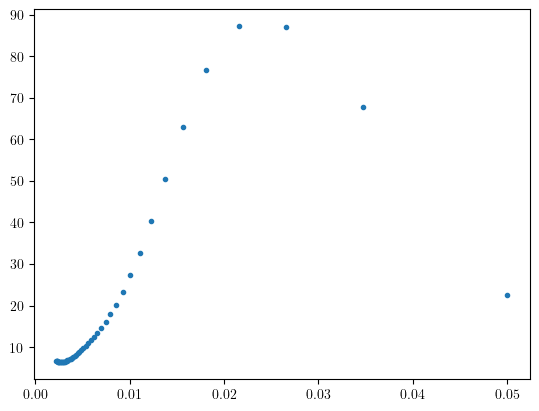

In [170]:
betas = np.linspace(20,450,50)
Ts = 1/betas
Gamma = 0.01
eps = 1e-6
Sx, Sy = [], []
    

for T in Ts:
    print(T)
    K1x = np.sum(omegas * phix * (-fd_1(omegas, T)))
    K0x = np.sum(phix * (-fd_1(omegas, T)))

    K1y = np.sum(omegas * phiy * (-fd_1(omegas, T)))
    K0y = np.sum(phiy * (-fd_1(omegas, T)))

    Sx.append(-K1x/K0x / T), Sy.append(-K1y/K0y / T)
kb = 8.617 * 1e-5

plt.plot(Ts, np.array(Sx) * kb  * 1e6, '.')
#plt.plot(betas, Sy)

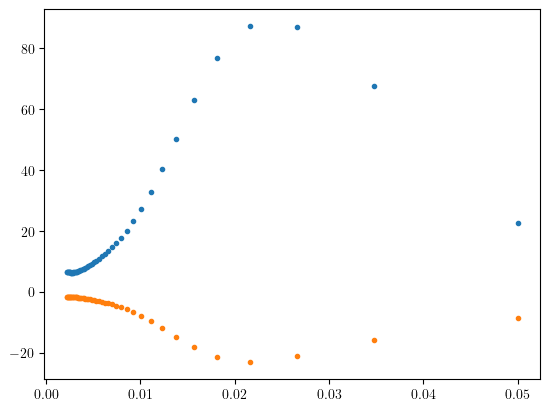

In [174]:
plt.plot(Ts, np.array(Sx) * kb  * 1e6, '.')
plt.plot(Ts, np.array(Sy) * kb  * 1e6, '.')

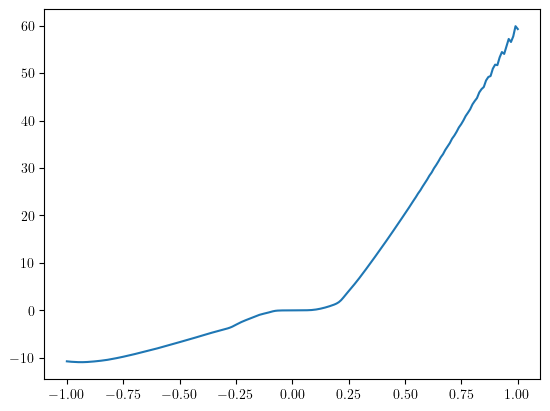

(1694.8917543576467, 2.9425959025277137)

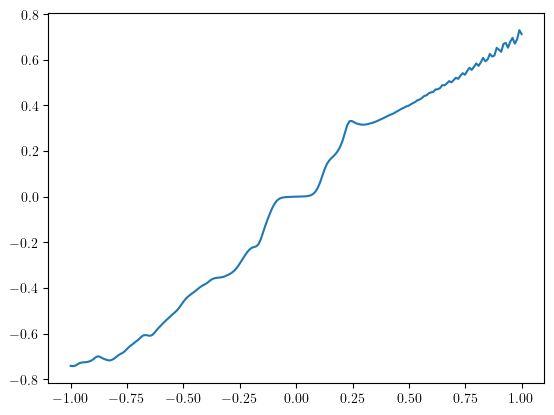

In [186]:
plt.plot(omegas, omegas * phix)
plt.show()
plt.plot(omegas, omegas * np.array(phiy) )

np.sum(omegas * phix), np.sum(omegas * phiy - 3 *  omegas**3 * phiy)

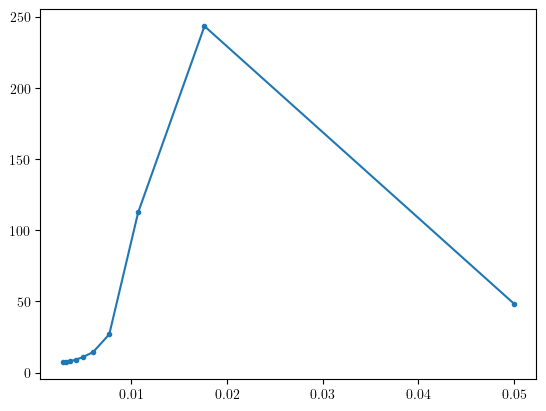

In [143]:
plt.plot(Ts, np.array(Sx) * kb * 1e6, '.-')

In [93]:
phi_ii5(s.kymesh[:,0], s.kxmesh[0], s.rho, s.vecs, s.energije, pos, kinetic, interaction, tok, s.mu, 0.05, Gamma, a, b, b2)

((8.819632343114739e-07-2.0587890264568461e-07j),
 (3.390559947491725e-06-6.993595404233079e-07j))

0.11205840110778809
0.021260738372802734
0.016686201095581055
0.019669532775878906
0.018512487411499023
0.016153335571289062
0.01611495018005371
0.017239093780517578
0.013628482818603516
0.009822845458984375


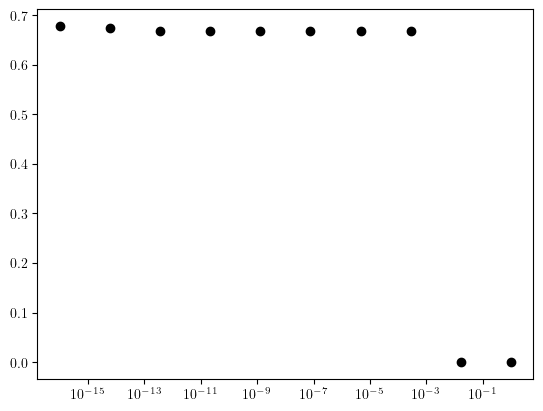

In [208]:
eps = np.logspace(-16,0,10)

for j, ep in enumerate(eps):
    start = time.time()
    for g in range(10):
        lef = transportna_phi(s.kymesh, s.vecs, s.energije, tok, s.mu, 1, Gamma, eps=ep, T=1/120)
    #plt.scatter(ep, lef[1] / s.Nk)
    plt.scatter(ep, lef[0][0].real, color='black')
    #plt.scatter(ep, lef[0][1].real, color='blue')
    print(time.time() - start)
plt.xscale('log')


In [77]:
spektralna_k(2, s.mu, s.energije[:,3,5], Gamma)

array([[-0.00355114+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j, -0.00360695+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, -0.39552069+0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.39368165+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j, -0.30700044+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j, -0.28222564+0.j]])

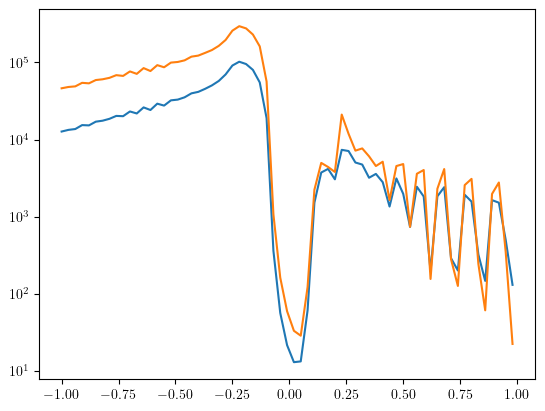

In [ ]:
omega_max = 1
domega = 0.03
omegas = np.arange(-omega_max, omega_max, domega)

phi = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, omegas, Gamma)
phi_K = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, mu, omegas, Gamma=0.01)



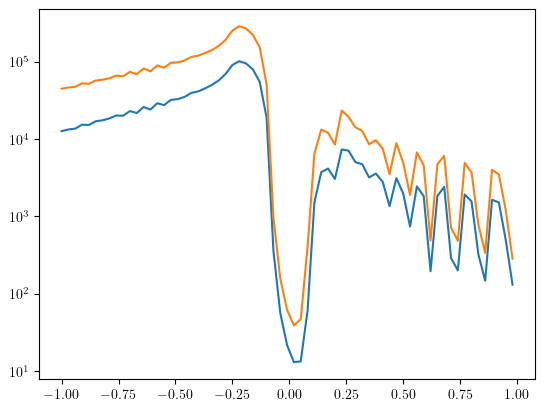

In [128]:

plt.plot(omegas, phi[0][1])
plt.plot(omegas, -phi_K[0][1].real)

plt.yscale('symlog')

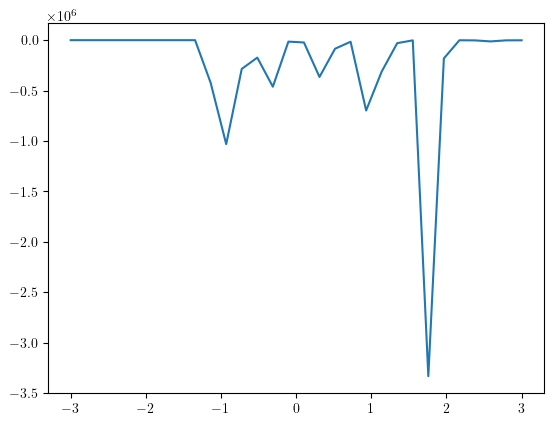

In [ ]:
omegas = np.linspace(-3,3,30)
phi_K = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, mu, omegas, Gamma=0.01)[0].real


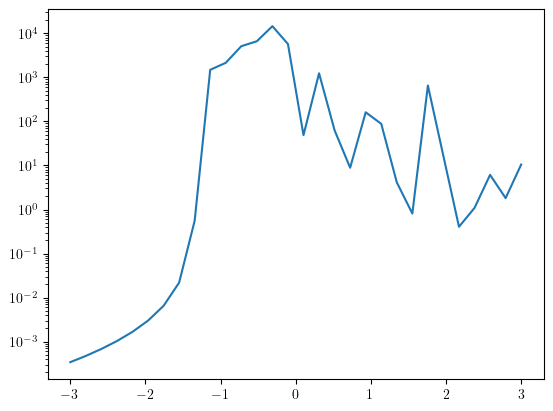

In [46]:
plt.plot(omegas, phi[1])
plt.yscale('log')

In [29]:
np.save('vecs.npy', s.vecs)
np.save('energije.npy', s.energije)
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

s.reset_infty()
np.save('energije0.npy', s.energije)


C:\Users\anast\AppData\Local\Temp\ipykernel_43520\3751847136.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


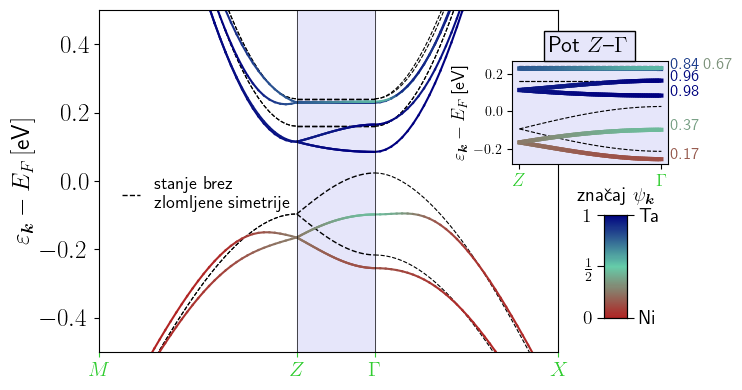

In [44]:
fig, ax = plt.subplots(figsize=(8,4), facecolor='white')
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
energije = np.load('energije.npy')
mu = 0.5 * (np.min(energije[2]) + np.max(energije[1]))
barve = np.einsum('ijkl->jkl', np.abs(np.load('vecs.npy')[:4, :, :, :])**2) #

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")
energije0 = np.load('energije0.npy')

col1, col2, col3 = 'firebrick', 'mediumaquamarine', 'navy'
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

# Gamma - X
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + (Ny//2-1)*2*np.pi/b + np.arange(Nx//2)*2*np.pi/a
    E = energije[i, Ny//2, Nx//2:]
    E0 = energije0[i, Ny//2, Nx//2:]
    for g in range(0,len(K)-1):
        col = np.mean(barve[i, Ny//2, Nx//2:][g:g+2])
        if col <= 0.5:
            barva = colorFader(col1, col2, col*2)
        else:
            barva = colorFader(col2, col3, 2*col - 1)
        plt.plot(K[g:g+2], E[g:g+2]- s.mu, color=barva)
    plt.plot(K, E0 - s.mu, color='black', lw=0.8, zorder=-100, ls='dashed')

# Z - Gamma
E_c, E_v = np.max(energije[:Ny//2, Nx//2]), np.min(energije[:Ny//2, Nx//2])
gap = E_c - E_v
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + np.arange(Ny//2)*2*np.pi/b
    E = energije[i, :Ny//2, Nx//2]
    E0 = energije0[i, :Ny//2, Nx//2]
    for g in range(0,len(K)-1):#)len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])
        if col <= 0.5:
            barva = colorFader(col1, col2, col*2)
        else:
            barva = colorFader(col2, col3, 2*col - 1)
        plt.plot(K[g:g+2], E[g:g+2]- s.mu, color=barva)
    if i == 0: lab ='stanje brez' + '\n' + 'zlomljene simetrije'
    else: lab  =''
    plt.plot(K, E0 - s.mu, color='black', lw=1, zorder=-100, ls='dashed',label=lab)
# Z - M
for i in range(6):
    K = np.arange(Nx//2)*2*np.pi/a
    E = energije[i, 0, Nx//2:][::-1]
    E0 = energije0[i, 0, Nx//2:][::-1]
    for g in range(0,len(K)-1):
        col = np.mean(barve[i, 0, Nx//2:][::-1][g:g+2])
        if col <= 0.5:
            barva = colorFader(col1, col2, col*2)
        else:
            barva = colorFader(col2, col3, 2*col - 1)
        plt.plot(K[g:g+2], E[g:g+2] - s.mu, color=barva)
    plt.plot(K, E0 - s.mu, color='black', lw=0.8, zorder=-100, ls='dashed')

ax.set_xticks([50, (Nx//2 -1)*2*np.pi/a, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b, 200],)#(Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a],)# color='magenta')
ax.set_xticklabels(['$M$', '$Z$', r'$\Gamma$', '$X$'])

ax.set_xlim([0, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a])
ax.tick_params(axis='x', colors='limegreen')

plt.axvline((Nx//2 -1)*2*np.pi/a, lw=0.5, color='black')
plt.axvline((Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b, lw=0.5, color='black')

plt.xticks(fontsize=15), plt.yticks(fontsize=18)
plt.ylabel(r'$\varepsilon_{\bm{k}} - E_F\,[\text{eV}]$', fontsize=18)


ins = ax.inset_axes([0.9,0.55,0.34,0.3])
# Z - Gamma
E_c, E_v = np.max(energije[:Ny//2, Nx//2]), np.min(energije[:Ny//2, Nx//2])
gap = E_c - E_v
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + np.arange(Ny//2)*2*np.pi/b
    E = energije[i, :Ny//2, Nx//2]
    m = np.mean(barve[i, :Ny//2, Nx//2])
    if m <= 0.5:
        barva = colorFader(col1, col2, m*2)
    else:
        barva = colorFader(col2, col3, 2*m - 1)
    if i != 5: ins.text(K[-1]+1.6, E[-1] - s.mu, f'{np.round(m,2)}', color=barva, fontsize=12)
    else: ins.text(K[-1]+5.8, energije[-2, :Ny//2, Nx//2][-1] - s.mu, f', {np.round(m,2)}', color=colorFader(col1, col2, m), fontsize=12)
    for g in range(0,len(K)-1):#)len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])

        if col <= 0.5:
            barva = colorFader(col1, col2, col*2)
        else:
            barva = colorFader(col2, col3, 2*col - 1)

        ins.plot(K[g:g+2], E[g:g+2]- s.mu, color=barva, lw=3)
    E0 = energije0[i, :Ny//2, Nx//2]
    ins.plot(K, E0 - mu, color='black', lw=0.8, zorder=-10, ls='dashed')

#plt.title(r'Pasovna struktura vzdolž poti $M$--$Z$--$\Gamma$--$X$', fontsize=16)

ins2 = ax.inset_axes([1.1,0.1,0.05,0.3])
for n in range(101):
    if n/100 <= 0.5:
        barva = colorFader(col1, col2, 2*n/100)
    else:
        barva = colorFader(col2, col3, 2*n/100 - 1)
    ins2.axhspan(n/99, (n+1)/99, 0, 1, color=barva)
ins2.set_xticks([]), ins2.set_ylim(0,1)
ins2.set_yticks([0,0.5,1])

ins2.tick_params(axis='y', size=5)
ins2.set_yticklabels(['$0$', r'$\frac{1}{2}$', '$1$'],fontsize=14)

ins2_ = ins2.twinx()
ins2_.set_yticks([0,1])
ins2_.tick_params(axis='y', size=5)
ins2_.set_yticklabels(['Ni', 'Ta'],fontsize=14)
ins.set_xticks([(Nx//2-1)*2*np.pi/a, (Nx//2-1)*2*np.pi/a +(Ny//2-1)*2*np.pi/b])
ins.set_xticklabels(['$Z$', r'$\Gamma$'], color='limegreen', fontsize=13)
ins.set_facecolor('lavender')
ax.axvspan((Nx//2-1)*2*np.pi/a, (Nx//2-1)*2*np.pi/a +(Ny//2-1)*2*np.pi/b, color='lavender', zorder=-10000)
ins.set_ylabel(r'$\varepsilon_{\bm{k}} - E_F\,\text{[eV]}$', fontsize=13)
#ins.set_title(r'Pot $Z$--$\Gamma$', backgroundcolor='lavender',fontsize=14, pad=12)
ins.text(120, 0.32, r'Pot $Z$--$\Gamma$', color='black',  fontsize=16,
        bbox=dict(facecolor='lavender', edgecolor='black', pad=4.0, linewidth=1))

ax.set_ylim(-0.5,0.5)
ax.set_xlim(50,200)
ax.legend(handlelength=1, frameon=False, bbox_to_anchor=(0.45,0.46), fontsize=13)

ins2.set_title(r'značaj $\psi_{\bm{k}}$', pad=10, fontsize=14)
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
plt.savefig('pot.png')

IndexError: list index out of range

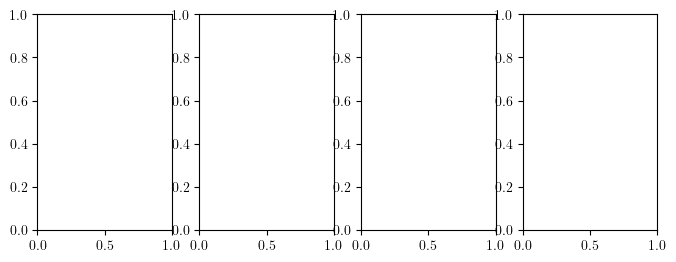

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(8,2.8))

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

energije = [np.load('energije_gs.npy')]
barve = [np.einsum('ijkl->jkl', np.abs(np.load('U_gs.npy')[:4, :, :, :])**2)]
for t in [12,10,9]:
    energije.append(np.load(f'energije_{t}.npy'))
    barve.append(np.einsum('ijkl->jkl', np.abs(np.load(f'U_{t}.npy')[:4, :, :, :])**2))
Ts = np.hstack([[0], s.Ts[2:]])
Tc = 1/9.6
phi0 = 0.14766544
phis = np.hstack([[phi0], s.phis[2:]])
colors = ['royalblue', 'orangered', 'mediumseagreen', 'gold']
colors2 = ['darkviolet', 'deepskyblue', 'tomato', 'limegreen']
cols = sns.color_palette("managua", len(energije))
mus = [2.84]
for j in range(len(energije)):
    mus.append(s.mus[j])
# Gamma - X
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + (Ny//2-1)*2*np.pi/b + np.arange(Nx//2)*2*np.pi/a
    for j in range(len(energije)):
        E = energije[j][i, Ny//2, Nx//2:]
        ax[j].plot(K, E - mus[j], color=cols[j],lw=1.5)

# Z - Gamma
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + np.arange(Ny//2)*2*np.pi/b
    for j in range(len(energije)):
        E = energije[j][i, :Ny//2, Nx//2]
        ax[j].plot(K, E - mus[j], color=cols[j],lw=1.5)

# Z - M
for i in range(6):
    K = np.arange(Nx//2)*2*np.pi/a
    for j in range(len(energije)):
        E = energije[j][i, 0, Nx//2:][::-1]
        ax[j].plot(K, E - mus[j], color=cols[j],lw=1.5)

for j in range(len(energije)):
    ax[j].set_xticks([0, (Nx//2 -1)*2*np.pi/a, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a],)# color='magenta')
    ax[j].set_xticklabels(['$M$', '$Z$', r'$\Gamma$', '$X$'], fontsize=12)
    ax[j].set_xlim([0, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a])
    ax[j].tick_params(axis='x', colors='magenta')
    ax[j].set_xlim(30,65)
    ax[j].set_ylim(-0.3,0.3)
ax[0].set_ylabel(r'$\varepsilon_{\bm{k}} - \mu\,[\text{eV}]$', fontsize=16)

#ins = ax.inset_axes([0.8,0.4,0.4,0.4])
gaps = []
for j in range(len(energije)):
    gaps.append(np.min(energije[j][2,:,:]) - np.max(energije[j][1,:,:]))
    #if j < 4: ax[j].annotate("", (65,np.min(energije[j][2,Ny//2, Nx//2:]) - mus[j]), (65, np.max(energije[j][1,Ny//2, Nx//2:])- mus[j]), arrowprops={'arrowstyle':'<->', 'shrinkA': 0, 'shrinkB': 0,'color':'grey'})
ax[0].set_title(r'a) $\frac{\phi_0}{\phi_0(T=0)}=$' + rf'${np.round(phis[0] / phis[0], 2)}$', fontsize=15, pad=10)
ax[1].set_title(r'b) $\frac{\phi_0}{\phi_0(T=0)}=$' + rf'${np.round(phis[1] / phis[0], 2)}$', fontsize=15, pad=10)
ax[2].set_title(r'c) $\frac{\phi_0}{\phi_0(T=0)}=$' + rf'${np.round(phis[2] / phis[0], 2)}$', fontsize=15, pad=10)
ax[3].set_title(r'd) $\frac{\phi_0}{\phi_0(T=0)}=$' + rf'${np.round(phis[3] / phis[0], 3)}$', fontsize=15, pad=10)

plt.tight_layout()
#plt.savefig('pot.png')
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
#plt.savefig('razvoji.png')


In [85]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")
dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Gamma = 0.01
Ny, Nx = 130, 130
mu = 2.84
eps0 = 0.1
s = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2, eps0)
beta0 = 350
scale = 1.02
betas = np.linspace(340,350,1)[::-1]
ends = [int(np.emath.logn(scale, beta0/beta)) for beta in betas]
Ts = 1/betas

omega_max, domega = 0.5, 0.0005

'''for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    s.reset(mu)
    set_betas = beta0/scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s.run(set_Ts, Gamma, domega,)# transportB='evaluate')
    if len(s.phis) > 1: print(s.phis[-1])'''

#np.save('energije.npy', s.energije)
#np.save('vecy.npy', s.vecs)

#s.reset_infty()


Found ground state with error=7.721601136267964e-11, occupation error=4.440892098500626e-16


"for i, T in enumerate(Ts):\n    print(1/T)\n    print('-------------')\n    s.reset(mu)\n    set_betas = beta0/scale**np.arange(ends[i])\n    set_Ts = 1/set_betas\n    s.run(set_Ts, Gamma, domega,)# transportB='evaluate')\n    if len(s.phis) > 1: print(s.phis[-1])"

In [22]:
np.save('energije0.npy', s.energije)

In [38]:
omegas = np.linspace(-0.5,0.5,100)
phi, jnew = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, mu, omegas, Gamma=0.01)
phiB, jx, jy = tokovi_drugic.transportna_phi_Boltzmann(s.kymesh, s.kxmesh, s.energije, mu, omega_max=0.5, domega=omegas[1] - omegas[0], faktor=0.1)

(10.0, 100000000.0)

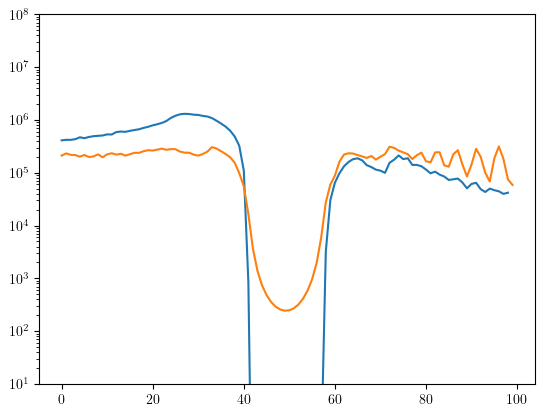

In [41]:
plt.plot(phiB[1].real / (2*Gamma))
plt.plot(phi[1].real * np.pi)
plt.yscale('log')
plt.ylim(1e1,1e8)

<Axes: >

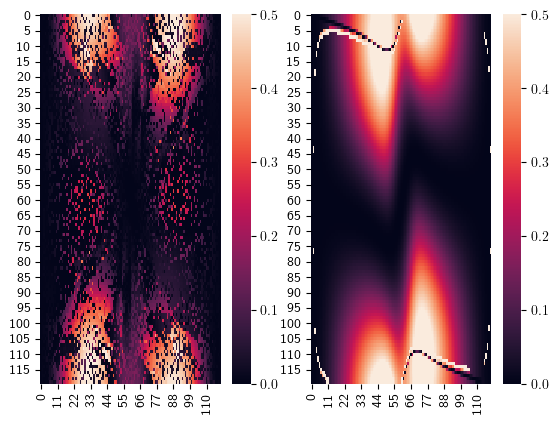

In [30]:
fig, ax = plt.subplots(ncols=2)
sns.heatmap(jnew[1,1,1].real**2, ax=ax[0], vmin=0, vmax=0.5)
sns.heatmap(np.hstack([jy[1].real])**2, ax=ax[1], vmin=0, vmax=0.5)


<Axes: >

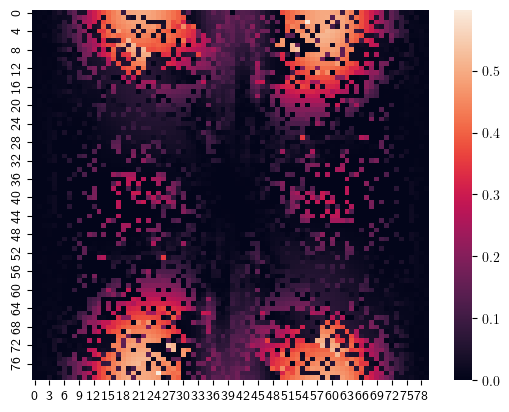

In [71]:
sns.heatmap(jnew[1,1,1].real**2,)


<Axes: >

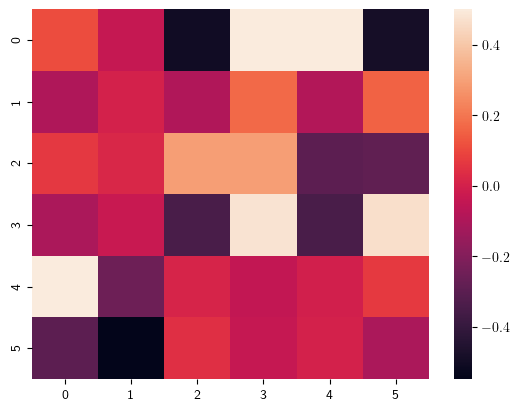

In [ ]:
u=s.vecs[:,:,i,j] @ s.j_matrix[1,:,:,i,j] @ s.vecs[:,:,i,j].conj().T

s.f

In [60]:
_, jx, jy = tokovi_drugic.transportna_phi_Boltzmann(s.kymesh, s.kxmesh, s.energije, s.mu, omega_max=1, domega=0.01, faktor=1)

<Axes: >

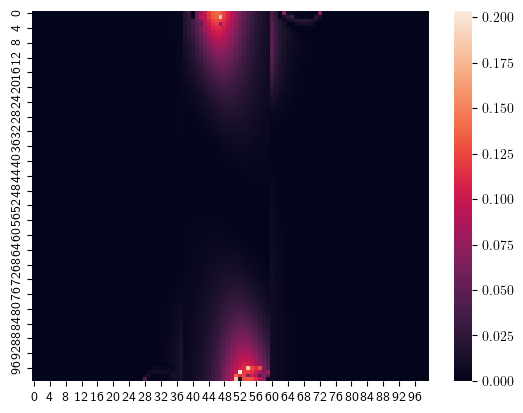

In [134]:
sns.heatmap(jy[2].real**2)

In [7]:
energije, vecs, fs = helpers.H_diagonalize(Ny, Nx, s.hop, s.perturb, s.hartree, s.fock, 0, mu, 1e-5)
energije_, vecs_, fs_ = helpers.H_diagonalize2(Ny, Nx, s.hop, s.perturb, s.hartree, s.fock, 0, mu, 1e-5)

In [14]:
for j in range(Nx):
    for m in range(Ny):
        if np.max(np.abs(energije_[:,j,m] - energije[:,j,m])) > 1e-14: print(j,m)

np.allclose(fs, fs_)

True

In [98]:
np.allclose(s.vecs[:,:,1,1].imag, s.vecs[:,:,-1,-1].imag)

np.allclose(s.vecs[:,:,1,1] @ np.diag(s.energije[:,1,1]) @ s.vecs[:,:,1,1].conj().T,
            (s.vecs[:,:,1,1].conj() @ np.diag(s.energije[:,-1,-1]) @ (s.vecs[:,:,1,1].conj()).conj().T).conj())



True

In [100]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

mu = 0.5*(np.min(s.energije[2]) + np.max(s.energije[1]))
s = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2, eps0)


Found ground state with error=7.721601136267964e-11, occupation error=4.440892098500626e-16


0.17620385332623867

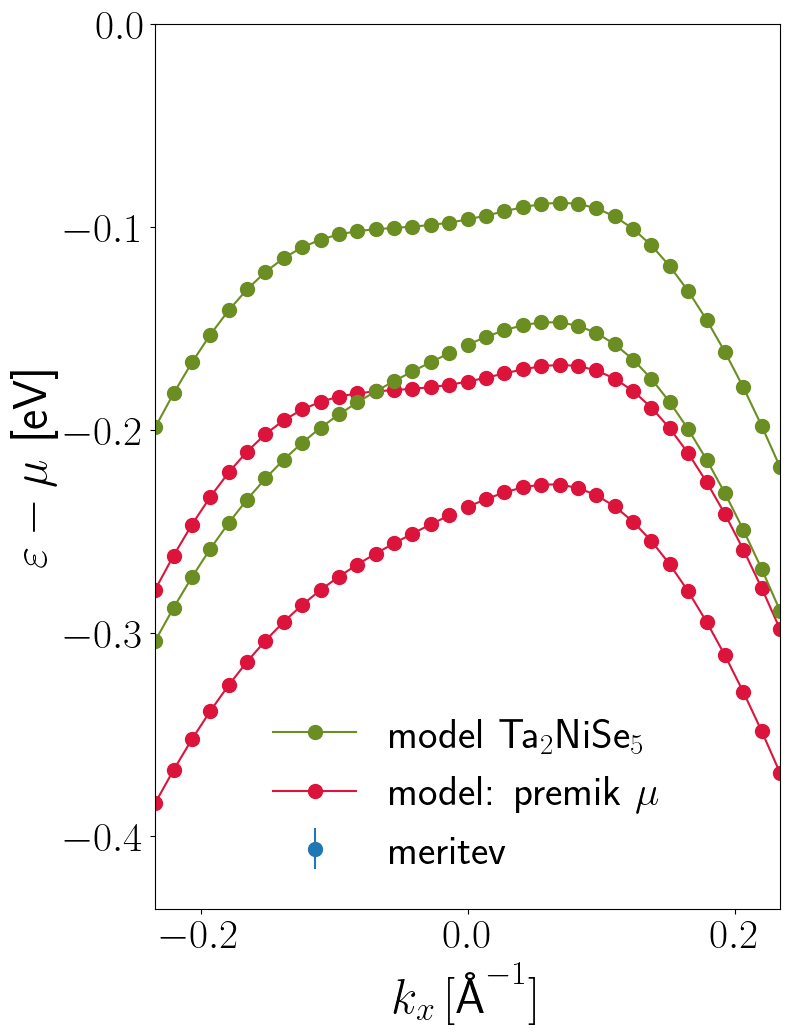

In [177]:
K = s.kxmesh[0]

ratio = 362.685 / 277.76
fig, ax = plt.subplots(figsize=(8, ratio*8))
ri, ci = s.energije[1].argmax()//s.energije[1].shape[1], s.energije[1].argmax()%s.energije[1].shape[1]

njihov_vrh = 0.42 * 0.4
#plt.plot(K, s.energije[1, ci, :] - s.mu , '.-', ms=20, color='olivedrab', label=r'model \ce{Ta2NiSe5}')
plt.plot(K, s.energije[1, -ri, :][::-1] - s.mu , '.-', ms=20, color='olivedrab', label=r'model $\text{Ta}_2 \text{Ni}\text{Se}_5$')
plt.plot(K, s.energije[1, -ri, :][::-1] - s.mu - np.max(s.energije[1, ri, :] - s.mu) - njihov_vrh , '.-', ms=20, color='crimson',
        label='model: premik $\mu$')

plt.ylim(-1.09 * 0.4, 0)
k_min = 0.4 * 1.17 / 2 

plt.errorbar([10],[10], fmt='o', ms=10, yerr=[1], label=r'meritev')

plt.xlim(-k_min, k_min)
plt.legend(frameon=False, fontsize=30, loc='lower center')
plt.xlabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=35)
plt.ylabel(r'$\varepsilon - \mu\,\,\text{[eV]}$', fontsize=35)
plt.xticks([-0.2,0,0.2], fontsize=30)
plt.yticks([0,-0.1,-0.2,-0.3,-0.4], fontsize=30)
K[ci], s.kxmesh[0][ri]


Ny, Nx = s.kymesh.shape
ri2, ci2 = s.energije[0].argmax()//s.energije[1].shape[1], s.energije[0].argmax()%s.energije[1].shape[1]

njihov_vrh = 0.42 * 0.4
#plt.plot(K, s.energije[0, ri, :] - s.mu , '.-', ms=20, color='olivedrab', label=r'model \ce{Ta2NiSe5}')
plt.plot(K[:len(K)//2], s.energije[0, ri2, :][::-1][:len(K)//2] - s.mu , '.-', ms=20, color='olivedrab', label=r'model $\text{Ta}_2 \text{Ni}\text{Se}_5$')
plt.plot(K[len(K)//2:], s.energije[1, ri2, :][::-1][len(K)//2:] - s.mu , '.-', ms=20, color='olivedrab', label=r'model $\text{Ta}_2 \text{Ni}\text{Se}_5$')

plt.plot(K[:len(K)//2], s.energije[0, ri2, :][::-1][:len(K)//2] - s.mu- np.max(s.energije[1, ri, :] - s.mu) - njihov_vrh , '.-', ms=20, color='crimson', label=r'model $\text{Ta}_2 \text{Ni}\text{Se}_5$')
plt.plot(K[len(K)//2:], s.energije[1, ri2, :][::-1][len(K)//2:] - s.mu - np.max(s.energije[1, ri, :] - s.mu) - njihov_vrh, '.-', ms=20, color='crimson', label=r'model $\text{Ta}_2 \text{Ni}\text{Se}_5$')


plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")



np.min(s.energije[2]) - np.max(s.energije[1])

3.2372804417059835 [[0.03597863]]


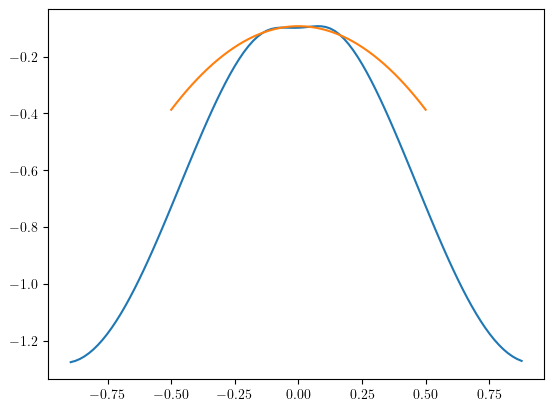

In [171]:

plt.plot(s.kxmesh[0], s.energije[1,46,:] - s.mu)

parabola1 = s.energije[1,46] - s.mu

from scipy.optimize import curve_fit
def func(x, m):
    return -x**2/(2*m)
popt, pcov = curve_fit(func, s.kxmesh[0][40:60], parabola1[40:60] - np.max(parabola1))
faktor = 1973**2/(0.511 * 1e6)
masa2_y = popt[0] * faktor
print(masa2_y, pcov**0.5)

kji = np.linspace(-0.5,0.5)
plt.plot(kji, func(kji, popt[0]) + np.max(s.energije[1,46,:] - s.mu))

In [1]:
eps = 1e-6
omega_max = 1#np.sqrt(np.abs(np.arccosh(1/(eps*4*T))) * 2 * T)
domega = 0.005
Gamma = 0.01
omegas = np.arange(-omega_max, omega_max, domega)
phi_B = tokovi_drugic.transportna_phi_Boltzmann(s.kymesh, s.kxmesh, s.energije, s.mu, omega_max, domega, faktor=1)
phi_K = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma, omega_max, domega)

NameError: name 'np' is not defined

In [1073]:
Ny, Nx = s.kymesh.shape
energije_new = np.copy(energije)
''' rearrange energies to get bands'''
'''energije_new = np.copy(energije)
energije_new[0,0,Nx//2:] = energije[1,0,Nx//2:]
energije_new[1,0,Nx//2:] = energije[0,0,Nx//2:]

energije_new[2,0,Nx//2:] = energije[3,0,Nx//2:]
energije_new[3,0,Nx//2:] = energije[2,0,Nx//2:]

energije_new[4,0,Nx//2:] = energije[5,0,Nx//2:]
energije_new[5,0,Nx//2:] = energije[4,0,Nx//2:]'''

maksimumi_y, maksimumi_x = [], []
dKy, dKx = np.diff(s.kymesh[:,0])[0], np.diff(s.kxmesh[0])[0]

velocity_y, velocity_x = np.zeros(energije.shape), np.zeros(energije.shape)
for i in range(6):
    gr = np.gradient(energije[i])
    velocity_y[i, :, :], velocity_x[i, :, :] = gr[0]/dKy, gr[1]/dKx
    maksimumi_y.append(np.max(np.abs(velocity_y[i,:,:])))
    maksimumi_x.append(np.max(np.abs(velocity_x[i,:,:])))

omegas = np.arange(-omega_max, omega_max, domega)
transportna = np.zeros((2, omegas.shape[0]))

v_max = np.array([np.max(maksimumi_y), np.max(maksimumi_x)])
faktor=1
sigma = faktor * np.array([np.sqrt(v_max[0] * domega * dKy), np.sqrt(v_max[1] * domega * dKx)])

for i in range(Ny):
    for j in range(Nx):
        for m in range(6):
            ''' factor 2 is for spin degeneracy '''
            transportna[0] += 2 * 1/(2*np.pi*sigma[0]**2)**0.5 * np.exp(-(omegas - energije_new[m,i,j] + mu)**2/(2*sigma[0]**2)) * velocity_y[m,i,j]**2
            transportna[1] += 2 * 1/(2*np.pi*sigma[1]**2)**0.5 * np.exp(-(omegas - energije_new[m,i,j] + mu)**2/(2*sigma[1]**2)) * velocity_x[m,i,j]**2


(10.0, 1000000.0)

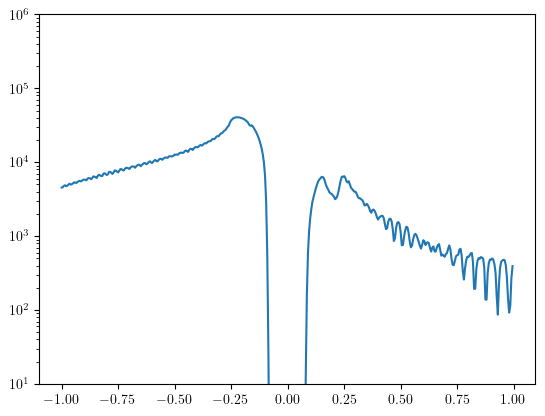

In [1076]:
plt.plot(omegas, transportna[0])
plt.yscale('log')
plt.ylim(1e1, 1e6)

In [279]:
Gamma = 0.02
omega_max = 0.5
domega = 0.01
phi_B = transportna_phi_Boltzmann(s.kymesh, s.kxmesh, s.energije, s.mu, omega_max, domega, faktor=0.5)
phi = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma, omega_max, domega)

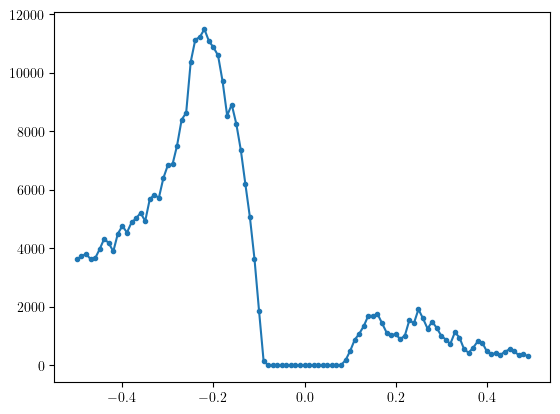

In [289]:
omegas = np.arange(-omega_max, omega_max, domega)
#plt.plot(omegas, phi[0].real, '.-')
plt.plot(omegas, phi_B[0] , '.-')



In [239]:
_, Nx = s.kymesh.shape
energije = s.energije
dKy, dKx = np.diff(s.kymesh[:,0])[0], np.diff(s.kxmesh[0])[0]
energije_new = np.copy(energije)
energije_new[0,0,Nx//2:] = energije[1,0,Nx//2:]
energije_new[1,0,Nx//2:] = energije[0,0,Nx//2:]

energije_new[2,0,Nx//2:] = energije[3,0,Nx//2:]
energije_new[3,0,Nx//2:] = energije[2,0,Nx//2:]

energije_new[4,0,Nx//2:] = energije[5,0,Nx//2:]
energije_new[5,0,Nx//2:] = energije[4,0,Nx//2:]

T = 1/100
velocity_y, velocity_x = np.zeros(energije.shape), np.zeros(energije.shape)
for i in range(6):
    gr = np.gradient(energije[i])
    velocity_y[i, :, :], velocity_x[i, :, :] = gr[0]/dKy, gr[1]/dKx
''' factor 2 is for spin degeneracy '''
summand_xx = -velocity_x**2 * tokovi_drugic.fd_1(energije_new - mu, T)
summand_yy = -velocity_y**2 * tokovi_drugic.fd_1(energije_new - mu, T)
L1_Boltzmann_xx = np.sum((energije_new - mu) * summand_xx)
L0_Boltzmann_xx = np.sum(summand_xx)
L1_Boltzmann_yy = np.sum((energije - mu) * summand_yy)
L0_Boltzmann_yy = np.sum(summand_yy)



In [31]:
col1, col2 = 'dodgerblue', 'orangered'
#plt.plot(s.Ts, -np.array(s.L12_xx_boltz)/np.array(s.L11_xx_boltz) / np.array(s.Ts), 'x', color=col2)
#plt.plot(s.Ts, -np.array(s.L12_yy_boltz)/np.array(s.L11_yy_boltz) / np.array(s.Ts), 'x', color=col1)

ts = np.linspace(0.01,0.03,1000)

plt.plot(ts, (1-m_x)/(1+m_x) * (gap/2/ts + 3/2) + 1/2*np.log(m_x) + 1/2*np.log(z), color=col1, ls='dashed')
plt.plot(ts, (1-m_y)/(1+m_y) * (gap/2/ts + 3/2) + 1/2*np.log(m_y) + 1/2*np.log(z), color=col2, ls='dashed')

col1, col2 = 'orangered', 'dodgerblue'
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

plt.plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_xx.npy'), '.', ms=6, color='black', label=r'$\Gamma=0$')
plt.plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_yy.npy'), '.', ms=6, color='black')

plt.plot(np.load('ts_30.npy'), np.load('s_30_neint_xx.npy'), '.--', color=col1, label=r'$\nu=x$')
plt.plot(np.load('ts_30.npy'), np.load('s_30_neint_yy.npy'), '.--', color=col2, label=r'$\nu=y$')


NameError: name 'm_x' is not defined

1.6500246452748715 [[0.00161797]]
1.4513149571064958 [[0.01261321]]


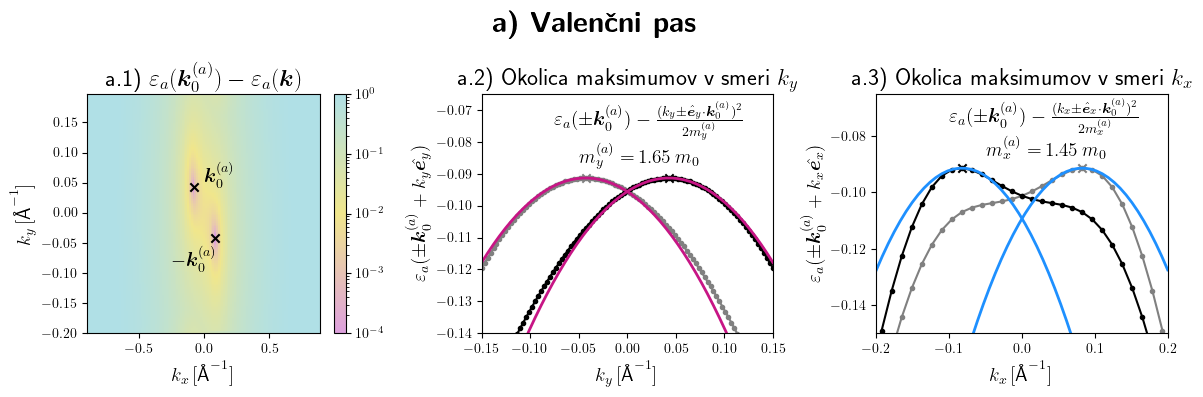

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), facecolor='white')
energije = s.energije
energije_new = np.copy(energije)
energije_new[0,0,Nx//2:] = energije[1,0,Nx//2:]
energije_new[1,0,Nx//2:] = energije[0,0,Nx//2:]

energije_new[2,0,Nx//2:] = energije[3,0,Nx//2:]
energije_new[3,0,Nx//2:] = energije[2,0,Nx//2:]

energije_new[4,0,Nx//2:] = energije[5,0,Nx//2:]
energije_new[5,0,Nx//2:] = energije[4,0,Nx//2:]


from matplotlib.colors import LinearSegmentedColormap

col1, col2, col3 ='plum', 'khaki', 'powderblue', 

colors = [matplotlib.colors.to_rgb(col1), matplotlib.colors.to_rgb(col2), matplotlib.colors.to_rgb(col3)] # first color is black, last is red
com = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)

ri, ci = energije_new[1].argmax()//energije_new[1].shape[1], energije_new[1].argmax()%energije_new[1].shape[1]
cf = ax[0].pcolormesh(s.kxmesh[0], s.kymesh[:,0], np.max(energije_new[1]) - energije_new[1], cmap=com,
                      norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))
ax[1].plot(s.kymesh[:,0], energije_new[1][:,ci] - mu, '.-', color='grey')
ax[2].plot(s.kxmesh[0], energije_new[1][ri] - mu, '.-', color='grey')

plt.tight_layout()

ri2, ci2 = s.Ny//2 - ri, s.Nx//2 - ci
ax[1].plot(s.kymesh[:,0], energije_new[1][:,ci2 + s.Nx//2] - mu, '.-', color='black')

ax[2].plot(s.kxmesh[0], energije_new[1][ri2 + s.Ny//2] - mu, '.-', color='black')

ax[1].scatter(s.kymesh[:,0][ri2 + s.Ny//2], np.max(energije_new[1])-mu , color='black', marker='x')
ax[2].scatter(s.kxmesh[0][ci2 + s.Nx//2], np.max(energije_new[1])-mu , color='black', marker='x')

ax[1].scatter(s.kymesh[:,0][ri], np.max(energije_new[1])-mu , color='grey', marker='x')
ax[2].scatter(s.kxmesh[0][ci], np.max(energije_new[1])-mu , color='grey', marker='x')

ax[0].scatter(s.kxmesh[0][ci], s.kymesh[:,0][ri], zorder=10, color='black', marker='x')
ax[0].scatter(s.kxmesh[0][s.Nx//2 + ci2],s.kymesh[:,0][s.Ny//2 + ri2], zorder=10, color='black', marker='x')

fig.colorbar(cf, ax=ax[0])

ax[1].set_ylabel(r'$\varepsilon_2(\bm{k}_0 + k_y \hat{\bm{e}_y})$', fontsize=14)
ax[2].set_ylabel(r'$\varepsilon_2(\bm{k}_0 + k_x \hat{\bm{e}_x})$', fontsize=14)

parabola1 = energije_new[1][:,ci] - mu

from scipy.optimize import curve_fit
def func(x, m):
    return -x**2/(2*m)
in1, in2 = ri - 20, ri + 20
popt, pcov = curve_fit(func, s.kymesh[:,0][in1:in2] - s.kymesh[:,0][ri], parabola1[in1:in2] - np.max(parabola1))
faktor = 1973**2/(0.511 * 1e6)
masa2_y = popt[0] * faktor
print(masa2_y, pcov**0.5)

kji = np.linspace(-0.15,0.15)
ax[1].plot(kji, np.max(parabola1) + func(kji - s.kymesh[:,0][ri], popt[0]), color='mediumvioletred', lw=2)
kji = np.linspace(-0.15,0.15)
ax[1].plot(kji, np.max(parabola1) + func(kji + s.kymesh[:,0][ri], popt[0]), color='mediumvioletred', lw=2)


ax[1].set_xlim(-0.15,0.15)
ax[1].set_ylim(-0.14,-0.065)

ax[2].set_xlim(-0.2,0.2)
ax[2].set_ylim(-0.15,-0.065)

#ax[2].text(-0.23,1.4, r'$\varepsilon_3(\bm{k}_0) + \frac{(k_x - \hat{\bm{e}}_y\cdot \bm{k}_0)^2}{2m_x}$', color='royalblue', fontsize=14)
ax[0].text(0,0.05,r'$\bm{k}_0^{(a)}$', fontsize=14)
ax[0].text(-0.25,-0.09,r'$-\bm{k}_0^{(a)}$', fontsize=14, color='black')

ax[1].set_ylabel(r'$\varepsilon_a(\pm\bm{k}_0^{(a)} + k_y \hat{\bm{e}_y})$', fontsize=14)
ax[2].set_ylabel(r'$\varepsilon_a(\pm\bm{k}_0^{(a)} + k_x \hat{\bm{e}_x})$', fontsize=14)

ymin, ymax = ax[1].get_ylim()
xmin, xmax = ax[1].get_xlim()
ax[1].text(-np.abs(xmin)/2,-0.075, r'$\varepsilon_a(\pm\bm{k}_0^{(a)}) - \frac{(k_y \pm \hat{\bm{e}}_y\cdot \bm{k}_0^{(a)})^2}{2m_y^{(a)}}$', color='black', fontsize=14,
    )
ymin, ymax = ax[2].get_ylim()
xmin, xmax = ax[2].get_xlim()
ax[2].text(-np.abs(xmin)/2, -0.075, r'$\varepsilon_a(\pm\bm{k}_0^{(a)}) - \frac{(k_x \pm \hat{\bm{e}}_x\cdot \bm{k}_0^{(a)})^2}{2m_x^{(a)}}$', color='black', fontsize=14,
          )
ax[1].text(-0.05,-0.087, r'$m_y^{(a)} =\,$' + rf'${np.round(masa2_y,2)}\, m_0$', color='black', fontsize=14,)

in1, in2 = ci-30,ci+30
parabola2 = energije_new[1][ri][in1:in2] - mu
popt, pcov = curve_fit(func, s.kxmesh[0][in1:in2] - s.kxmesh[0][ci], parabola2 - np.max(parabola2))
masa2_x = popt[0] * faktor
print(masa2_x, pcov**0.5)

kji = np.linspace(-0.2,0.2)
ax[2].plot(kji, func(kji - s.kxmesh[0][ci], popt[0]) + np.max(parabola2), color='dodgerblue', lw=2)
ax[2].plot(kji, func(kji + s.kxmesh[0][ci], popt[0]) + np.max(parabola2), color='dodgerblue', lw=2)


ax[2].text(-0.05,-0.087, r'$m_x^{(a)}= \,$' + rf'${np.round(masa2_x,2)}\, m_0$', color='black', fontsize=14,
        )

ax[0].set_xlabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14), ax[0].set_ylabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14)
ax[2].set_xlabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14)
ax[1].set_xlabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14)

ax[0].set_title(r'a.1) $\varepsilon_a(\bm{k}_0^{(a)}) - \varepsilon_a(\bm{k})$', fontsize=17)
ax[1].set_title(r'a.2) Okolica maksimumov v smeri $k_y$', fontsize=17)
ax[2].set_title(r'a.3) Okolica maksimumov v smeri $k_x$', fontsize=17)
fig.suptitle(r'\textbf{a) Valenčni pas}', fontsize=21)

plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.savefig('23-07-valencni.png')
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
plt.savefig('valencni.png')


In [78]:
s.Nk**0.5

130.0

1.6337912544619002

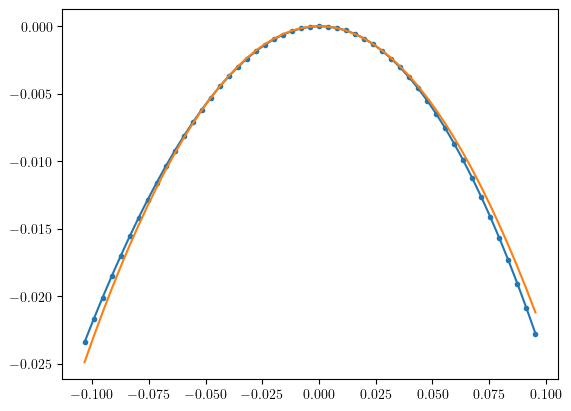

In [976]:
parabola1 = energije_new[1][:,ci2 + s.Nx//2] - mu

plt.plot(s.kymesh[:,0][35:86] - s.kymesh[:,0][ri2 + s.Ny//2], parabola1[35:86] - np.max(parabola1), '.-')
from scipy.optimize import curve_fit
def func(x, m):
    return -x**2/(2*m)
popt, pcov = curve_fit(func, s.kymesh[:,0][35:86] - s.kymesh[:,0][ri2 + s.Ny//2], parabola1[35:86] - np.max(parabola1))
plt.plot(s.kymesh[:,0][35:86] - s.kymesh[:,0][ri2 + s.Ny//2], func(s.kymesh[:,0][35:86] - s.kymesh[:,0][ri2 + s.Ny//2], popt[0]))
masa_y = popt[0] * 7.6
masa_y


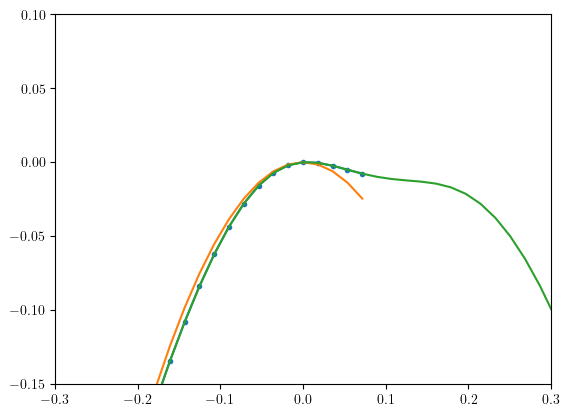

In [1020]:
in1, in2 = 30, 50
parabola2 = energije_new[1][ri2 + s.Ny//2][in1:in2] - mu
plt.plot(s.kxmesh[0][in1:in2] - s.kxmesh[0][ci2 + s.Ny//2], parabola2 - np.max(parabola2), '.-')
from scipy.optimize import curve_fit
def func(x, m):
    return -x**2/(2*m)
popt, pcov = curve_fit(func, s.kxmesh[0][in1:in2] - s.kxmesh[0][ci2 + s.Ny//2], parabola2 - np.max(parabola2))
plt.plot(s.kxmesh[0][in1:in2] - s.kxmesh[0][ci2 + s.Ny//2], func(s.kxmesh[0][in1:in2] - s.kxmesh[0][ci2 + s.Ny//2], popt[0]))

masa_x = popt[0] * 7.6
masa_x

plt.plot(s.kxmesh[0] - s.kxmesh[0][ci2 + s.Ny//2], energije_new[1][ri2 + s.Ny//2] - mu - np.max(parabola2))
plt.ylim(-0.15,0.1)
plt.xlim(-0.3,0.3)

kji = np.linspace(-0.2,0.2)

5.283427148627925 [[0.00117515]]
0.46487874724028383 [[0.00023661]]


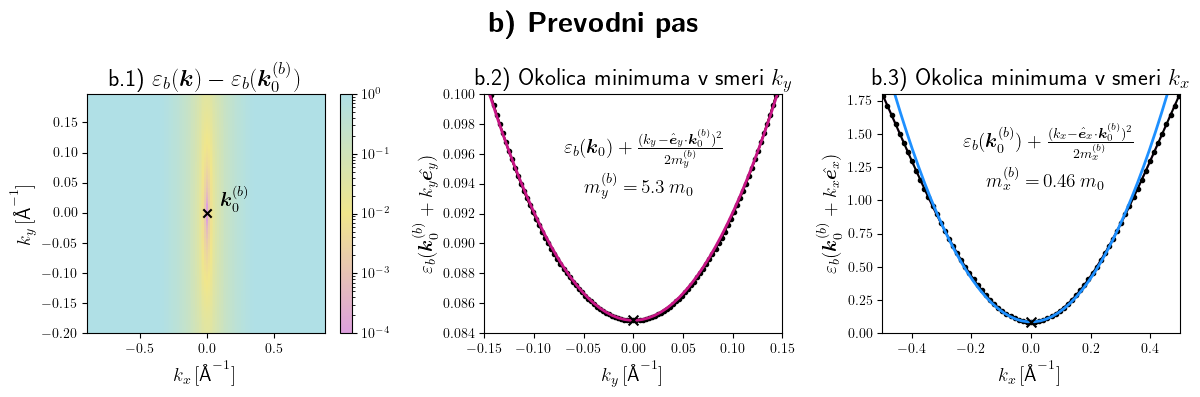

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), facecolor='white')
energije_new = np.copy(energije)
energije_new[0,0,Nx//2:] = energije[1,0,Nx//2:]
energije_new[1,0,Nx//2:] = energije[0,0,Nx//2:]

energije_new[2,0,Nx//2:] = energije[3,0,Nx//2:]
energije_new[3,0,Nx//2:] = energije[2,0,Nx//2:]

energije_new[4,0,Nx//2:] = energije[5,0,Nx//2:]
energije_new[5,0,Nx//2:] = energije[4,0,Nx//2:]
col1, col2, col3 ='plum', 'khaki', 'powderblue', 

colors = [matplotlib.colors.to_rgb(col1), matplotlib.colors.to_rgb(col2), matplotlib.colors.to_rgb(col3)] # first color is black, last is red
com = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)
ri, ci = energije_new[2].argmin()//energije_new[2].shape[1], energije_new[2].argmin()%energije_new[2].shape[1]
cf = ax[0].pcolormesh(s.kxmesh[0], s.kymesh[:,0], energije_new[2] - np.min(energije_new[2]), cmap=com,
                 norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1))

ax[1].plot(s.kymesh[:,0], energije_new[2][:,ci] - mu, color='red', ls='dashed')
ax[1].scatter(s.kymesh[:,0][ri], np.min(energije_new[2])-mu, color='black', marker='x', s=50, zorder=100)
ax[2].scatter(s.kxmesh[0][ci], np.min(energije_new[2])-mu, color='black', marker='x', s=50, zorder=100)
ax[2].plot(s.kxmesh[0], energije_new[2][ri] - mu, color='orchid', ls='dashed')

ax[0].set_xlabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14), ax[0].set_ylabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14)
ax[2].set_xlabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14)
ax[1].set_xlabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14)

ax[0].scatter(s.kxmesh[0][ci], s.kymesh[:,0][ri], zorder=10, color='black', marker='x')

ax[1].plot(s.kymesh[:,0], energije_new[2][:,ci] - mu, '.-',  color='black')
ax[2].plot(s.kxmesh[0], energije_new[2][ri] - mu, '.-', color='black')

ax[1].set_xlim(-0.15,0.15)
ax[1].set_ylim(0.084,0.1)
ax[2].set_xlim(-0.5,0.5)
ax[2].set_ylim(0,1.8)

fig.colorbar(cf, ax=ax[0])

parabola1 = energije_new[2][:,ci] - mu

from scipy.optimize import curve_fit
faktor = 1973**2/(0.511 * 1e6)
def func(x, m):
    return x**2/(2*m)
popt, pcov = curve_fit(func, s.kymesh[:,0][15:86] - s.kymesh[:,0][ri], parabola1[15:86] - np.min(parabola1))
masa1_y = popt[0] * faktor
print(masa1_y, pcov**0.5)

kji = np.linspace(-0.15,0.15)
ax[1].plot(kji, np.min(parabola1) + func(kji, popt[0]), color='mediumvioletred', lw=2)
ax[1].text(-0.07,0.096, r'$\varepsilon_b(\bm{k}_0) + \frac{(k_y - \hat{\bm{e}}_y\cdot \bm{k}_0^{(b)})^2}{2m_y^{(b)}}$', fontsize=14,
         )
ax[1].text(-0.05,0.0933, r'$m_y^{(b)} =\,$' + rf'${np.round(masa1_y,1)}\, m_0$', fontsize=14,
          )

ind1, ind2 = ci-25,ci+25
parabola2 = energije_new[2][ri][ind1:ind2] - mu
popt, pcov = curve_fit(func, s.kxmesh[0][ind1:ind2] - s.kxmesh[0][ci], parabola2 - np.min(parabola2))
masa1_x = popt[0] * faktor
print(masa1_x, pcov**0.5)
kji = np.linspace(-0.5,0.5)
ax[2].plot(kji, np.min(parabola1) + func(kji, popt[0]), lw=2, color='dodgerblue')
ax[2].text(-0.23,1.4, r'$\varepsilon_b(\bm{k}_0^{(b)}) + \frac{(k_x - \hat{\bm{e}}_x\cdot \bm{k}_0^{(b)})^2}{2m_x^{(b)}}$', fontsize=14,
         )
ax[2].text(-0.15, 1.10, r'$m_x^{(b)} =\, $' + rf'${np.round(masa1_x,2)}\,m_0$', fontsize=14,)
ax[0].text(0.1,0.01,r'$\bm{k}_0^{(b)}$', fontsize=14)
ax[1].set_ylabel(r'$\varepsilon_b(\bm{k}_0^{(b)} + k_y \hat{\bm{e}_y})$', fontsize=14)
ax[2].set_ylabel(r'$\varepsilon_b(\bm{k}_0^{(b)} + k_x \hat{\bm{e}_x})$', fontsize=14)

ax[0].set_title(r'b.1) $\varepsilon_b(\bm{k}) - \varepsilon_b(\bm{k}_0^{(b)})$', fontsize=17)
ax[1].set_title(r'b.2) Okolica minimuma v smeri $k_y$', fontsize=17)
ax[2].set_title(r'b.3) Okolica minimuma v smeri $k_x$', fontsize=17)
fig.suptitle(r'\textbf{b) Prevodni pas}', fontsize=21)
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.savefig('23-07-prevodni.png')
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
plt.savefig('prevodni.png')

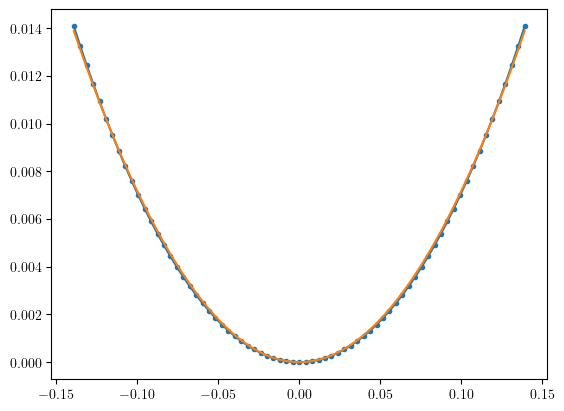

In [748]:
parabola1 = energije_new[2][:,ci] - mu

plt.plot(s.kymesh[:,0][15:86] - s.kymesh[:,0][ri], parabola1[15:86] - np.min(parabola1), '.-')
from scipy.optimize import curve_fit
def func(x, m):
    return x**2/(2*m)
popt, pcov = curve_fit(func, s.kymesh[:,0][15:86] - s.kymesh[:,0][ri], parabola1[15:86] - np.min(parabola1))
masa1_y = popt[0] * 7.6
masa1_y

plt.plot(s.kymesh[:,0][15:86] - s.kymesh[:,0][ri], func(s.kymesh[:,0][15:86] - s.kymesh[:,0][ri], popt[0]))


0.4672304657918365

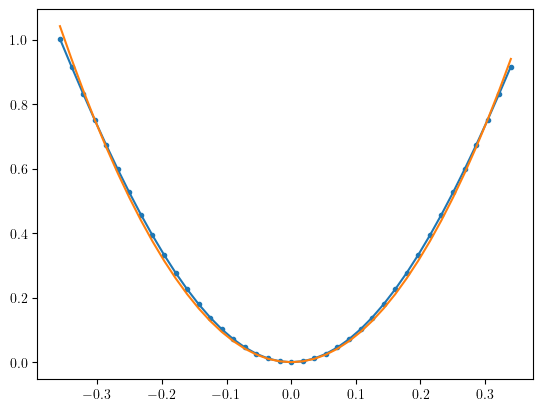

In [744]:
parabola2 = energije_new[2][ri][30:70] - mu
plt.plot(s.kxmesh[0][30:70] - s.kxmesh[0][ci], parabola2 - np.min(parabola2), '.-')
from scipy.optimize import curve_fit
def func(x, m):
    return x**2/(2*m)
popt, pcov = curve_fit(func, s.kxmesh[0][30:70] - s.kxmesh[0][ci], parabola2 - np.min(parabola2))
plt.plot(s.kxmesh[0][30:70] - s.kxmesh[0][ci], func(s.kxmesh[0][30:70] - s.kxmesh[0][ci], popt[0]))
masa1_x = popt[0] * 7.6
masa1_x

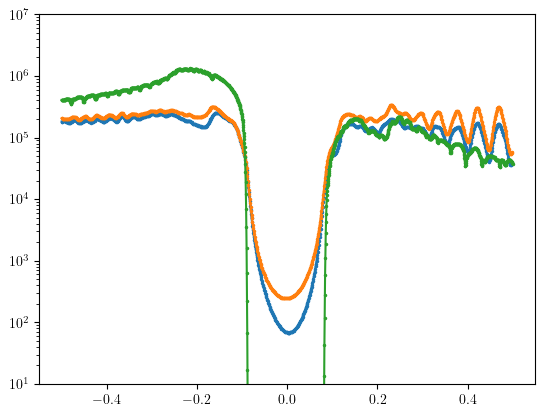

In [771]:
nu = 1

omega_max, domega = 0.5, 0.001
omegas = np.arange(-omega_max, omega_max, domega)
plt.plot(omegas, trans[nu] * np.pi, '.-', ms=3)
plt.plot(omegas, trans2[nu] * np.pi, '.-', ms=3)

omega_max, domega = 0.5, 0.0005
omegas = np.arange(-omega_max, omega_max, domega)
plt.plot(omegas, transportna[nu] / (2*Gamma), '.-', ms=3)
plt.yscale('log')
plt.ylim(1e1,1e7)

betas = np.linspace(100,500)[::-1]
Ts = 1/betas

l11_x, l12_x = [], []

omega_max, domega = 0.5, 0.0005
omegas = np.arange(-omega_max, omega_max, domega)
for T in Ts:
    l11_x.append(np.sum(-tokovi_drugic.fd_1(omegas, T) * transportna[nu]) / s.Nk)
    l12_x.append(np.sum(-tokovi_drugic.fd_1(omegas, T) * omegas * transportna[nu]) / s.Nk)


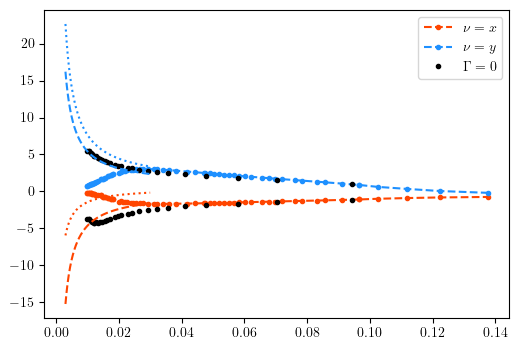

In [79]:
col1, col2 = 'orangered', 'dodgerblue'
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

fig, ax = plt.subplots(figsize=(6,4))

plt.plot(np.load('ts_30.npy'), np.load('s_30_neint_xx.npy'), '.--', color=col1, label=r'$\nu=x$')
plt.plot(np.load('ts_30.npy'), np.load('s_30_neint_yy.npy'), '.--', color=col2, label=r'$\nu=y$')

plt.plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_xx.npy'), '.', ms=6, color='black', label=r'$\Gamma=0$')
plt.plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_yy.npy'), '.', ms=6, color='black')

gap = np.min(energije_new[2]) - np.max(energije_new[1])
m_x = masa2_x / masa1_x
m_y = masa2_y / masa1_y
z = 2

ts = np.linspace(0.003,0.03,1000)

plt.plot(ts, (1-m_x)/(1+m_x) * (gap/2/ts + 2) + 1/2*np.log(m_x) + 1/2*np.log(z), color=col1, ls='dashed')
plt.plot(ts, (1-m_x/z)/(1+m_x/z) * (gap/2/ts + 2) + 1/2*np.log(m_x) + 1/2*np.log(z), color=col1, ls='dotted')
plt.plot(ts, (1-m_y)/(1+m_y) * (gap/2/ts + 2) + 1/2*np.log(m_y) + 1/2*np.log(z), color=col2, ls='dashed')
plt.plot(ts, (1-m_y/z)/(1+m_y/z) * (gap/2/ts + 2) + 1/2*np.log(m_y) + 1/2*np.log(z), color=col2, ls='dotted')


#plt.plot(Ts, - np.array(l12_x) / np.array(l11_x) / np.array(Ts), color='purple', zorder=100)

plt.legend()




In [118]:
omega_max = 1
domega = 0.005
Gamma=0.01
omegas, trans = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma, omega_max, domega)
omegas, transK, transI, _, _, _ = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, s.mu, Gamma, omega_max, domega)


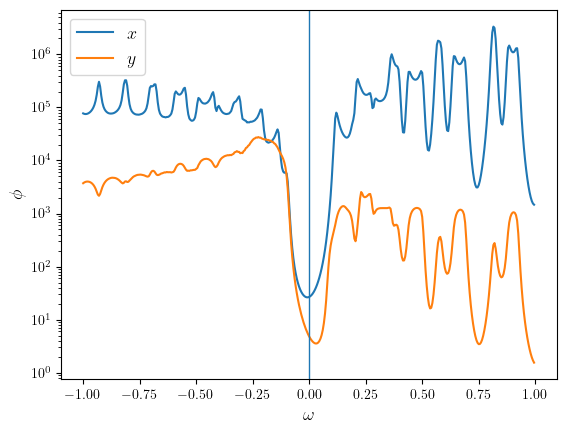

In [114]:
plt.plot(omegas, trans[0].real, label='$x$')
plt.plot(omegas, trans[1].real, label='$y$')
plt.legend(fontsize=13), plt.xlabel(r'$\omega$', fontsize=13), plt.ylabel(r'$\phi$', fontsize=13)
plt.axvline(0, lw=1)
plt.axhline(0, lw=1)
plt.yscale('log')

plt.show()


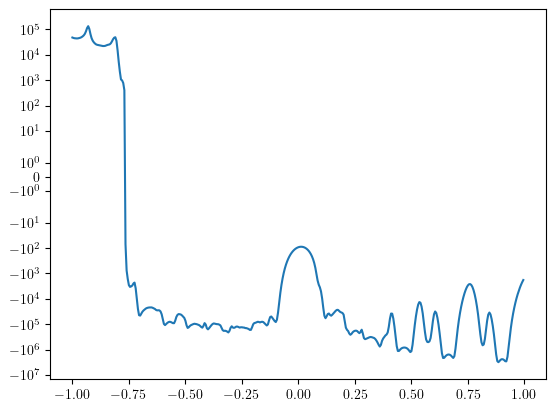

In [132]:
plt.plot(omegas, transK[0].real)
plt.yscale('symlog')

-117.22266139253253

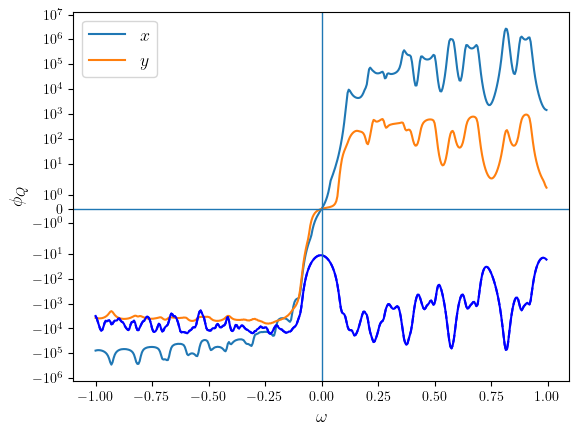

In [130]:
plt.plot(omegas, trans[0].real * omegas, label='$x$')
plt.plot(omegas, trans[1].real * omegas, label='$y$')

plt.plot(omegas, transK[1].real + transI[1].real, color='blue')
plt.plot(omegas, transK[1].real +transI[1].real, color='blue', ls='dashed')

plt.legend(fontsize=13), plt.xlabel(r'$\omega$', fontsize=13), plt.ylabel(r'$\phi_Q$', fontsize=13)


plt.yscale('symlog')
plt.axvline(0, lw=1)
plt.axhline(0, lw=1)

np.sum(- tokovi_drugic.fd_1(omegas, T) * trans[1].real * omegas)

In [273]:
dKy, dKx = np.diff(s.kymesh[:,0])[0], np.diff(s.kxmesh[0])[0]
energije_new = np.copy(s.energije)
energije_new[0,0,Nx//2:] = s.energije[1,0,Nx//2:]
energije_new[1,0,Nx//2:] = s.energije[0,0,Nx//2:]

energije_new[2,0,Nx//2:] = s.energije[3,0,Nx//2:]
energije_new[3,0,Nx//2:] = s.energije[2,0,Nx//2:]

energije_new[4,0,Nx//2:] = s.energije[5,0,Nx//2:]
energije_new[5,0,Nx//2:] = s.energije[4,0,Nx//2:]

velocity_y, velocity_x = np.zeros(s.energije.shape), np.zeros(s.energije.shape)

trans_x, trans_y = np.zeros(len(omegas)), np.zeros(len(omegas))
for i in range(6):
    gr = np.gradient(s.energije[i])
    velocity_y[i, :, :], velocity_x[i, :, :] = gr[0]/dKy, gr[1]/dKx

for i in range(s.Ny):
    for j in range(s.Nx):
        for k, omega in enumerate(omegas):
            A = tokovi_drugic.Spektralna_k(omega, mu, s.energije[:,i,j], domega)
            trans_x[k] += 2*np.sum(velocity_x[:,i,j]**2 * np.diag(A))
            trans_y[k] += 2*np.sum(velocity_y[:,i,j]**2 * np.diag(A))

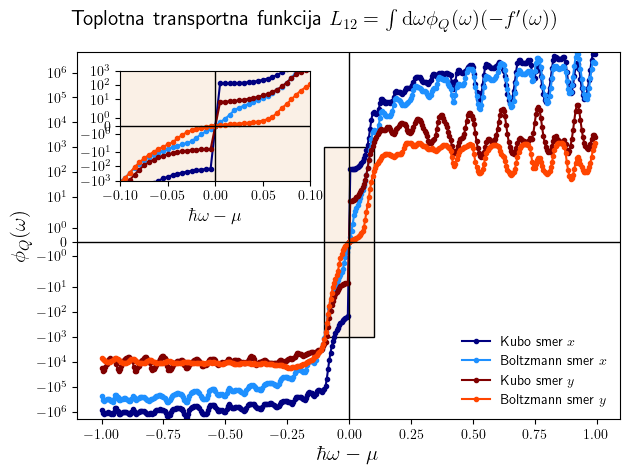

In [ ]:
fig, ax = plt.subplots()

ins = ax.inset_axes([0.08,0.65,0.35,0.3])

phi_I = transI.real
phi_K = transK.real
for j in range(2):
    phi_I[j,len(omegas)//2] = 0
    phi_K[j,len(omegas)//2] = 0

for j in [ax, ins]:
    j.plot(omegas, transI[0].real + transK[0].real, '.-', color='navy', label='Kubo smer $x$')
    j.plot(omegas, trans[0].real * omegas, '.-', color='dodgerblue', label='Boltzmann smer $x$')

    j.plot(omegas, transI[1].real + transK[1].real, '.-', color='maroon', label='Kubo smer $y$')
    j.plot(omegas, trans[1].real * omegas, '.-', color='orangered', label='Boltzmann smer $y$')
    j.axhline(0, color='black', lw=1), j.axvline(0, color='black', lw=1)
    j.set_yscale('symlog')

ins.set_ylim(-1e3,1e3), ins.set_xlim(-0.1,0.1)

rect = matplotlib.patches.Rectangle(xy=(-0.1, -1e3),
                                    width=0.2, height=2*1e3,
                                    linewidth=1,edgecolor='black',
                                    facecolor='linen', clip_on= False);
plt.gca().add_patch(rect)
ins.set_facecolor('linen')
ax.legend(frameon=False, ncols=1, loc='lower right')
ax.set_xlabel(r'$\hbar\omega - \mu$', fontsize=15), ins.set_xlabel(r'$\hbar\omega - \mu$', fontsize=13)
ax.set_ylabel(r'$\phi_Q(\omega)$', fontsize=15)
fig.suptitle(r"Toplotna transportna funkcija $L_{12} = \int \dd \omega \phi_Q(\omega) (-f'(\omega))$", fontsize=15)

plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.savefig('22-07-phiQ.png')

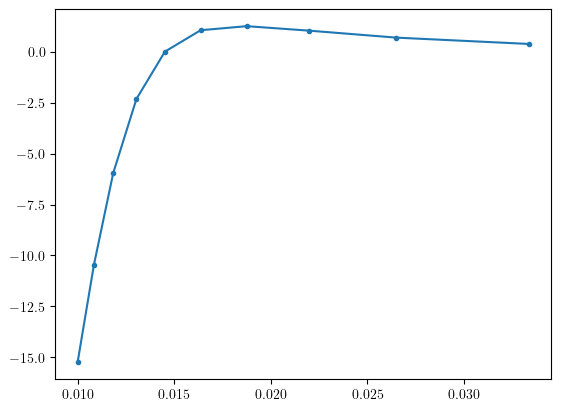

In [158]:
l1s = []
kji, iji, iji_neint = [], [], []
j = 1
for T in 1/np.linspace(100,30,10):
    l12_k, l12_i, l12_i_, l12_i_neint = tokovi_drugic.L12(transK[j], transI[j], transI[j], trans[j], omegas, T)
    l11 = tokovi_drugic.L11(trans[j], omegas, T)
    l1s.append(l11)
    kji.append(l12_k)
    iji.append(l12_i)
    iji_neint.append(l12_i_neint)

plt.plot(1/np.linspace(100,30,10), -(np.array(kji).real + np.array(iji).real) / np.array(l1s).real * np.linspace(100,30,10), '.-')

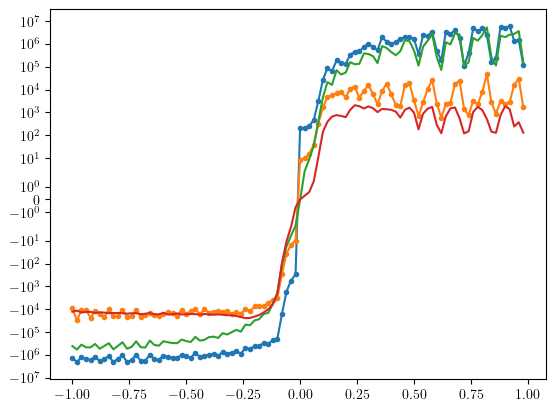

In [89]:
plt.plot(omegas, transK[0].real + transI[0].real, '.-')
plt.plot(omegas, transK[1].real + transI[1].real, '.-')

plt.plot(omegas, trans[0].real * omegas)
plt.plot(omegas, trans[1].real * omegas)

plt.yscale('symlog')

In [142]:
omega_max = 1
domega = 0.05
Gamma=0.03
omegas, trans = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma, omega_max, domega)
omegas, trans_K, trans_I = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix,  s.j1_matrix, s.j2_matrix, s.mu, Gamma, omega_max, domega)

415.2572632884037

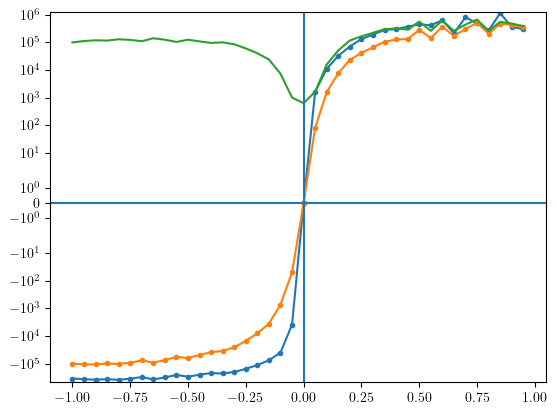

In [145]:
j = 0
plt.plot(omegas,np.hstack([-(trans_K[j].real + trans_I[j].real)[:len(omegas)//2], 0, (trans_K[j].real + trans_I[j].real)[len(omegas)//2+1:]]), '.-')
plt.plot(omegas, trans[j].real * omegas, '.-', )
plt.plot(omegas, trans[j].real)

plt.axvline(0)
plt.axhline(0)
plt.yscale('symlog')
#plt.xlim(-0.05,0.05)

plt.yscale('symlog')

-(trans_K[j].real + trans_I[j].real)[len(omegas)//2] + (trans_K[j].real + trans_I[j].real)[len(omegas)//2+1]

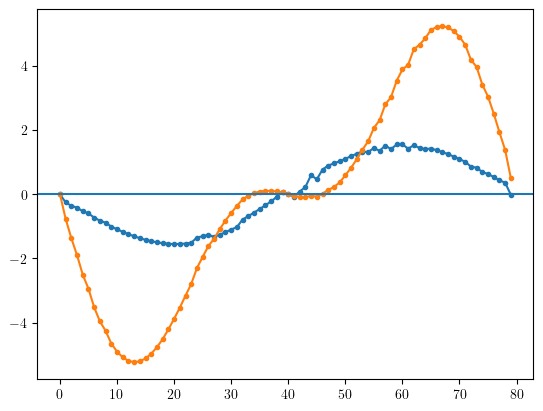

In [18]:
orb = 1
plt.plot( j_new[0,orb,orb].real[0,:], '.-' )
plt.plot( j1_new[0,orb,orb].real[0,:], '.-' )

plt.axhline(0)
plt.show()

#sns.heatmap(j_new[0,orb,orb].real * j1_new[0,orb,orb].real)

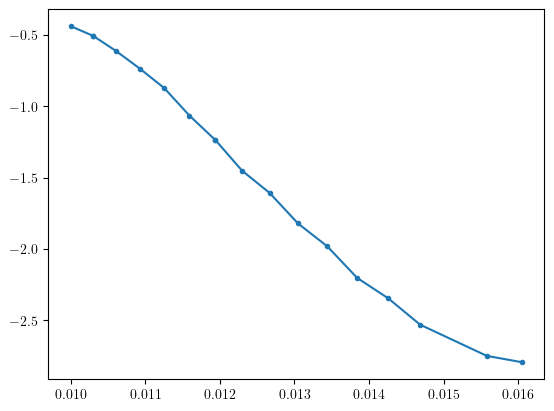

In [112]:
#plt.plot(s.Ts, -(np.array(s.L12_i_full_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / s.Ts, '.-')
#plt.plot(s.Ts, -(np.array(s.L12_i_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / s.Ts, '.-')
plt.plot(s.Ts, -np.array(s.L12_i_neint_xx).real / np.array(s.L11_xx).real / s.Ts, '.-')

FileNotFoundError: [Errno 2] No such file or directory: 'data_Nk30_gamma003.npy'

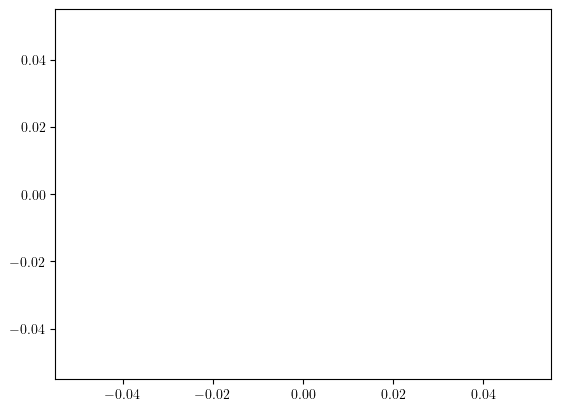

In [1242]:
plt.plot(s.Ts, -np.array(s.L12_xx_boltz) / np.array(s.L11_xx_boltz) / np.array(s.Ts), '.-')
plt.plot(s.Ts, -np.array(s.L12_yy_boltz) / np.array(s.L11_yy_boltz) / np.array(s.Ts), '.-')

data = np.load('data_Nk30_gamma003.npy')
plt.plot(data[0], data[6])
plt.plot(data[0], data[5])

seebeck_boltz = np.zeros((3,len(s.Ts)))
seebeck_boltz[0] = s.Ts
seebeck_boltz[1] = -np.array(s.L12_xx_boltz) / np.array(s.L11_xx_boltz) / np.array(s.Ts)
seebeck_boltz[2] = -np.array(s.L12_yy_boltz) / np.array(s.L11_yy_boltz) / np.array(s.Ts)

In [88]:
plt.plot(s.Ts, -(np.array(s.L12_i_yy).real + np.array(s.L12_k_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts), '.-')
plt.plot(s.Ts, -(np.array(s.L12_i_full_yy).real + np.array(s.L12_k_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts), '.-')
plt.plot(s.Ts, -(np.array(s.L12_i_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts), '.-')
plt.plot(s.Ts, -(np.array(s.L12_i_full_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts), '.-')
plt.show()

plt.plot(s.Ts, -(np.array(s.L12_i_neint_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts))
plt.plot(s.Ts, -(np.array(s.L12_i_neint_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts))


seebeck = np.zeros((8, len(s.Ts)))

seebeck[0] = s.Ts
seebeck[1] = -(np.array(s.L12_i_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts)
seebeck[2] = -(np.array(s.L12_i_yy).real + np.array(s.L12_k_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts)
seebeck[3] = -(np.array(s.L12_i_full_xx).real + np.array(s.L12_k_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts)
seebeck[4] = -(np.array(s.L12_i_full_yy).real + np.array(s.L12_k_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts)
seebeck[5] = -(np.array(s.L12_i_neint_xx).real) / np.array(s.L11_xx).real / np.array(s.Ts)
seebeck[6] = -(np.array(s.L12_i_neint_yy).real) / np.array(s.L11_yy).real / np.array(s.Ts)
seebeck[7] = s.phis
#np.save('data_Nk30_gamma003.npy', seebeck)


ValueError: operands could not be broadcast together with shapes (0,) (60,) 

In [10]:
omegas, trans1 = tokovi_drugic.transportna_I_full(s.kymesh, s.vecs, s.energije, s.fs, s.j2_matrix_full, s.j_matrix, s.mu, 1, 0.01, 0.03)
omegas, trans2 = tokovi_drugic.transportna_I_full_alternative(s.kymesh, s.vecs, s.energije, s.fs, s.j2_matrix_full, s.j_matrix, s.mu, 1, 0.01, 0.03)

In [ ]:
omegas, trans = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma=0.03, omega_max = 1, domega=0.01)
_, transK, transI = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, s.mu, Gamma=0.03, omega_max=1, domega=0.01)

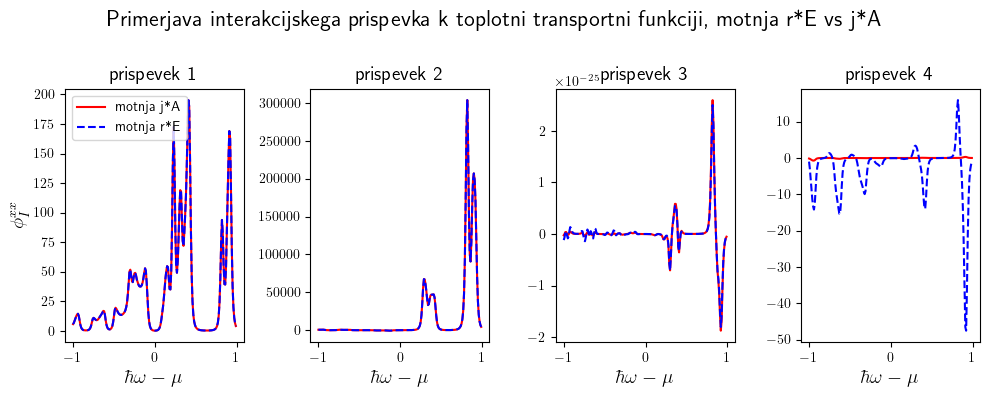

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(10,4))
for j in range(4):
    ax[j].plot(omegas, trans1[0,j].real, color='red', label='motnja j*A')
    ax[j].plot(omegas, trans2[0,j].real, color='blue', ls='--', label='motnja r*E')
    ax[j].set_title(rf'prispevek {j+1}', fontsize=14)
    ax[j].set_xlabel(r'$\hbar\omega - \mu$', fontsize=14)
ax[0].legend()
ax[0].set_ylabel(r'$\phi_{I}^{xx}$', fontsize=14)
fig.suptitle(r'Primerjava interakcijskega prispevka k toplotni transportni funkciji, motnja r*E vs j*A', fontsize=16)
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.savefig('20-07-motnja.png')

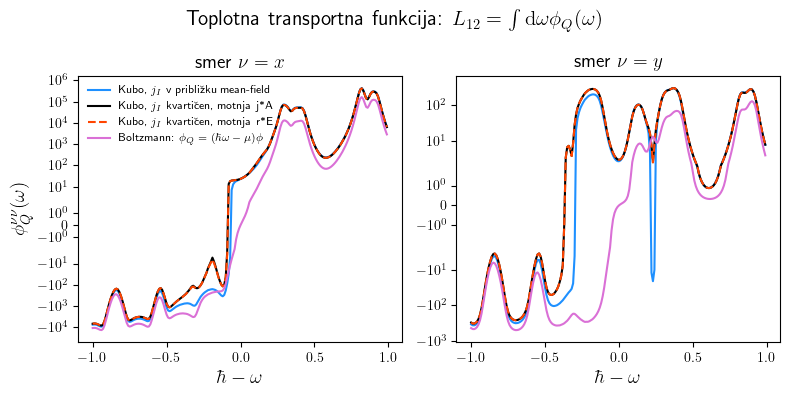

In [105]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
for j in range(2):
    ax[j].plot(omegas, transK[j].real + transI[j].real, color='dodgerblue', label='Kubo, $j_I$ v približku mean-field')
    ax[j].plot(omegas, transK[j].real + np.einsum('ijk->ik', trans1)[j].real, '-', color='black', label='Kubo, $j_I$ kvartičen, motnja j*A')
    ax[j].plot(omegas, transK[j].real + np.einsum('ijk->ik', trans2)[j].real, '--', color='orangered', label='Kubo, $j_I$ kvartičen, motnja r*E')
    ax[j].set_xlabel(r'$\hbar - \omega$', fontsize=14)
    ax[j].plot(omegas, omegas * trans[j].real, color='orchid', label='Boltzmann: $\phi_Q = (\hbar \omega-\mu) \phi$')
fig.suptitle(r'Toplotna transportna funkcija: $L_{12}=\int\dd\omega \phi_Q(\omega)$', fontsize=15)
ax[0].set_title(r'smer $\nu=x$', fontsize=14)
ax[1].set_title(r'smer $\nu=y$', fontsize=14)
ax[0].set_ylabel(r'$\phi_Q^{\nu\nu}(\omega)$', fontsize=14)
ax[0].legend(frameon=False, fontsize=8,loc='upper left')
ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.tight_layout()
plt.savefig('20-07-phiQ.png')

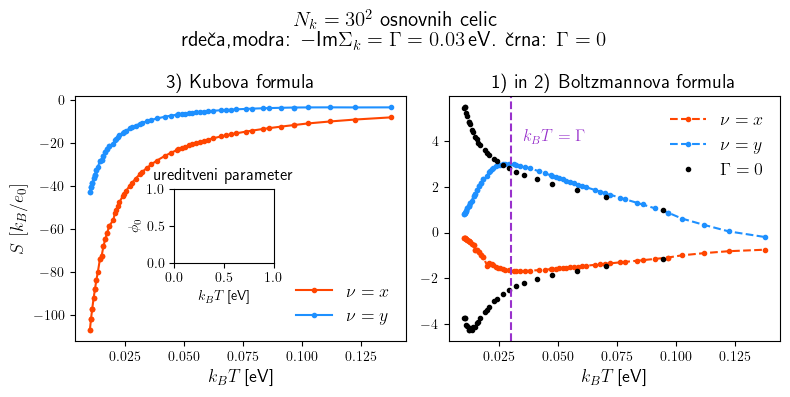

In [1243]:
col1, col2 = 'orangered', 'dodgerblue'
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].plot(np.load('ts_30.npy') , np.load('s_30_xx.npy'), '.-', color=col1, label=r'$\nu=x$')
ax[0].plot(np.load('ts_30.npy'), np.load('s_30_yy.npy'), '.-', color=col2, label=r'$\nu=y$')

ax[1].plot(np.load('ts_30.npy'), np.load('s_30_neint_xx.npy'), '.--', color=col1, label=r'$\nu=x$')
ax[1].plot(np.load('ts_30.npy'), np.load('s_30_neint_yy.npy'), '.--', color=col2, label=r'$\nu=y$')

ax[0].set_ylabel(r'$S\,\,[k_B/e_0]$', fontsize=13)
for j in range(2):
    ax[j].set_xlabel(r'$k_B T \,\text{[eV]}$', fontsize=13)

ax[1].plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_xx.npy'), '.', ms=6, color='black', label=r'$\Gamma=0$')
ax[1].plot(np.load('s_30_boltz.npy'), np.load('s_30_boltz0_yy.npy'), '.', ms=6, color='black')

ax[0].legend(frameon=False, fontsize=13)
ax[1].legend(frameon=False, fontsize=13)

ins = ax[0].inset_axes([0.3,0.32,0.3,0.3])
#Ts, phis = zip(*sorted(zip(s.Ts, s.phis)))
#ins.plot(Ts, phis, '.-')
ins.set_xlabel(r'$k_B T \,\text{[eV]}$', fontsize=10)
ins.set_ylabel(r'$\phi_0$', fontsize=10), ins.set_title(r'ureditveni parameter')

ax[0].set_title(r'3) Kubova formula', fontsize=14)
ax[1].set_title(r'1) in 2) Boltzmannova formula', fontsize=14)
ax[1].axvline(0.03, color='darkorchid', ls='dashed')
ax[1].text(0.035, 4, '$k_B T = \Gamma$', color='darkorchid', fontsize=12)
fig.suptitle(r'$N_k=30^2$ osnovnih celic' + '\n' + r'rdeča,modra: $-\text{Im}\Sigma_k = \Gamma=0.03\,\text{eV}$. črna: $\Gamma=0$', fontsize=15)
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
#plt.savefig('20-07-seebeck.png')

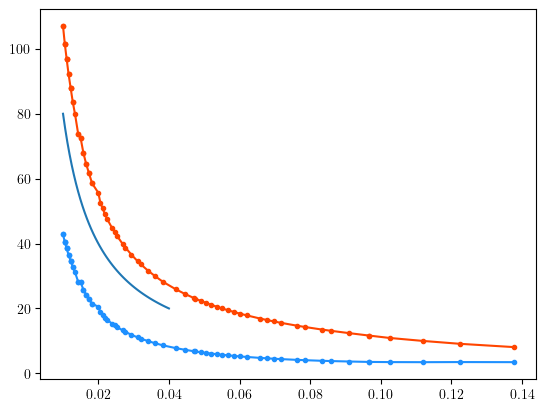

In [131]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")
plt.plot(np.load('ts_30.npy') , -np.load('s_30_xx.npy'), '.-', color=col1, label=r'$\nu=x$')
plt.plot(np.load('ts_30.npy'), -np.load('s_30_yy.npy'), '.-', color=col2, label=r'$\nu=y$')
xs = np.linspace(0.01,0.04,)
plt.plot(xs, 1/xs * 0.8)


In [173]:
omega_max = 1.3
domega = 0.01
omegas, trans = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma=Gamma, omega_max = omega_max, domega=domega)
_, transK, transI = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, s.mu, Gamma=Gamma, omega_max = omega_max, domega=domega)
_, transI_full = tokovi_drugic.transportna_I_full(s.kymesh, s.vecs, s.energije, s.fs, s.j2_matrix_full, s.j_matrix, s.mu, Gamma=Gamma, omega_max = omega_max, domega=domega)
#_, transI_full_alternative = tokovi_drugic.transportna_I_full_alternative(s.kymesh, s.vecs, s.energije, s.fs, s.j2_matrix_full, s.j_matrix, s.mu, Gamma=Gamma, omega_max = omega_max, domega=domega)

KeyboardInterrupt: 

In [ ]:
L12(phiK, phiI, phiI_full, phi, omegas, T)

(-20000.0, 300000.0)

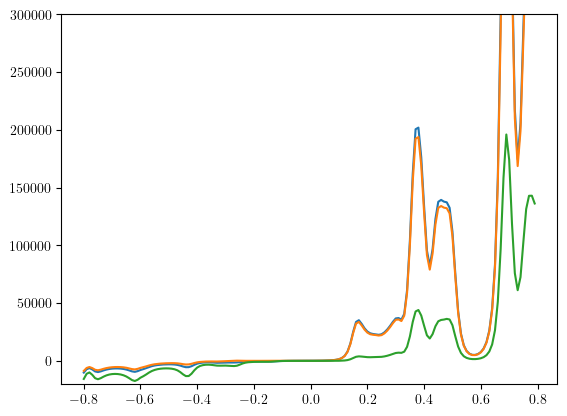

In [122]:
j = 1
#plt.plot(omegas, transK[j].real + np.einsum('ijk->ik', transI_full.real)[j] / 2)
#plt.plot(omegas, transK[j].real + transI[j].real)
#plt.plot(omegas, omegas * trans[j].real)

j=0
plt.plot(omegas, transI[j].real + transK[j].real)
plt.plot(omegas, np.einsum('ijk->ik', transI_full.real)[j] / 2 + transK[j].real)
#plt.plot(omegas, np.einsum('ijk->ik', transI_full_alternative.real)[j] / 2 + transK[j].real, '--')
plt.plot(omegas, omegas * trans[j].real)

plt.ylim(-20000,300000)

In [19]:
transI_full.real

array([[[ 1.67055588e+01,  9.76112198e+00,  5.20742409e+00, ...,
          7.48611232e-02,  6.98524813e-02,  6.62982996e-02],
        [ 8.34626725e+02,  4.88643385e+02,  2.61500213e+02, ...,
          9.64620849e+01,  1.01068378e+02,  1.07521026e+02],
        [-6.63375697e-26, -7.54334041e-26, -4.68237304e-26, ...,
         -8.44090413e-30, -1.07333771e-29, -1.32750499e-29],
        [-1.77094227e+01, -1.03350235e+01, -5.47789407e+00, ...,
         -5.89366550e-03, -5.25744492e-03, -4.71501882e-03]],

       [[ 3.59726243e+00,  2.10646537e+00,  1.12373484e+00, ...,
          5.20256965e-03,  4.78177913e-03,  4.44149582e-03],
        [-6.97914635e+00, -3.85111102e+00, -1.95770349e+00, ...,
          3.43118883e-01,  3.35783364e-01,  3.32872831e-01],
        [-9.18986217e-30, -3.47794685e-30, -2.15426820e-30, ...,
         -2.27397407e-32, -2.12554111e-32, -2.00996726e-32],
        [ 3.47254738e-15,  1.90188094e-15,  1.02370785e-15, ...,
         -7.53021877e-19, -6.42145799e-19, -5.40466

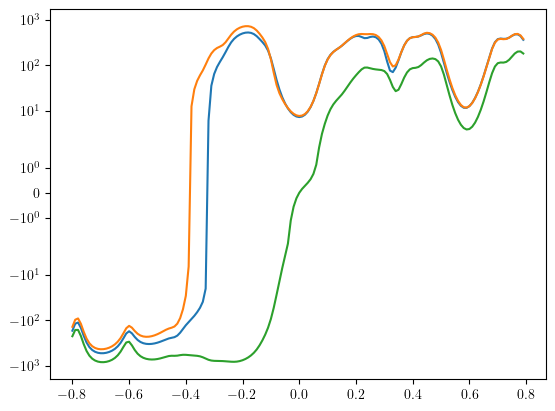

In [22]:
plt.plot(omegas, transK[1].real + transI[1].real)
plt.plot(omegas, transK[1].real + transI_full[1].real)
plt.plot(omegas, trans[1].real * omegas)
plt.yscale('symlog')
plt.show()


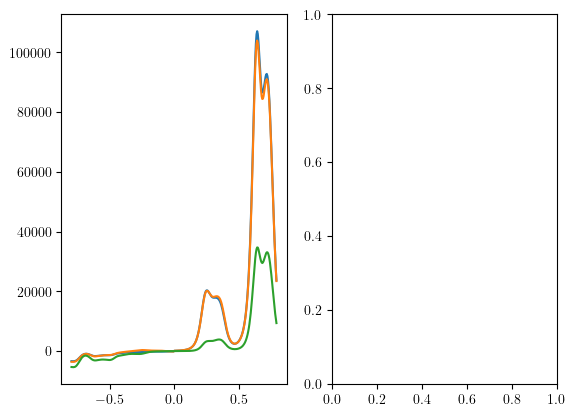

In [8]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(omegas, np.sign(omegas)*(transK[0].real + transI[0].real)) 
ax[0].plot(omegas, np.sign(omegas)*(transK[0].real + transI_full[0].real))
ax[0].plot(omegas, trans[0].real * omegas)

In [16]:
barve = np.einsum('ijkl->jkl', np.abs(s.vecs[:4, :, :, :])**2)

barve[4, 0, 0]

0.9989379670193199

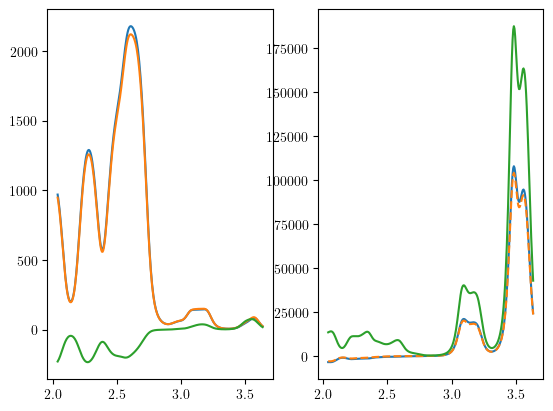

In [7]:
fig, ax = plt.subplots(ncols=2)
n = len(omegas)
ax[0].plot(omegas, -((transK[1].real + transI[1].real) - s.mu * trans[1].real )  * np.sign(omegas))
ax[0].plot(omegas, -((transK[1].real + transI_full[1].real) - s.mu * trans[1].real) * np.sign(omegas))
ax[0].plot(omegas, (trans[1].real * (omegas - s.mu) ))

ax[1].plot(omegas, np.sign(omegas)*(transK[0].real + transI[0].real))
ax[1].plot(omegas, np.sign(omegas)*(transK[0].real + transI_full[0].real), '--')
ax[1].plot(omegas, trans[0].real * omegas)


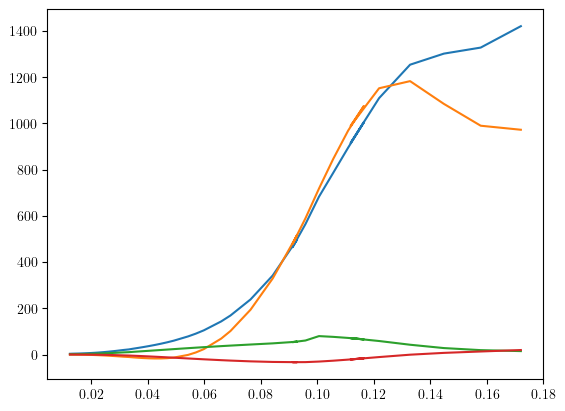

In [81]:
plt.plot(s.Ts, np.array(s.L12_k_xx).real)
plt.plot(s.Ts, np.array(s.L12_i_neint_xx).real)

plt.plot(s.Ts, np.array(s.L12_k_yy).real)
plt.plot(s.Ts, np.array(s.L12_i_neint_yy).real)


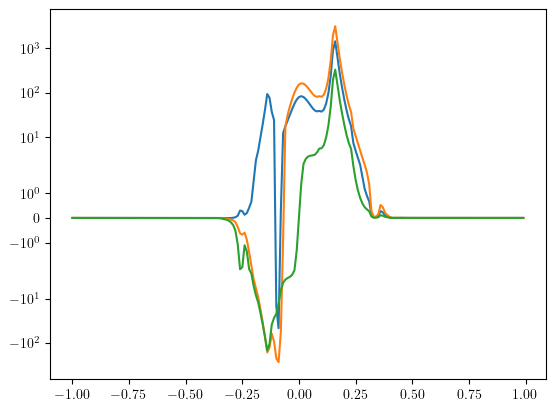

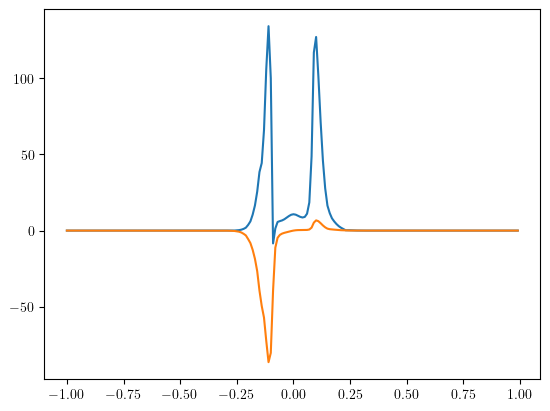

In [117]:
plt.plot(omegas, -(transI_full[0].real + transK[0].real ) * tokovi_drugic.fd_1(omegas, 0.02) )
plt.plot(omegas, -(transI[0].real + transK[0].real ) * tokovi_drugic.fd_1(omegas, 0.02) )
plt.plot(omegas, -omegas * trans[0].real* tokovi_drugic.fd_1(omegas, 0.02))

plt.yscale('symlog')
plt.show()

plt.plot(omegas, -(transI[1].real + transK[1].real ) * tokovi_drugic.fd_1(omegas, 0.02))
plt.plot(omegas, -(omegas * trans[1].real)* tokovi_drugic.fd_1(omegas, 0.02))


(-1000.0, 1000.0)

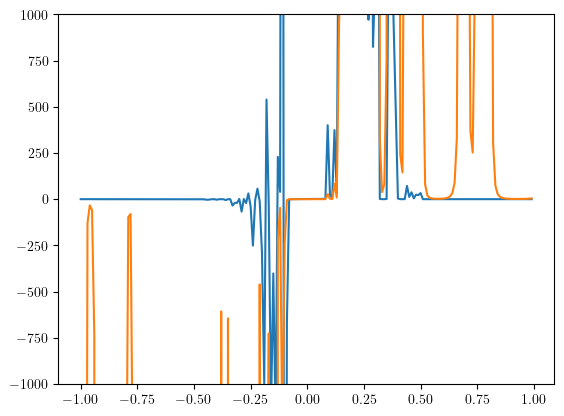

In [116]:
plt.plot(omegas - s.mu, (transK[0].real + transI[0].real) * (-tokovi_drugic.fd_1(omegas - s.mu, 0.03)))
plt.plot(omegas - s.mu, (omegas - s.mu) * trans[0].real)
plt.ylim(-1000,1000)

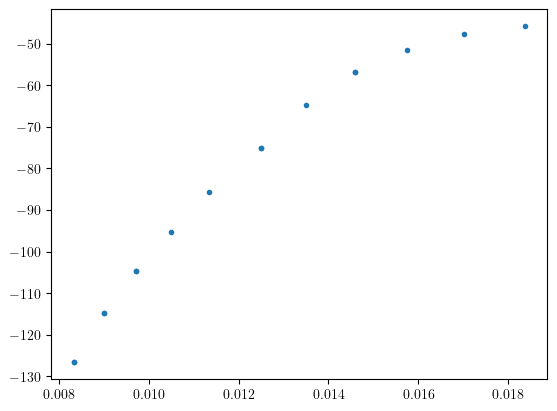

In [358]:
plt.plot(s.Ts, -(np.array(s.L12_k_xx).real + np.array(s.L12_i_xx).real)/np.array(s.L11_xx).real / np.array(s.Ts) ,'.')


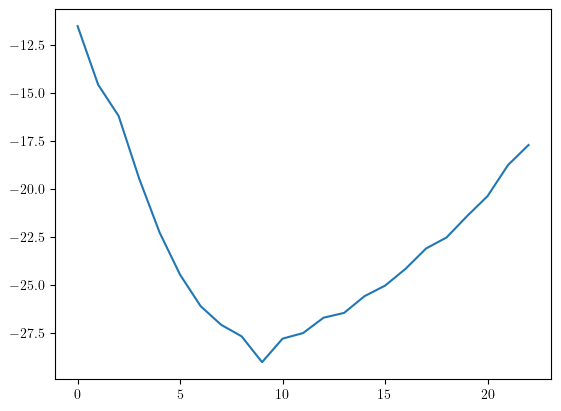

In [297]:
plt.plot(-(np.array(s.L12_k_xx).real + np.array(s.L12_i_xx).real)/np.array(s.L11_xx).real / np.array(s.Ts))

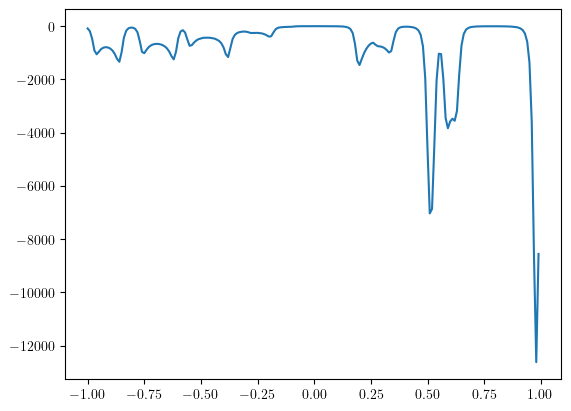

In [235]:
plt.plot(omegas, (omegas - s.mu) * trans[0].real * (omegas[1] - omegas[0]) )


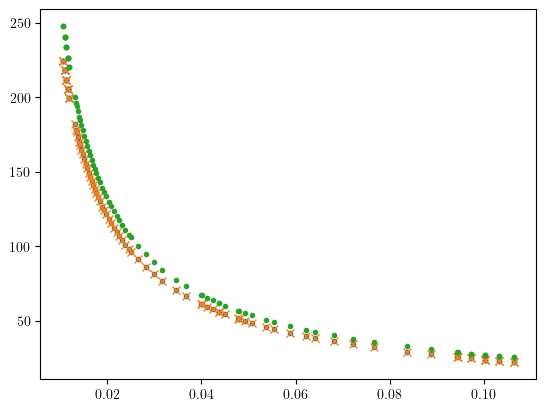

In [185]:
S_full_y = -(np.array(s.L12_k_yy).real + np.array(s.L12_i_full_yy).real - s.mus * np.array(s.L11_yy).real)/np.array(s.L11_yy).real / s.Ts
S_y = -(np.array(s.L12_k_yy).real + np.array(s.L12_i_full_yy).real - s.mus * np.array(s.L11_yy).real)/np.array(s.L11_yy).real / s.Ts
S_neint_y = -(np.array(s.L12_k_yy).real + np.array(s.L12_i_neint_yy).real - s.mus * np.array(s.L11_yy).real)/np.array(s.L11_yy).real / s.Ts

plt.plot(s.Ts, S_full_y, '.')
plt.plot(s.Ts, S_y, 'x')
plt.plot(s.Ts, S_neint_y, '.')

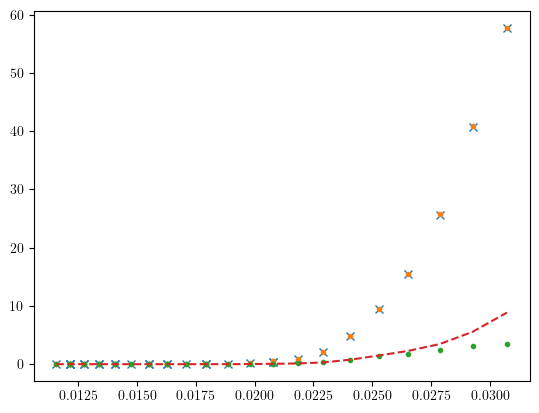

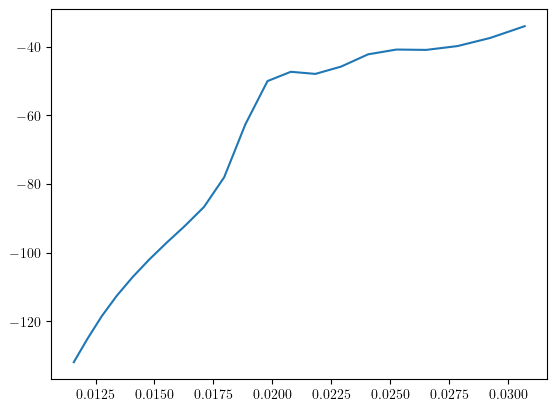

In [68]:
plt.plot(s.Ts, np.array(s.L12_i_full_xx).real , 'x')
plt.plot(s.Ts, np.array(s.L12_i_xx).real, '.')
plt.plot(s.Ts, np.array(s.L12_i_neint_xx).real, '.')
plt.plot(s.Ts, np.array(s.L12_k_xx).real, '--')
plt.show()
plt.plot(s.Ts, -np.array(s.L12_i_full_xx).real / np.array(s.L11_xx).real / s.Ts)

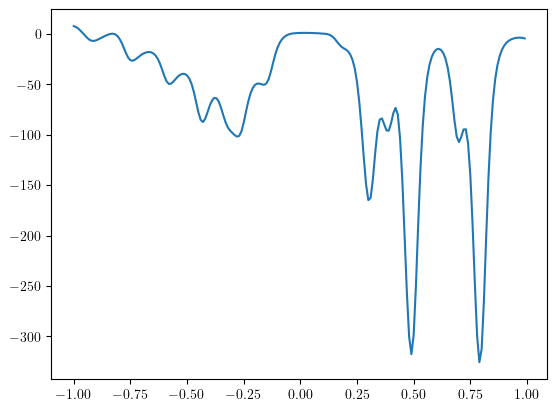

In [43]:
plt.plot(omegas, phi1[0].real - phi2[0].real)


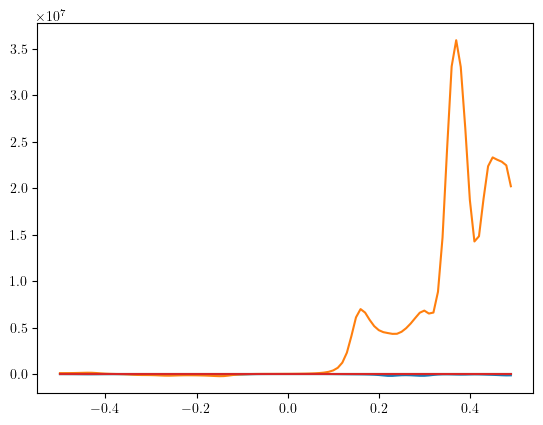

In [479]:
plt.plot(omegas, transI_full_alternative[0,0,:].real)
plt.plot(omegas, transI_full_alternative[0,1,:].real)
plt.plot(omegas, transI_full_alternative[0,2,:].real)
plt.plot(omegas, transI_full_alternative[0,3,:].real)

In [637]:
omegas, trans = tokovi_drugic.transportna_phi(s.kymesh, s.vecs, s.energije, s.j_matrix, s.mu, Gamma=0.04, domega=0.01, omega_max=0.5)
omegas, transK, transI = tokovi_drugic.transportna_phiE(s.kymesh, s.vecs, s.energije, s.j_matrix, s.j1_matrix, s.j2_matrix, s.mu, Gamma=0.04, domega=0.01, omega_max=0.5)

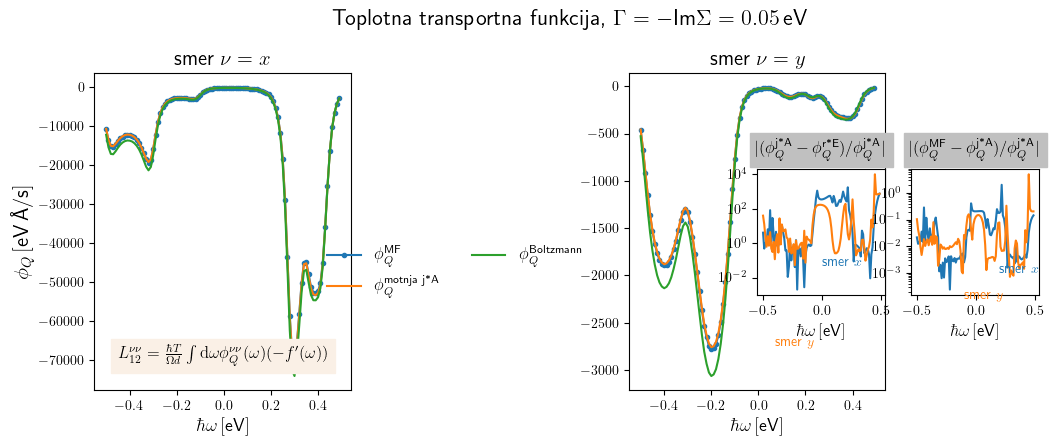

In [639]:
fig, ax = plt.subplots(ncols=2, figsize=(11.5,4.5))
ins = ax[1].inset_axes([0.5,0.3,0.5,0.4])
ins2 = ax[1].inset_axes([1.1,0.3,0.5,0.4])

hbar = 6.56*1e-16# eV * s
volume = s.Nk * a * b
kb = 8.6 * 1e-5
labs = ['smer $x$', 'smer $y$']
#predfaktor = s.Ts[-1] / kb * hbar / volume / 2 * 1e20  * 1e-10


for j in range(2):
    ax[j].plot(omegas, (transI[j].real/4 + transK[j].real - s.mu * trans[j].real), '.-', label=r'$\phi_Q^{\text{MF}}$')
    ax[j].plot(omegas, ((np.einsum('ij->j', transI_full2[j,:,:]).real) /2/ s.Nk + transK[j].real - s.mu * trans[j].real), label=r'$\phi_Q^{\text{motnja j*A}}$')
    #ax[j].plot(omegas, ((np.einsum('ij->j', transI_full2[j,:,:]).real) /2/ s.Nk + transK[j].real - s.mu * trans[j].real), label=r'$\phi_Q^{\text{motnja j*A}}$')
#ax[j].plot(omegas, ((np.einsum('ij->j', transI_full_alternative[j,:,:]).real) / 2/s.Nk + transK[j].real - s.mu * trans[j].real), ls='dashed', label=r'$\phi_Q^{\text{motnja r*E}}$')
    ax[j].plot(omegas, ((omegas - s.mu) * trans[j].real), label=r'$\phi_Q^{\text{Boltzmann}}$')
    ax[j].set_xlabel(r'$\hbar\omega\,[\text{eV}]$', fontsize=13)
    ins.plot(omegas, np.abs((np.einsum('ij->j', transI_full_alternative[j,:,:]).real - (np.einsum('ij->j', transI_full[j,:,:]).real)) / ((np.einsum('ij->j', transI_full[j,:,:]).real))), label=labs[j])

    ins2.plot(omegas, np.abs((transI[j].real - np.einsum('ij->j', transI_full[j,:,:]).real / s.Nk)/(np.einsum('ij->j', transI_full[j,:,:]).real)))
ins.set_yscale('log')
ax[0].legend(frameon=False, fontsize=12, bbox_to_anchor=(0.85,0.5),ncols=2)
ins.text(0.,1e-2*5,'smer $x$', color='tab:blue')
ins.text(-0.4,1e-6, 'smer $y$', color='tab:orange')
ins.set_xlabel(r'$\hbar\omega\,[\text{eV}]$', fontsize=12)
ins.set_title(r'$|(\phi_Q^\text{j*A} - \phi_Q^\text{r*E})/\phi_Q^{\text{j*A}}|$', backgroundcolor='silver', pad=10)

ax[0].set_title(r'smer $\nu=x$', fontsize=15)
ax[1].set_title(r'smer $\nu=y$', fontsize=15)

ax[0].text(-0.45,-70000, r"$L_{12}^{\nu\nu}=\frac{\hbar T}{\Omega d} \int \dd \omega \phi_Q^{\nu\nu}(\omega)(-f'(\omega))$", backgroundcolor='linen', fontsize=12)
ax[0].set_ylabel(r'$\phi_Q\,[\text{eV\,\AA/s}]$', fontsize=15)

ins2.set_title(r'$|(\phi_Q^\text{MF} - \phi_Q^\text{j*A})/\phi_Q^{\text{j*A}}|$', backgroundcolor='silver', pad=10)
ins2.set_xlabel(r'$\hbar\omega\,[\text{eV}]$', fontsize=12)
ins2.text(0.2,1e-3,'smer $x$', color='tab:blue')
ins2.text(-0.1,1e-4, 'smer $y$', color='tab:orange')

#predfaktor = s.Ts[-1] / kb * hbar / volume / 2 * 1e20
ins2.set_yscale('log')

fig.suptitle(r'Toplotna transportna funkcija, $\Gamma=-\text{Im}\Sigma = 0.05\,\text{eV}$ ', fontsize=16)
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")

#plt.savefig('18-07-2.png')

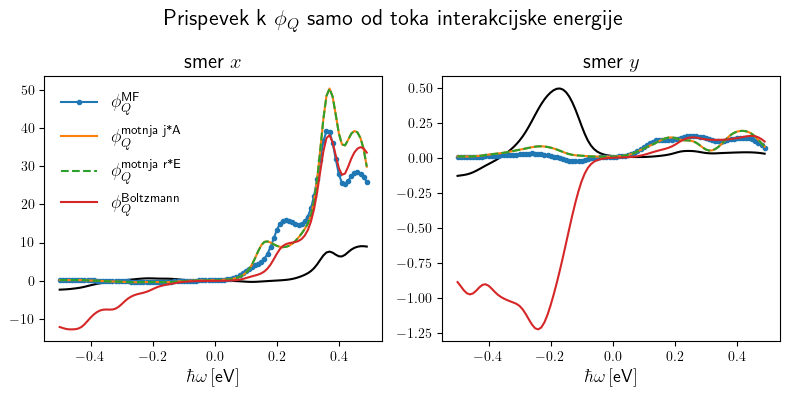

In [619]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
for j in range(2):
    ax[j].plot(omegas, transK[j].real / 30**2, color='black')
    ax[j].plot(omegas, 1/4*transI[j].real / 30**2,  '.-', label=r'$\phi_Q^{\text{MF}}$')
    ax[j].plot(omegas, (np.einsum('ij->j', transI_full[j,:,:]).real) / 2/20**2  /20**2, label=r'$\phi_Q^{\text{motnja j*A}}$')
    ax[j].plot(omegas, (np.einsum('ij->j', transI_full_alternative[j,:,:]).real) / 2/20**2 / 20**2 , label=r'$\phi_Q^{\text{motnja r*E}}$', ls='dashed')
    ax[j].plot(omegas, ((omegas)* trans[j].real) / 30**2, label=r'$\phi_Q^{\text{Boltzmann}}$')
    ax[j].set_xlabel(r'$\hbar\omega\,[\text{eV}]$', fontsize=13)
ax[0].legend(frameon=False, fontsize=13, ncols=1)
ax[0].set_title(r'smer $x$', fontsize=15)
ax[1].set_title(r'smer $y$', fontsize=15)
fig.suptitle(r'Prispevek k $\phi_Q$ samo od toka interakcijske energije', fontsize=16)
#ax[0].text(-0.2,-3000,'prispevek od toka kinetične energije')
plt.tight_layout()
#plt.savefig('18-07-3.png')

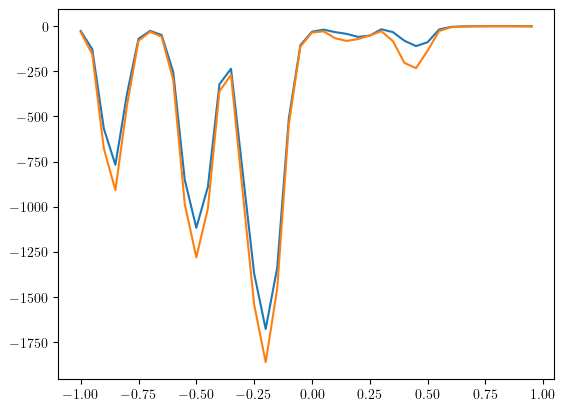

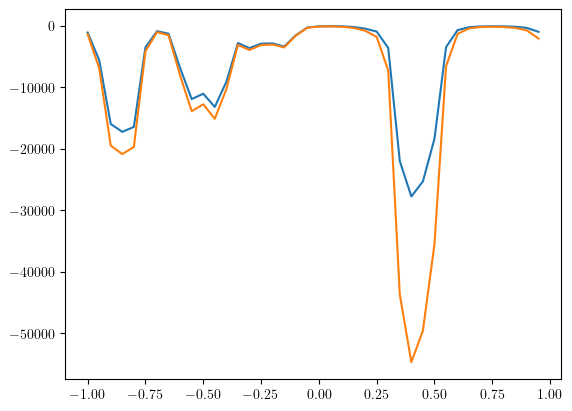

In [84]:
plt.plot(omegas, transK[1].real + transI[1].real - s.mu * trans[1].real)
plt.plot(omegas, trans[1].real * (omegas - s.mu))
plt.show()
plt.plot(omegas, transK[0].real + transI[0].real - s.mu * trans[0].real)
plt.plot(omegas, trans[0].real * (omegas - s.mu))

In [ ]:

plt.plot(omegas, transI[0].real)
plt.plot(omegas, transK[0].real)

plt.plot(omegas, transI[0].real + transK[0].real)

plt.show()


plt.plot(omegas, transI[1].real)
plt.plot(omegas, transK[1].real)

plt.plot(omegas, transI[1].real + transK[1].real)

NameError: name 'omegas' is not defined

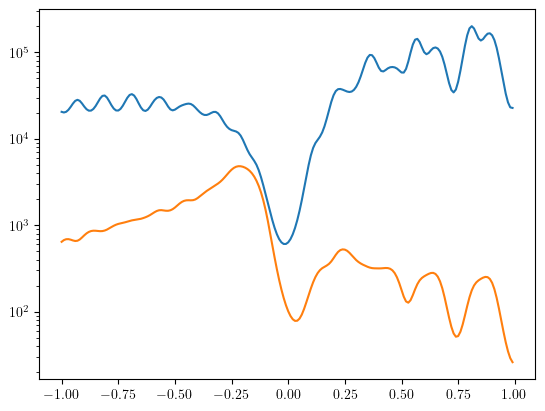

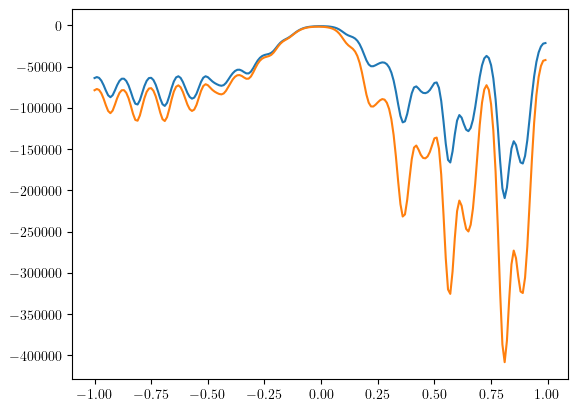

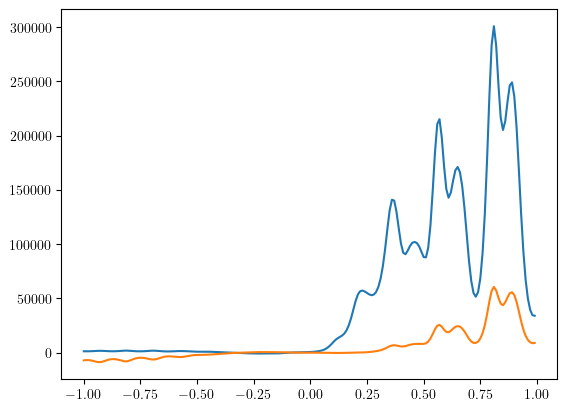

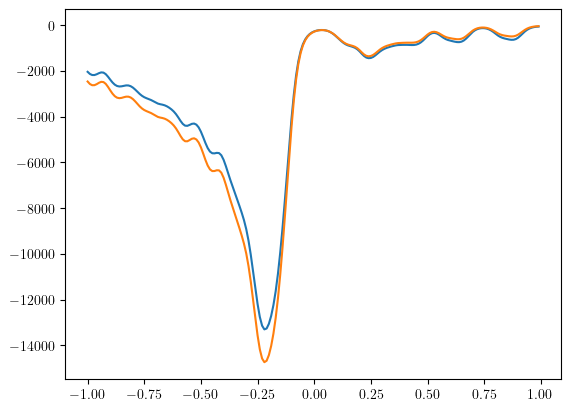

In [ ]:
plt.plot(omegas, trans[0].real)
plt.plot(omegas, trans[1].real)
plt.yscale('log')
plt.show()
plt.plot(omegas, transK[0].real  + transI[0].real - s.mu * trans[0].real)
plt.plot(omegas, trans[0].real * (omegas - s.mu))
plt.show()

plt.plot(omegas, transI[0].real)
plt.plot(omegas, transK[0].real)

plt.show()

#plt.yscale('log')
plt.show()
plt.plot(omegas, transK[1].real - s.mu * trans[1].real)
plt.plot(omegas, trans[1].real * (omegas - s.mu))

plt.show()

In [ ]:
'''np.save('Ts1407_2.npy', s.Ts)
np.save('phis1407_2.npy', s.phi)
np.save('Sx1407_2.npy', s.S_x)
np.save('Sy1407_2.npy', s.S_y)'''

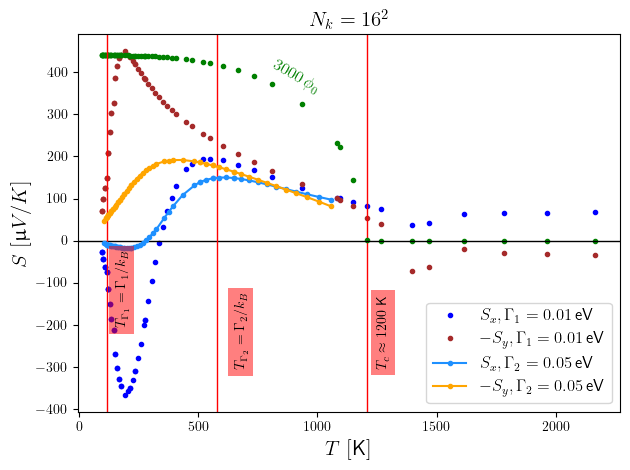

In [ ]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
Ts, S_x, S_y, phis = np.load('Ts1407.npy'), np.load('Sx1407.npy'), np.load('Sy1407.npy'), np.load('phis1407.npy')
plt.plot(np.array(Ts) / (8.617333262 * 1e-5), np.array(S_x) *8.617333262 * 1e-5 * 1e6, '.', label=r'$S_x, \Gamma_1=0.01\,\text{eV}$', color='blue')
plt.plot(np.array(Ts) / (8.617333262 * 1e-5), -np.array(S_y) * 8.617333262 * 1e-5 * 1e6, '.', label=r'$-S_y, \Gamma_1=0.01\,\text{eV}$', color='brown')
plt.xlabel(r'$T\,\,[\text{K}]$', fontsize=15)
plt.ylabel(r'$S\,\,[\upmu V/K]$', fontsize=15)
plt.axvline(1206.2479865893392, color='red', lw=1)

plt.plot(np.array(Ts) / (8.617333262 * 1e-5), np.array(phis) * 3000, '.', color='green')
plt.text(800,350, r'$3000\,\phi_0$', color='green', fontsize=12, rotation=-30)
plt.axhline(0, color='black', lw=1)

plt.axvline(0.01/(8.617333262 * 1e-5), color='red', lw=1)
plt.axvline(0.05/(8.617333262 * 1e-5), color='red', lw=1)

plt.title(r'$N_k=16^2$', fontsize=15)
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")


plt.plot(np.array(s.Ts)/(8.617333262 * 1e-5), np.array(s.S_x) *8.617333262 * 1e-5 * 1e6, '.-', color='dodgerblue', label=r'$S_x, \Gamma_2=0.05\,\text{eV}$')
plt.plot(np.array(s.Ts)/(8.617333262 * 1e-5), -np.array(s.S_y) *8.617333262 * 1e-5 * 1e6, '.-', color='orange', label=r'$-S_y, \Gamma_2=0.05\,\text{eV}$')
t=plt.text(150, -200, r'$T_{\Gamma_1}=\Gamma_1/k_B$', color='black', rotation=90, fontsize=10, zorder=10000)
t.set_bbox(dict(facecolor='red', alpha=0.5, linewidth=0))
t=plt.text(650, -300, r'$T_{\Gamma_2}=\Gamma_2/k_B$', color='black', rotation=90, fontsize=10, zorder=10000)
t.set_bbox(dict(facecolor='red', alpha=0.5, linewidth=0))

t=plt.text(1250, -300, r'$T_c\approx 1200\,\,\text{K}$', color='black', rotation=90, fontsize=10, zorder=10000)
t.set_bbox(dict(facecolor='red', alpha=0.5, linewidth=0))

plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig('14-07.png')

In [ ]:
plt.plot(np.load('betas_10.npy'), np.load('phis_10.npy'), '.-')
plt.plot(np.load('betas_20.npy'), np.load('phis_20.npy'), '.-')
plt.plot(np.load('betas_30.npy'), np.load('phis_30.npy'), 'x')

plt.plot(s.betas, s.phis)

FileNotFoundError: [Errno 2] No such file or directory: 'betas_10.npy'

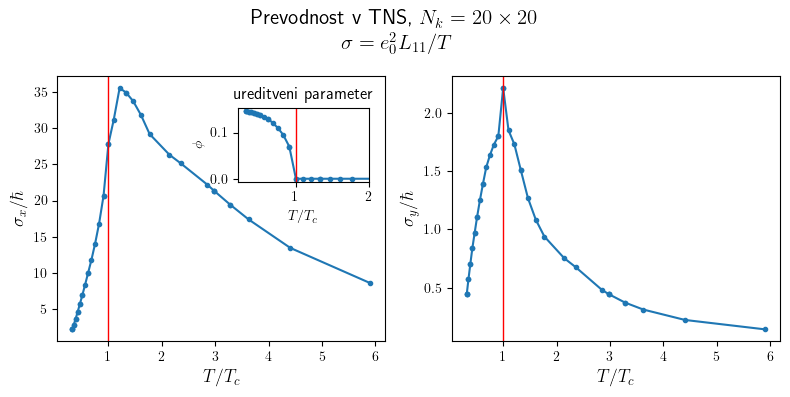

In [ ]:
e0 = 1.602*1e-19
hbar = 6.58 * 1e-16
kb = 8.617 * 1e-5

tc = s.Ts[np.argmax(s.kubo_L1_yy)]
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].plot(np.array(s.Ts)/tc,  2*np.array(s.kubo_L1_xx) / (Ny*Nx*a*b) / np.array(s.Ts), '.-')
ax[1].plot(np.array(s.Ts)/tc, 2*np.array(s.kubo_L1_yy) / (Ny*Nx*a*b)  / np.array(s.Ts),  '.-')

for j in range(2):
    ax[j].set_xlabel(r'$T/T_c$', fontsize=13)
ins = ax[0].inset_axes([0.55,0.6,0.4,0.28])
ins.set_title(r'ureditveni parameter')
ins.plot(s.Ts/tc, s.phis, '.-'), ins.set_xlabel(r'$T/T_c$')
ins.set_ylabel(r'$\phi$')#, ins.set_xlim(0.025,0.2)
ax[0].set_ylabel(r'$\sigma_x / \hbar$', fontsize=13)
ax[1].set_ylabel(r'$\sigma_y / \hbar$', fontsize=13)
fig.suptitle(r'Prevodnost v TNS, $N_k=20\times 20$' + '\n' + r'$\sigma=e_0^2 L_{11} / T$', fontsize=15)
ins.set_xlim(0.2,2)
ax[0].axvline(1, lw=1, color='r')
ax[1].axvline(1, lw=1, color='r')
ins.axvline(1, lw=1, color='r')
plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")
plt.savefig('prevodnost-03-07.png')

(0.0, 1.3)

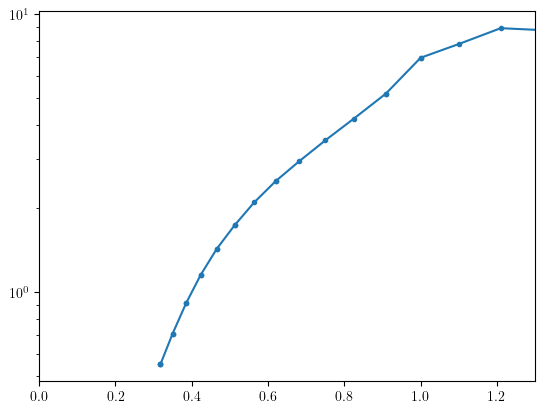

In [ ]:
s.kubo_L1

In [ ]:
(6.582 * 1e-16 * 3 * 1e8)**2/(0.511*1e6 * (0.529*1e-10*13.6/10/0.025)**2)

0.009213575982961507

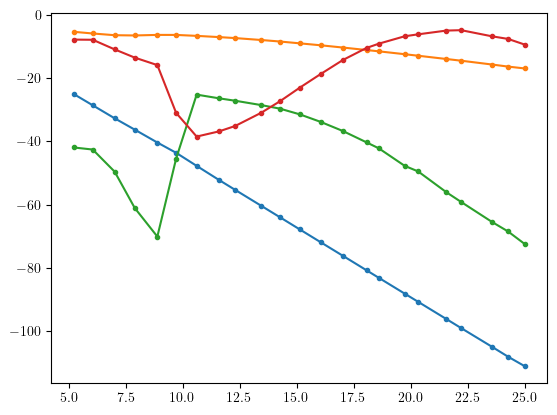

In [ ]:
#plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.kubo_L1_yx).real / np.array(s.kubo_L0_yx).real , '.-')
plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.kubo_L1_xx).real / np.array(s.kubo_L0_xx).real , '.-')
plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.kubo_L1_yy).real / np.array(s.kubo_L0_yy).real , '.-')
plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.kubo_L1_yx).real / np.array(s.kubo_L0_yx).real , '.-')
plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.kubo_L1_xy).real / np.array(s.kubo_L0_xy).real , '.-')

#plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.boltzmann_L1_yy).real / np.array(s.boltzmann_L0_yy).real , '.-')

#plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_xy).real/np.array(s.kubo_L0_xy).real * np.array(s.betas), '.-')
#plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_yx).real/np.array(s.kubo_L0_yx).real * np.array(s.betas), '.-')

plt.show()
#plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.boltzmann_L1_xy)[1:].real / np.array(s.boltzmann_L0_xy)[1:].real , '.-')
#plt.plot(np.array(s.betas), - np.array(s.betas) * np.array(s.boltzmann_L1_xx)[1:].real / np.array(s.boltzmann_L0_xx)[1:].real , '.-')


In [ ]:
plt.show()
plt.plot(1/np.array(s.betas), -np.array(s.boltzmann_L1_xx).real/np.array(s.boltzmann_L0_xx).real * np.array(s.betas), '.-')
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_xx).real/np.array(s.kubo_L0_xx).real * np.array(s.betas), '.-')

plt.show()
plt.plot(s.betas, s.phis, '.-')

plt.show()
plt.plot(1/np.array(s.betas), -np.array(s.boltzmann_L1_yy).real/np.array(s.boltzmann_L0_yy).real * np.array(s.betas), '.-')


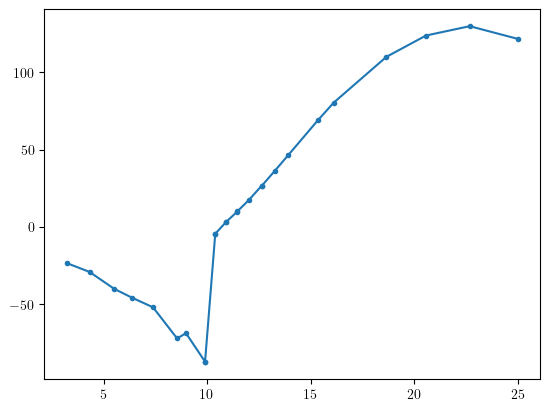

In [ ]:
#plt.plot(np.array(s.betas), -np.array(s.boltzmann_L1_xx).real/np.array(s.boltzmann_L0_xx).real * np.array(s.betas), '.-')
plt.plot(np.array(s.betas), -np.array(s.kubo_L1_xy).real/np.array(s.kubo_L0_xy).real * np.array(s.betas), '.-')


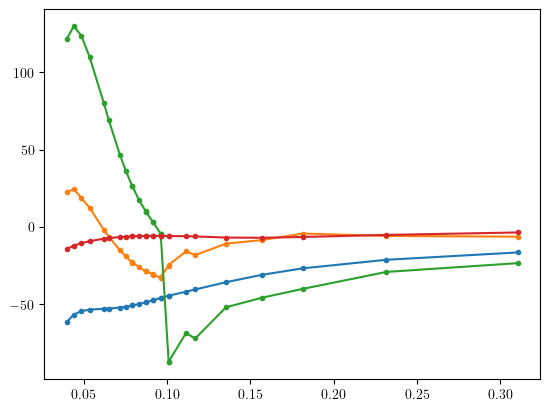

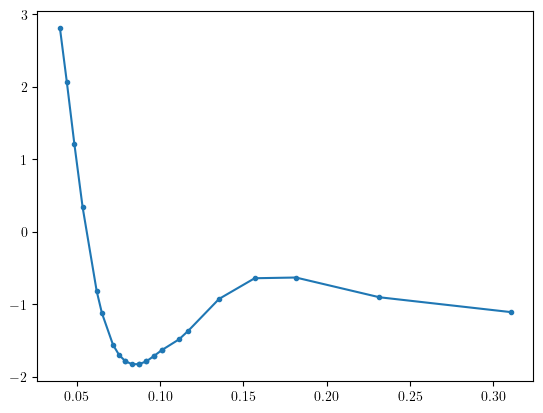

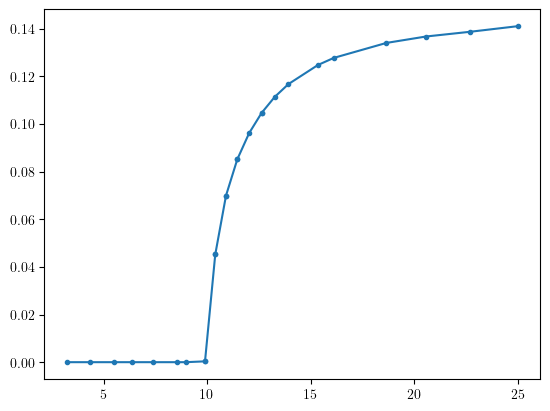

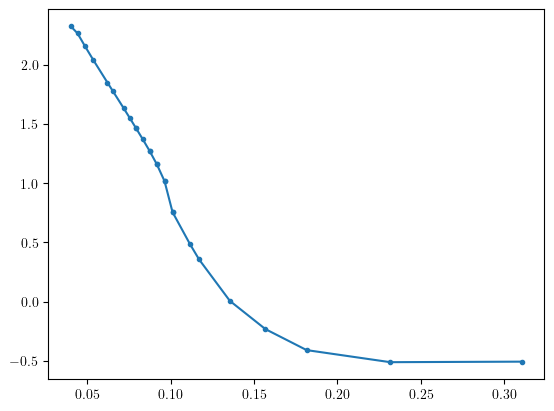

In [ ]:
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_xx).real/np.array(s.kubo_L0_xx).real * np.array(s.betas), '.-')
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_yy).real/np.array(s.kubo_L0_yy).real * np.array(s.betas), '.-')
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_xy).real/np.array(s.kubo_L0_xy).real * np.array(s.betas), '.-')
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_yx).real/np.array(s.kubo_L0_yx).real * np.array(s.betas), '.-')
plt.show()
plt.plot(1/np.array(s.betas), -np.array(s.boltzmann_L1_xx).real/np.array(s.boltzmann_L0_xx).real * np.array(s.betas), '.-')
plt.plot(1/np.array(s.betas), -np.array(s.kubo_L1_xx).real/np.array(s.kubo_L0_xx).real * np.array(s.betas), '.-')

plt.show()
plt.plot(s.betas, s.phis, '.-')

plt.show()
plt.plot(1/np.array(s.betas), -np.array(s.boltzmann_L1_yy).real/np.array(s.boltzmann_L0_yy).real * np.array(s.betas), '.-')


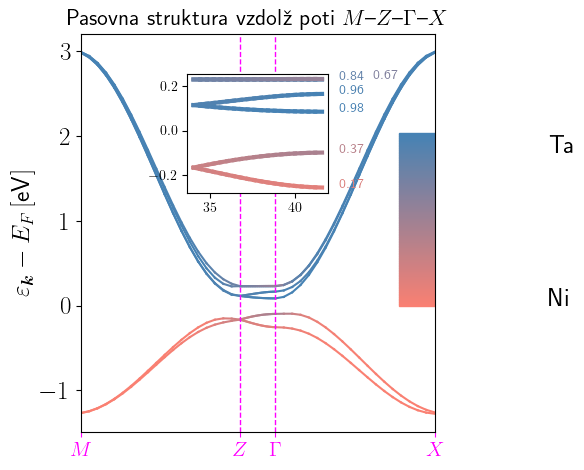

In [ ]:
fig, ax = plt.subplots()

energije = s.energije
barve = np.einsum('ijkl->jkl', np.abs(s.vecs[:4, :, :, :])**2)
col1, col2 = 'salmon', 'steelblue'
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

# Gamma - X
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + (Ny//2-1)*2*np.pi/b + np.arange(Nx//2)*2*np.pi/a
    E = energije[i, Ny//2, Nx//2:]
    for g in range(0,len(K)-1):
        col = np.mean(barve[i, Ny//2, Nx//2:][g:g+2])
        plt.plot(K[g:g+2], E[g:g+2]- s.mu, color=colorFader(col1, col2, col))

# Z - Gamma
E_c, E_v = np.max(energije[:Ny//2, Nx//2]), np.min(energije[:Ny//2, Nx//2])
gap = E_c - E_v
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + np.arange(Ny//2)*2*np.pi/b
    E = energije[i, :Ny//2, Nx//2]
    for g in range(0,len(K)-1):#)len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])
        plt.plot(K[g:g+2], E[g:g+2]- s.mu, color=colorFader(col1, col2, col))

# Z - M
for i in range(6):
    K = np.arange(Nx//2)*2*np.pi/a
    E = energije[i, 0, Nx//2:][::-1]
    for g in range(0,len(K)-1):
        col = np.mean(barve[i, 0, Nx//2:][::-1][g:g+2])
        plt.plot(K[g:g+2], E[g:g+2] - s.mu, color=colorFader(col1, col2, col))

ax.set_xticks([0, (Nx//2 -1)*2*np.pi/a, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a],)# color='magenta')
ax.set_xticklabels(['$M$', '$Z$', r'$\Gamma$', '$X$'])

ax.set_xlim([0, (Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b + (Nx//2-1)*2*np.pi/a])
ax.tick_params(axis='x', colors='magenta')

plt.axvline((Nx//2 -1)*2*np.pi/a, ls='dashed', lw=1, color='magenta')
plt.axvline((Nx//2 -1)*2*np.pi/a + (Ny//2 - 1)*2*np.pi/b, ls='dashed', lw=1, color='magenta')

plt.xticks(fontsize=15), plt.yticks(fontsize=18)
plt.ylabel(r'$\varepsilon_{\bm{k}} - E_F\,[\text{eV}]$', fontsize=18)

for n in range(101):
    ax.axhspan(2*n/99, 2*(n+1)/99, 0.9, 1, color=colorFader(col1, col2, n/100))
ax.text(100,0,'Ni', fontsize=18)
ax.text(100,1.8,'Ta', fontsize=18)

ins = ax.inset_axes([0.3,0.6,0.4,0.3])
# Z - Gamma
E_c, E_v = np.max(energije[:Ny//2, Nx//2]), np.min(energije[:Ny//2, Nx//2])
gap = E_c - E_v
for i in range(6):
    K = (Nx//2-1)*2*np.pi/a + np.arange(Ny//2)*2*np.pi/b
    E = energije[i, :Ny//2, Nx//2]
    m = np.mean(barve[i, :Ny//2, Nx//2])
    if i != 5: ins.text(K[-1]+1, E[-1] - s.mu, f'{np.round(m,2)}', color=colorFader(col1, col2, m))
    else: ins.text(K[-1]+3, E[-1] - s.mu, f'{np.round(m,2)}', color=colorFader(col1, col2, m))
    for g in range(0,len(K)-1):#)len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])
        ins.plot(K[g:g+2], E[g:g+2]- s.mu, color=colorFader(col1, col2, col), lw=3)

plt.title(r'Pasovna struktura vzdolž poti $M$--$Z$--$\Gamma$--$X$', fontsize=16)
plt.tight_layout()
plt.savefig('pot.png')

C:\Users\anast\AppData\Local\Temp\ipykernel_43520\1164709945.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\anast\AppData\Local\Temp\ipykernel_43520\1164709945.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('struktura.png')
c:\Users\anast\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


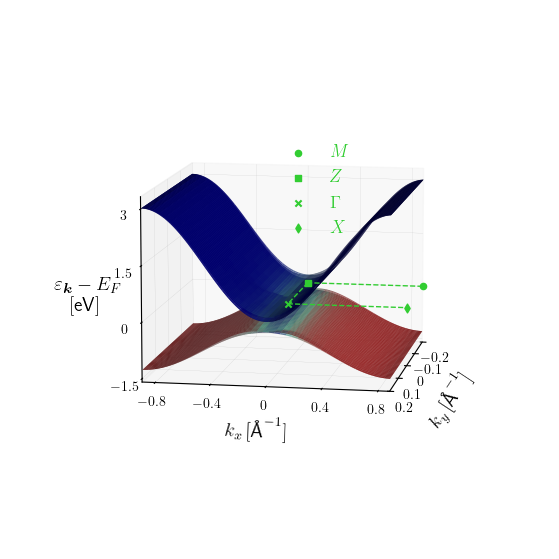

In [43]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axis3d as axis3d
plt.rcParams['grid.linewidth'] = 0.1

fig = plt.figure(figsize=(12,7), facecolor='white')
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
colors = sns.color_palette("gist_earth", 6)

colors = [matplotlib.colors.to_rgb(col1), matplotlib.colors.to_rgb(col2), matplotlib.colors.to_rgb(col3)] # first color is black, last is red
com = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)

for i in range(6):
    mycol = com(barve[i,:,:]/np.amax(barve[i,:,:]))
    ax.plot_surface(s.kymesh, s.kxmesh, energije[i,:,:] - s.mu, alpha=0.7, zorder=-1000000, facecolors=mycol, linewidth=0,)


ax.set_xlabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14, labelpad=15)
ax.set_ylabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14, labelpad=15)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\varepsilon_{\bm{k}}-E_F$' + '\n' + r'$[\text{eV}]$', fontsize=14, labelpad=15)



ax.set_xticks([-0.2,-0.1,0,0.1,0.2])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_zticks([-1.5,0,1.5,3])

Gamma = [s.kymesh[:,0][Ny//2], s.kxmesh[0][Nx//2]]
M = [s.kymesh[:,0][0], s.kxmesh[0][Nx-1]]
Z = [s.kymesh[:,0][0], s.kxmesh[0][Nx//2]]
X = [s.kymesh[:,0][Ny//2], s.kxmesh[0][Nx-1]]

ax.scatter(M[0], M[1], marker='o', color='limegreen', zorder=10000, label='$M$')
ax.scatter(Z[0], Z[1], marker='s', color='limegreen', zorder=10000, label='$Z$')
ax.scatter(Gamma[0], Gamma[1], marker='x', color='limegreen', zorder=10000, label=r'$\Gamma$')
ax.scatter(X[0], X[1], marker='d', color='limegreen', zorder=100000, label='$X$')

ax.plot([M[0], Z[0]], [M[1], Z[1]], color='limegreen', zorder=100, lw=1, ls='dashed')
ax.plot([Z[0], Gamma[0]], [Z[1], Gamma[1]], color='limegreen', zorder=100, lw=1, ls='dashed')
ax.plot([Gamma[0], X[0]], [Gamma[1], X[1]], color='limegreen', zorder=100, lw=1, ls='dashed')


ax.set_ylim(s.kxmesh[0][0], s.kxmesh[0][-1])
ax.set_xlim(s.kymesh[:,0][0], s.kymesh[:,0][-1])

ax.legend(bbox_to_anchor=(0.47,0.55), frameon=False, fontsize=14,prop={'size':13},labelcolor='linecolor')
ax.set_box_aspect(aspect=None, zoom=0.7)

ax.azim = 10
ax.dist = 10
ax.elev = 10

ax.set_xticks([-0.2,-0.1,0,0.1,0.2])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_zticks([-1.5,0,1.5,3])

ax.set_xticklabels([rf'${u}$' for u in [-0.2,-0.1,0,0.1,0.2]], fontsize=10)
ax.set_yticklabels([rf'${u}$' for u in [-0.8,-0.4,0,0.4,0.8]], fontsize=10)
ax.set_zticklabels([rf'${u}$' for u in [-1.5,0,1.5,3]], fontsize=10)

#plt.title(r'Elektronska pasovna struktura \ce{Ta2NiSe5} v osnovnem stanju', fontsize=18)
plt.tight_layout()

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
plt.savefig('struktura.png')

NameError: name 'matplotlib' is not defined

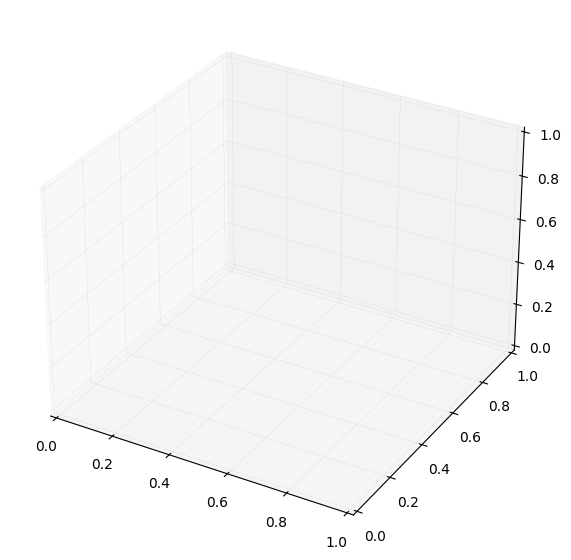

In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axis3d as axis3d
plt.rcParams['grid.linewidth'] = 0.1

fig = plt.figure(figsize=(12,7), facecolor='white')
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
colors = sns.color_palette("gist_earth", 6)

colors = [matplotlib.colors.to_rgb(col1), matplotlib.colors.to_rgb(col2), matplotlib.colors.to_rgb(col3)] # first color is black, last is red
com = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)

for i in [0,5]:
    mycol = com(barve[i,:,:]/np.amax(barve[i,:,:]))
    ax.plot_surface(s.kymesh, s.kxmesh, energije[i,:,:] - s.mu, alpha=0.7, zorder=-1000000, facecolors=mycol, linewidth=0,)


ax.set_xlabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=14, labelpad=15)
ax.set_ylabel(r'$k_x\,[\text{\AA}^{-1}]$', fontsize=14, labelpad=15)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\varepsilon_{\bm{k}}-E_F$' + '\n' + r'$[\text{eV}]$', fontsize=14, labelpad=15)



ax.set_xticks([-0.2,-0.1,0,0.1,0.2])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_zticks([-1.5,0,1.5,3])

Gamma = [s.kymesh[:,0][Ny//2], s.kxmesh[0][Nx//2]]
M = [s.kymesh[:,0][0], s.kxmesh[0][Nx-1]]
Z = [s.kymesh[:,0][0], s.kxmesh[0][Nx//2]]
X = [s.kymesh[:,0][Ny//2], s.kxmesh[0][Nx-1]]

ax.scatter(M[0], M[1], marker='o', color='limegreen', zorder=10000, label='$M$')
ax.scatter(Z[0], Z[1], marker='s', color='limegreen', zorder=10000, label='$Z$')
ax.scatter(Gamma[0], Gamma[1], marker='x', color='limegreen', zorder=10000, label=r'$\Gamma$')
ax.scatter(X[0], X[1], marker='d', color='limegreen', zorder=100000, label='$X$')

ax.plot([M[0], Z[0]], [M[1], Z[1]], color='limegreen', zorder=100, lw=1, ls='dashed')
ax.plot([Z[0], Gamma[0]], [Z[1], Gamma[1]], color='limegreen', zorder=100, lw=1, ls='dashed')
ax.plot([Gamma[0], X[0]], [Gamma[1], X[1]], color='limegreen', zorder=100, lw=1, ls='dashed')


ax.set_ylim(s.kxmesh[0][0], s.kxmesh[0][-1])
ax.set_xlim(s.kymesh[:,0][0], s.kymesh[:,0][-1])

ax.legend(bbox_to_anchor=(0.47,0.55), frameon=False, fontsize=14,prop={'size':13},labelcolor='linecolor')
ax.set_box_aspect(aspect=None, zoom=0.7)

ax.azim = 10
ax.dist = 10
ax.elev = 10

ax.set_xticks([-0.2,-0.1,0,0.1,0.2])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_zticks([-1.5,0,1.5,3])

ax.set_xticklabels([rf'${u}$' for u in [-0.2,-0.1,0,0.1,0.2]], fontsize=10)
ax.set_yticklabels([rf'${u}$' for u in [-0.8,-0.4,0,0.4,0.8]], fontsize=10)
ax.set_zticklabels([rf'${u}$' for u in [-1.5,0,1.5,3]], fontsize=10)

#plt.title(r'Elektronska pasovna struktura \ce{Ta2NiSe5} v osnovnem stanju', fontsize=18)
plt.tight_layout()

os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\2m\\magistrska\\slike")
#plt.savefig('struktura.png')

TypeError: list indices must be integers or slices, not tuple

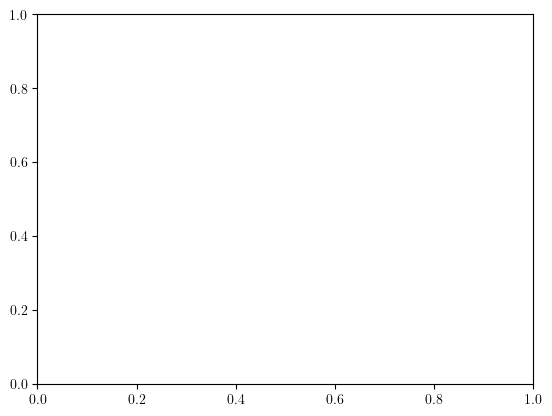

In [22]:
colors = sns.color_palette("Blues",2)
fig, ax = plt.subplots(ncols=1)
for i in range(2):
    K = s.kymesh[:,0][:Ny//2]
    for g in range(0,len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])
        plt.plot(K[g:g+2], barve[i,:Ny//2,Nx//2][g:g+2], color=colorFader(col1, col2, col))

colors = sns.color_palette("Reds",4)
for i in range(2,6):
    for g in range(0, len(K)-1):
        col = np.mean(barve[i, :Ny//2, Nx//2][g:g+2])
        plt.plot(K[g:g+2], barve[i,:Ny//2,Nx//2][g:g+2], color=colorFader(col1, col2, col))
ax.set_xlim(K[0],-0.05)

#ins.axis('off')
#ins.text(-1, 1, r'Ni', fontsize=13), ins.text(-1, 95, r'Ta', fontsize=13)
ax.set_ylim(0,1.01)

for n in range(101):
    ax.axhspan(n/99, (n+1)/99, 0.96, 1, color=colorFader(col1, col2, n/100))
ax.text(-0.045,0.02,'Ni', fontsize=16)
ax.text(-0.045,0.95,'Ta', fontsize=16)
ax.set_xlabel(r'$k_y\,[\text{\AA}^{-1}]$', fontsize=16)

ax.text(-0.05,-0.13,r'$\Gamma$', fontsize=14, color='magenta')
ax.text(-0.20,-0.13,r'$Z$', fontsize=14, color='magenta')
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.title(r'Značaj enodelčnih stanj vzdolž poti $Z$--$\Gamma$', fontsize=18)
ax.set_ylabel(r'$\sum_{j=1}^4 |a_{\bm{k}}|^2$', fontsize=16)

plt.tight_layout()
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")

plt.savefig('znacaj.png')

In [ ]:
energije_ = np.copy(energije)
vecs_ = np.copy(vecs)
barve_ = np.copy(barve)

for i in range(Ny):
    for j in range(Nx):
        razlike = np.diff(energije[:,i,j])
        find = np.where(razlike < 1e-2)
        if len(find[0]) != 0 and j > Nx//3 and j < int(2/3*Nx):
            if len(find[0]) == 1 and find[0] == [2]: pass
            else:
                for g in range(len(find[0])):
                    energije_[find[0][g],i,j:] = energije[find[0][g]+1,i,j:]
                    energije_[find[0][g]+1,i,j:] = energije[find[0][g],i,j:]
                    barve_[find[0][g],i,j:] = barve[find[0][g]+1,i,j:]
                    barve_[find[0][g]+1,i,j:] = barve[find[0][g],i,j:]

In [ ]:
colors = sns.color_palette("Blues",2)
fig, ax = plt.subplots(ncols=1)

for i in range(2):
    plt.plot(s.kymesh[:,0][:Ny//2], barve[i,:Ny//2,Nx//2], color=colors[i], label=f'${i+1}$')

colors = sns.color_palette("Reds",4)
for i in range(2,6):
    plt.plot(s.kymesh[:,0][:Ny//2], barve[i,:Ny//2,Nx//2], color=colors[i-2], label=f'${i+1}$')

plt.legend()



In [ ]:
barve[0,:,0]

In [ ]:

for i in range(Ny):
    for j in range(Nx):
        find = np.where(np.diff(energije[:,i,j]) < 1e-4)
        if len(find[0]) != 0 and j != 0:
            print(i,j)
            print(energije[:,i,j])
#

In [ ]:
dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 100, 2000, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Ny, Nx = 20, 20
mu = 2.84

s2 = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2)
s2.reset_infty()

scale = 1.05
beta0 = 0.5
betas = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,7.75,8,8.25,8.5,8.75,9]
print('number of betas=', len(betas))
ends = [int(np.emath.logn(scale, beta/beta0)) for beta in betas]
Ts = 1/np.array(betas)

for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    if i != 0: s2.reset_infty()
    set_betas = beta0 * scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s2.run(set_Ts)
    if i > 0: print(s2.phis[-1])

In [ ]:
#s.collect(), s2.collect(), s3.collect(), s4.collect()

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,6))
kb = 8.617333262 * 1e-5

ax[1,0].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.boltzmann_L1_xx/s.boltzmann_L0_xx * s.betas * kb * 1e6,
                                                         s4.boltzmann_L1_xx/s4.boltzmann_L0_xx * s4.betas * kb * 1e6]),'.-', color='blue')
ax[1,0].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.boltzmann_L1_yy/s.boltzmann_L0_yy * s.betas * kb * 1e6,
                                                         s4.boltzmann_L1_yy/s4.boltzmann_L0_yy * s4.betas * kb * 1e6]),'.-', color='green')

ax[1,1].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_xx.real / s.kubo_L0_xx.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_xx.real / s4.kubo_L0_xx.real * s4.betas * kb * 1e6]), '.-', color='blue')
ax[1,1].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_yy.real / s.kubo_L0_yy.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_yy.real / s4.kubo_L0_yy.real * s4.betas * kb * 1e6]), '.-', color='green')
ax[1,1].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_xy.real / s.kubo_L0_xy.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_xy.real / s4.kubo_L0_xy.real * s4.betas * kb * 1e6]), '.-', color='red')
ax[1,1].plot(np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_yx.real / s.kubo_L0_yx.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_yx.real / s4.kubo_L0_yx.real * s4.betas * kb * 1e6]), '.-', color='orange')

ax[0,0].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.boltzmann_L1_xx/s.boltzmann_L0_xx * s.betas * kb * 1e6,
                                                         s4.boltzmann_L1_xx/s4.boltzmann_L0_xx * s4.betas * kb * 1e6]),'.-', color='blue', label='$xx$')
ax[0,0].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.boltzmann_L1_yy/s.boltzmann_L0_yy * s.betas * kb * 1e6,
                                                         s4.boltzmann_L1_yy/s4.boltzmann_L0_yy * s4.betas * kb * 1e6]),'.-', color='green', label='$yy$')

ax[0,1].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_xx.real / s.kubo_L0_xx.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_xx.real / s4.kubo_L0_xx.real * s4.betas * kb * 1e6]), '.-', color='blue', label='$xx$')
ax[0,1].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_yy.real / s.kubo_L0_yy.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_yy.real / s4.kubo_L0_yy.real * s4.betas * kb * 1e6]), '.-', color='green', label='$yy$')
ax[0,1].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_xy.real / s.kubo_L0_xy.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_xy.real / s4.kubo_L0_xy.real * s4.betas * kb * 1e6]), '.-', color='red', label='$xy$')
ax[0,1].plot(1/np.hstack([s.betas, s4.betas]), -np.hstack([s.kubo_L1_yx.real / s.kubo_L0_yx.real * s.betas * kb * 1e6,
                                                         s4.kubo_L1_yx.real / s4.kubo_L0_yx.real * s4.betas * kb * 1e6]), '.-', color='orange', label='$yx$')
ax[0,0].set_xlim(1/15,1/1.5)
ax[0,1].set_xlim(1/15,1/1.5)
ax[1,0].set_xlim(1.5,15)
ax[1,1].set_xlim(1.5,15)

ax[0,1].set_ylim(-3000,0)
ax[1,1].set_ylim(-3000,0)
ax[0,0].set_ylim(-150,150)
ax[1,0].set_ylim(-150,150)

ax[0,1].legend(frameon=False, fontsize=12),ax[0,0].legend(frameon=False, fontsize=12)

for j in range(2):
    ax[0,j].set_xlabel(r'$k_BT\,[\text{eV}]$', fontsize=13)
    ax[1,j].set_xlabel(r'$\beta \,[\text{eV}^{-1}]$', fontsize=13)
    for g in range(2):
        ax[j,g].set_ylabel(r'$S$ [$\upmu \text{V} / \text{K}$]', fontsize=13)

ins = ax[0,1].inset_axes([1.3,0.3,0.7,0.7])
ins.plot(np.hstack([s.betas, s4.betas]),  np.hstack([s.phis, s4.phis]), '.-',color= 'black')
ins.set_xlim(5,15.5), ins.set_ylim(-0.01, 0.135), ins.set_xlabel(r'$\beta \,[\text{eV}^{-1}]$', fontsize=13)
ins.set_ylabel('$\phi_0$', fontsize=13)

xs = np.linspace(0.15,0.35)
ax[0,1].plot(xs, -1/xs * 320, color='black', ls='dashed'), ax[0,1].text(0.25,-1500, '$\propto 1/T$', color='black', fontsize=12)

beta_c = 9.7
ins.axvline(beta_c, color='grey', ls='dotted')
for j in range(2):
    ax[0,j].axvline(1/beta_c, color='grey', ls='dotted')
    ax[1,j].axvline(beta_c, color='grey', ls='dotted')
    for g in range(2):
        ax[j,g].axhline(0, color='grey', lw=0.5)

ins.text(6,0.1,rf'$\beta_c\approx{beta_c}$').set_bbox(dict(facecolor='grey', alpha=0.3))

ax[0,0].set_title(r'Boltzmannova metoda, $S(T)$', fontsize=14)
ax[0,1].set_title(r'Kubova metoda, $S(T)$', fontsize=14)
ax[1,0].set_title(r'Boltzmannova metoda, $S(\beta)$', fontsize=14)
ax[1,1].set_title(r'Kubova metoda, $S(\beta)$', fontsize=14)

ins.set_title(r'Ureditveni parameter', fontsize=14)

ins = ax[1,1].inset_axes([1.3,0.3,0.7,0.7])
ins.plot(np.hstack([s.betas, s4.betas]),  np.hstack([s.mus, s4.mus]), '.-',color= 'black')
ins.set_xlabel(r'$\beta \,[\text{eV}^{-1}]$', fontsize=13)
ins.set_ylabel(r'$\mu\,[\text{eV}]$', fontsize=13), ins.set_title(r'Kemijski potencial')
ins.axvline(beta_c, color='grey', ls='dotted')
ax[1,1].plot([10,15], [-1500,-2400], color='black', ls='dashed'), ax[1,1].text(15.5,-2500, '$\propto 1/T$', color='black', fontsize=12)

ins.set_xlim(5,15.5), ins.set_ylim([2.65,2.85])

plt.tight_layout()
#plt.xlim(0,20)
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\slike")

plt.savefig('24-06.png')

In [ ]:
plt.plot(s.betas, -s.kubo_L1_xx.imag/s.kubo_L0_xx.real)
plt.plot(s4.betas, -s4.kubo_L1_xx.imag/s4.kubo_L0_xx.real)

In [ ]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")


dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 100, 2000, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Ny, Nx = 20,20
mu = 2.84
s3 = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2)


scale = 1.01
beta0 = 25
betas = np.array([8.9,8.8,8.7,8.6,8.5])
ends = [int(np.emath.logn(scale, beta0/beta)) for beta in betas]
Ts = 1/betas

for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    if i != 0: s3.reset()
    set_betas = beta0/scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s3.run(set_Ts)
    if i > 0: print(s3.phis[-1])

In [ ]:
os.chdir("C:\\Users\\anast\\OneDrive\\Namizje\\1m\\poletje\\ta2nise5\\parameters")


dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 100, 2000, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Ny, Nx = 20,20
mu = 2.84
s4 = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2)


scale = 1.01
beta0 = 25
betas = np.array([8.3, 8.1, 7.9, 7.7, 7.5, 7.3, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5])
ends = [int(np.emath.logn(scale, beta0/beta)) for beta in betas]
Ts = 1/betas

for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    if i != 0: s4.reset()
    set_betas = beta0/scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s4.run(set_Ts)
    if i > 0: print(s4.phis[-1])

In [ ]:
dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 100, 2000, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters1 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials = 0.001, 10, 10, 1e-9, 0.5, 0.001, 1.5, 1e-3, 30
parameters2 = [dmu, maxiter, maxiter_last, eps_last, mix, mix2, mix3, n_pass, max_trials]

Ny, Nx = 16, 16
mu = 2.84

s2 = TNS(a, b, b2, Ny, Nx, U, V, mu, parameters1, parameters2)
s2.reset_infty()

scale = 1.1
beta0 = 1
betas = [2,3,4,5,6,7,8]
print('number of betas=', len(betas))
ends = [int(np.emath.logn(scale, beta/beta0)) for beta in betas]
Ts = 1/np.array(betas)

for i, T in enumerate(Ts):
    print(1/T)
    print('-------------')
    if i != 0: s2.reset_infty()
    set_betas = beta0 * scale**np.arange(ends[i])
    set_Ts = 1/set_betas
    s2.run(set_Ts)
    if i > 0: print(s2.phis[-1])